# Muon/Track Study

This is a python notebook to help you get started analyzing simulated muon collider data.

This notebook focus on the muon gun sample, which simulates a single muon per event in the detector.

We'll compare those 'truth' muons to reconstructed inner detector tracks and muon particle flow candidates

In [1]:
# Import relevant packages

import uproot # conda install -c conda-forge uproot
import vector # conda install -c conda-forge vector
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-v0_8-colorblind')

In [145]:
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.major.size' : 10}) 
plt.rcParams.update({'ytick.major.size' : 10}) 
plt.rcParams.update({'xtick.minor.size' : 5}) 
plt.rcParams.update({'ytick.minor.size' : 5}) 
plt.rcParams.update({'axes.labelsize' : "large"}) 

## Inspect the file contents

* Open a single root file with uproot
* Access the tree 'events'
* And print out the list of branches in the tree

In [2]:
# open a single file for testing

f = uproot.open("/Users/isaac/Downloads/muonGun_reco_480.root")

In [3]:
treeB = f["events"]

In [4]:
# Get the list of branches in the tree
for branch in treeB.keys():
    print(branch)

TightSelectedPandoraPFOs#0
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.index
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.collectionID
SiTracks#0
SiTracks#0/SiTracks#0.index
SiTracks#0/SiTracks#0.collectionID
SelectedPandoraPFOs#0
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.index
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.collectionID
LooseSelectedPandoraPFOs#0
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.index
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.collectionID
LE_SelectedPandoraPFOs#0
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.index
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.collectionID
LE_LooseSelectedPandoraPFOs#0
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.index
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.collectionID
MCPhysicsParticles#0
MCPhysicsParticles#0/MCPhysicsParticles#0.index
MCPhysicsParticles#0/MCPhysicsParticles#0.collectionID
YokeEndcapCollection
YokeEndcapCollection/YokeEndcap

In [5]:
treeB.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
TightSelectedPand... | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'Ti...
TightSelectedPand... | int32_t[]                | AsJagged(AsDtype('>i4'))
TightSelectedPand... | int32_t[]                | AsJagged(AsDtype('>i4'))
SiTracks#0           | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'Si...
SiTracks#0/SiTrac... | int32_t[]                | AsJagged(AsDtype('>i4'))
SiTracks#0/SiTrac... | int32_t[]                | AsJagged(AsDtype('>i4'))
SelectedPandoraPF... | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'Se...
SelectedPandoraPF... | int32_t[]                | AsJagged(AsDtype('>i4'))
SelectedPandoraPF... | int32_t[]                | AsJagged(AsDtype('>i4'))
LooseSelectedPand... | vector<podio::ObjectID>  | AsGroup(<TBranchElement 'Lo...
LooseSelectedPand... | int32_t[]                | AsJagged(AsDty

SiTracks_Refitted... | int32_t[]                | AsJagged(AsDtype('>i4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[]                  | AsJagged(AsDtype('>f4'))
SiTracks_Refitted... | float[][21]              | AsJagged(AsDtype("('>f4', (...
SiTracks_Refitted_2  | vector<edm4hep::Quant... | AsGroup(<TBranchElement 'Si...
SiTracks_Refitted... | int16_t[]                | AsJagged(AsDtype('>i2'))
SiTracks_Refi

##  Convenient ways to access information from multiple files

1. Read in multiple files at once with
```
uproot.concatenate # to process all files at once
uproot.iterate # to process in batches
```
2. Zip up useful information about truth particles ```MCParticle```, muon spectrometer hits ```MUON```, and silicon tracks ```SiTracks_Refitted``` into position/momentum vectors. 

```
vector.register_awkward()
particles = ak.zip({"px": ..., "py": ...}, with_name="Momentum4D")
```

See https://github.com/scikit-hep/vector to learn about possible types of & what information you need to form vectors

See https://github.com/key4hep/EDM4hep/blob/master/edm4hep.yaml for more info about edm4hep format


In [6]:
#
# open multiple files at once, only save relevant information
#
tree = uproot.concatenate("/Users/isaac/Downloads/muonGun_reco_*.root:events",filter_name=["MC*","MUON*","SiTracks*", "*TrackerHits*", "PARAMETERS*"])


## Read in Monte Carlo truth particles


Learn pdgID naming conventions here:
https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf 

Learn more about MC data format, including generator status codes here
https://arxiv.org/pdf/1912.08005.pdf 

In [7]:
# read in truth particles from Monte Carlo
vector.register_awkward()
mcPart = ak.zip({"px": tree["MCParticle.momentum.x"], 
                 "py": tree["MCParticle.momentum.y"], 
                 "pz": tree["MCParticle.momentum.z"], 
                 "mass": tree["MCParticle.mass"], 
                 "pdg": tree["MCParticle.PDG"],
                 "status": tree["MCParticle.generatorStatus"],
                 "vtxX" : tree["MCParticle.vertex.x"],
                 "vtxY" : tree["MCParticle.vertex.y"],
                 "vtxZ" : tree["MCParticle.vertex.z"],
                 "endX" : tree["MCParticle.endpoint.x"],
                 "endY" : tree["MCParticle.endpoint.y"],
                 "endZ" : tree["MCParticle.endpoint.z"],
                 "charge": tree["MCParticle.charge"],
                 "time" : tree["MCParticle.time"]},
                                   with_name="Momentum4D")


# select only status 1 particles, with muon PDG ID
truthMuons = mcPart[ (mcPart.status==1) & (abs(mcPart.pdg)==13)]


In [8]:
# read in truth particles from Monte Carlo
vector.register_awkward()
mcPart = ak.zip({"px": tree["MCParticle.momentum.x"], 
                 "py": tree["MCParticle.momentum.y"], 
                 "pz": tree["MCParticle.momentum.z"], 
                 "mass": tree["MCParticle.mass"], 
                 "pdg": tree["MCParticle.PDG"],
                 "status": tree["MCParticle.generatorStatus"],
                 "vtxX" : tree["MCParticle.vertex.x"],
                 "vtxY" : tree["MCParticle.vertex.y"],
                 "vtxZ" : tree["MCParticle.vertex.z"],
                 "endX" : tree["MCParticle.endpoint.x"],
                 "endY" : tree["MCParticle.endpoint.y"],
                 "endZ" : tree["MCParticle.endpoint.z"],
                 "charge": tree["MCParticle.charge"],
                 "time" : tree["MCParticle.time"]},
                                   with_name="Momentum4D")


# select only status 1 particles, with muon PDG ID
truthMuons = mcPart[ (mcPart.status==1) & (abs(mcPart.pdg)==13)]

In [9]:
for i in range(10):
    print(len(mcPart.px[i]))

3
2
1
1
1
1
1
2
1
2


In [10]:
help (vector.register_awkward)

Help on function register_awkward in module vector:

register_awkward() -> 'None'
    Make Vector behaviors known to Awkward Array's ``ak.behavior`` mechanism.
    
    If you call this function, any records named ``Vector2D``, ``Vector3D``,
    ``Vector4D``, ``Momentum2D``, ``Momentum3D``, and ``Momentum4D`` will have
    vector properties and methods.
    
    If you do not call this function, only arrays created with
    :func:`vector.Array` (or derived from such an array) have vector properties
    and methods.



In [11]:
help(ak.zip)

Help on function zip in module awkward.operations.ak_zip:

zip(arrays, depth_limit=None, *, parameters=None, with_name=None, right_broadcast=False, optiontype_outside_record=False, highlevel=True, behavior=None)
    Args:
        arrays (dict or iterable of arrays): Each value in this dict or iterable
            can be any array-like data that #ak.to_layout recognizes.
        depth_limit (None or int): If None, attempt to fully broadcast the
            `array` to all levels. If an int, limit the number of dimensions
            that get broadcasted. The minimum value is `1`, for no
            broadcasting.
        parameters (None or dict): Parameters for the new
            #ak.contents.RecordArray node that is created by this operation.
        with_name (None or str): Assigns a `"__record__"` name to the new
            #ak.contents.RecordArray node that is created by this operation
            (overriding `parameters`, if necessary).
        right_broadcast (bool): If True, fol

## Test different ways to access information

* printout an entire array at once
* loop over one event at a time, and one particle at a time

In [12]:
# printout the awkward array itself
print(truthMuons.pt)
print("")

# printout info per event
for i in range(0,10):
    
    print("event ",i)
    
    for muon in truthMuons[i]:
        print("  pt {:.1f}, eta {:.1f}, phi {:.1f}".format(muon.pt, muon.eta, muon.phi))
        
    if i > 3: break


[[500], [42.2], [124], [522], [439], ..., [33.3], [372], [209], [369], [162]]

event  0
  pt 500.2, eta -1.0, phi -1.5
event  1
  pt 42.2, eta 1.5, phi 2.1
event  2
  pt 123.9, eta -0.8, phi -2.7
event  3
  pt 521.6, eta -0.9, phi -1.8
event  4
  pt 439.4, eta -1.0, phi -0.6


## Read in Muon System Hits


In [13]:
# read in Muon System Hits
muonHits = ak.zip({"x" : tree["MUON.position.x"], 
                "y" : tree["MUON.position.y"], 
                "z" : tree["MUON.position.z"], 
                "E" : tree["MUON.energy"], 
                "Eerr" : tree["MUON.energyError"], 
                "t": tree["MUON.energy"], 
                "type": tree["MUON.type"] },
                                   with_name="VectorObject4D")


## Read in Inner Detector Tracks

We're interested in ```SiTracks_Refitted```. 

Note that ```SiTracks_Refitted_1``` saves track parameter measurements at four different locations. We're only  interested in location==1
*    AtOther = 0  # any location other than the ones defined below
*    AtIP = 1 
*    AtFirstHit = 2 
*    AtLastHit = 3 
*    AtCalorimeter = 4 
*    AtVertex = 5 
*    LastLocation = AtVertex  



In [14]:
# Some useful code for converting from measured track parameters to pt/theta
# adapted from https://github.com/madbaron/LCIOmacros/blob/master/study_tracks.py

Bfield = 3.56  # T

def pt(omega):
    pt = 0.3 * Bfield / abs(omega * 1000.)
    return pt

def theta(tanLambda):
    theta = math.pi/2- np.arctan(tanLambda)
    return theta


In [15]:
# read in Inner Detector tracks

atIP = tree["SiTracks_Refitted_1.location"]==1 # select only measurements at IP

track_mass = 0.135*ak.ones_like(tree["SiTracks_Refitted.type"]) # make a mass array to initialize lorentz vector

# read in silicon tracks.... not sure if this is the collection we want, probably all tracks
tracks = ak.zip({"pt"    : pt(tree["SiTracks_Refitted_1.omega"][atIP]) ,
                 "theta" : theta(tree["SiTracks_Refitted_1.tanLambda"][atIP]) ,
                 "phi"   : tree["SiTracks_Refitted_1.phi"][atIP] ,
                 "mass"  : track_mass,
                 "d0"    : tree["SiTracks_Refitted_1.D0"][atIP], 
                 "z0"    : tree["SiTracks_Refitted_1.Z0"][atIP], 
                 "t"     : tree["SiTracks_Refitted_1.time"][atIP] ,
                 "chi2"  : tree["SiTracks_Refitted.chi2"], 
                 "ndf"   : tree["SiTracks_Refitted.ndf"], 
                 "dEdx"  : tree["SiTracks_Refitted.dEdx"], 
                 "rInner" : tree["SiTracks_Refitted.radiusOfInnermostHit"]},
                                   with_name="Momentum4D")

## Now make some plots!

In [150]:
# a handy plotting function
def plot1DHistogram(data,bins,scale='linear',label="", savefig=False, dpi=300):
    
    # handle data, there must be a smarter way to do this...
    if type(data[0])==np.int64 : data_flat=data
    elif type(data[0])==np.float32 : data_flat=data
    elif type(data[0])==np.float64 : data_flat=data
    else: data_flat = ak.flatten(data)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    ax.hist(data_flat, bins=bins)
    
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.yscale(scale)
    if savefig:
        plt.savefig(title + ".png", dpi=dpi)
    plt.show()

In [149]:
# a handy plotting function
def plot2DHistogram(datax, datay, bins=100, norm="log", label="", savefig=False, dpi=300):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="plasma")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel, fontsize=15)

    if savefig:
        plt.savefig(title + ".png", dpi=dpi)
    plt.show()

## Truth Muon Distributions


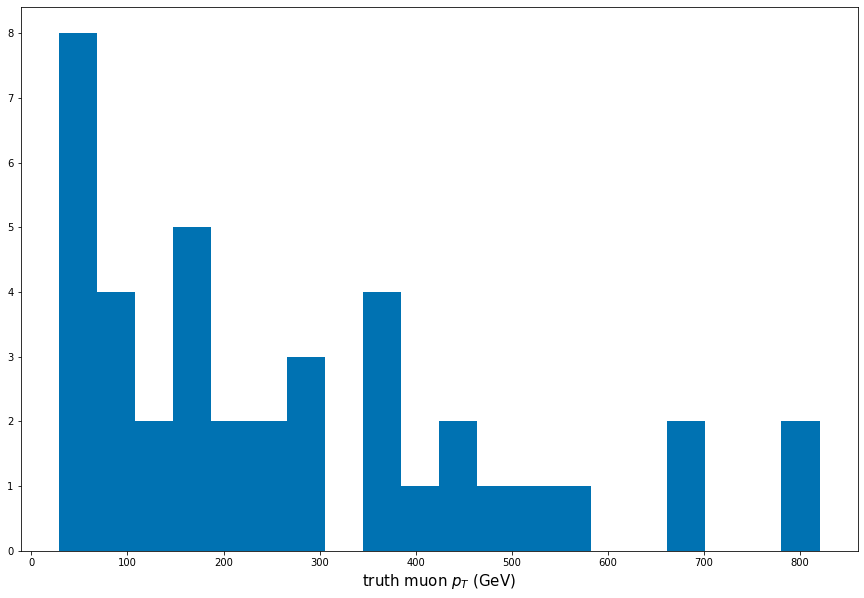

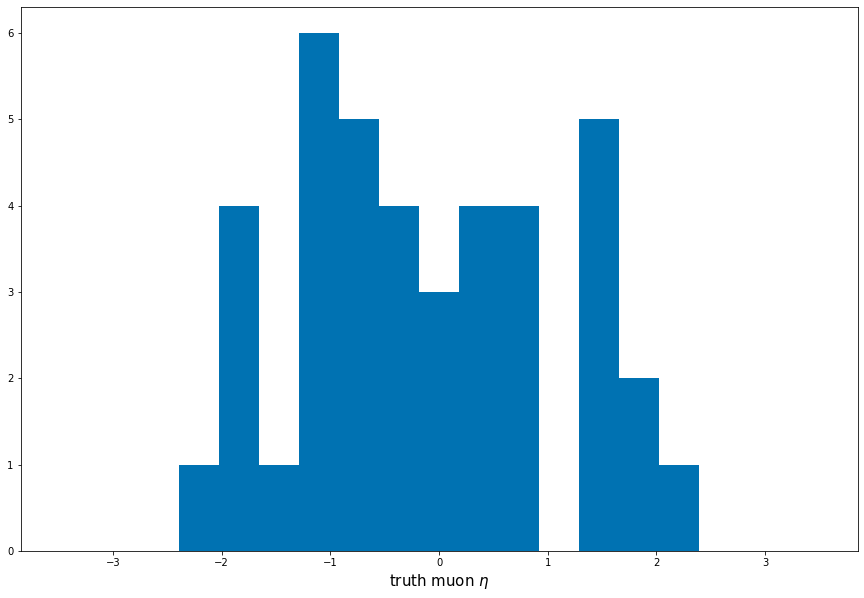

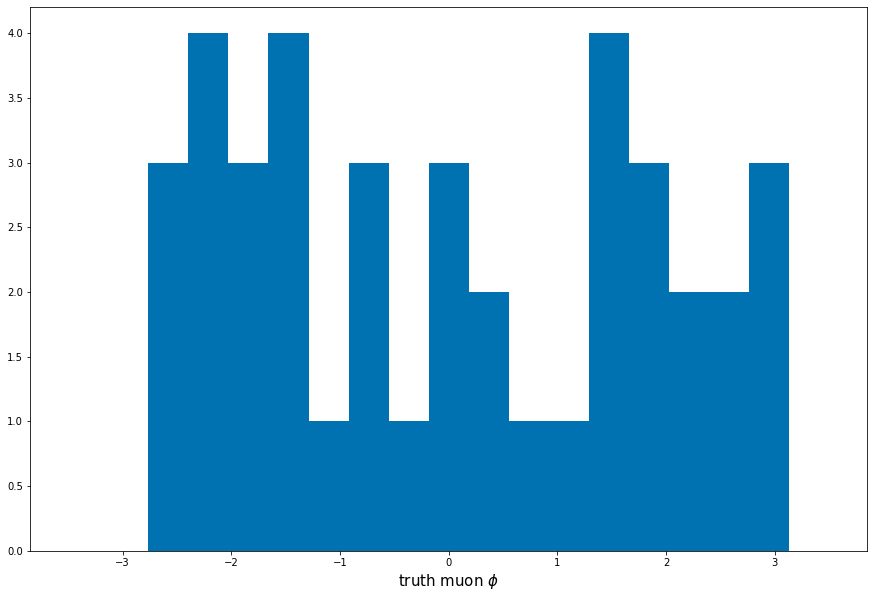

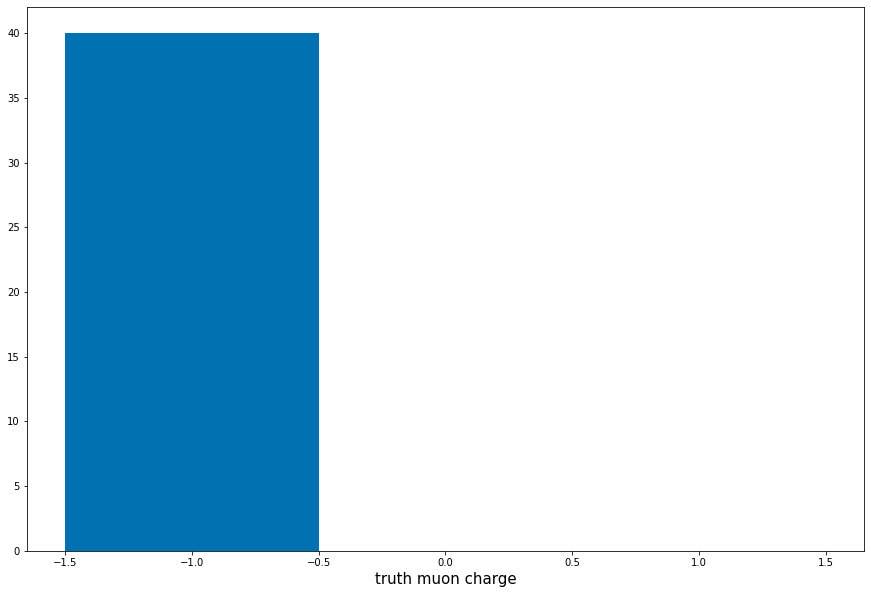

In [18]:

plot1DHistogram(truthMuons.pt     , bins=20  , label=";truth muon $p_{T}$ (GeV)")
plot1DHistogram(truthMuons.eta    , np.linspace(-3.5,3.5,20), label=";truth muon $\eta$")
plot1DHistogram(truthMuons.phi    , np.linspace(-3.5,3.5,20), label=";truth muon $\phi$")
plot1DHistogram(truthMuons.charge , np.linspace(-1.5,1.5,4) , label=";truth muon charge")


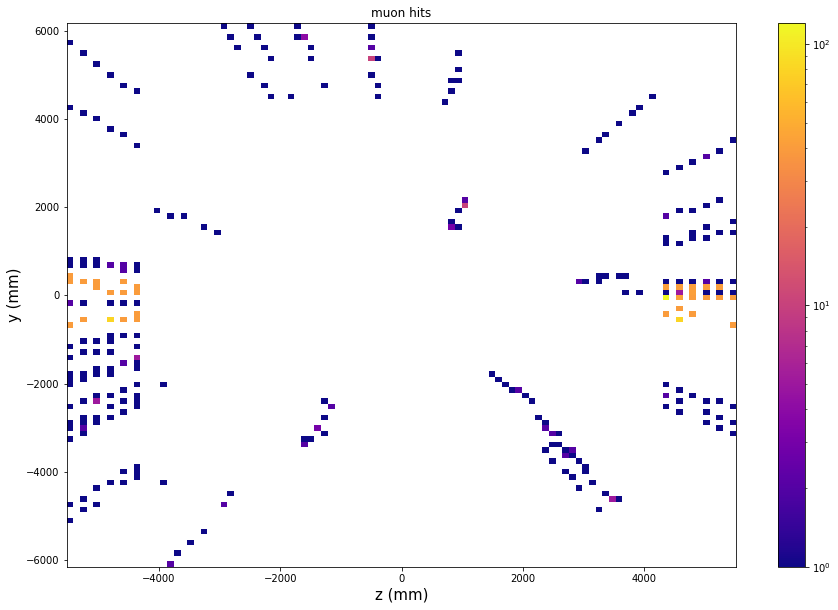

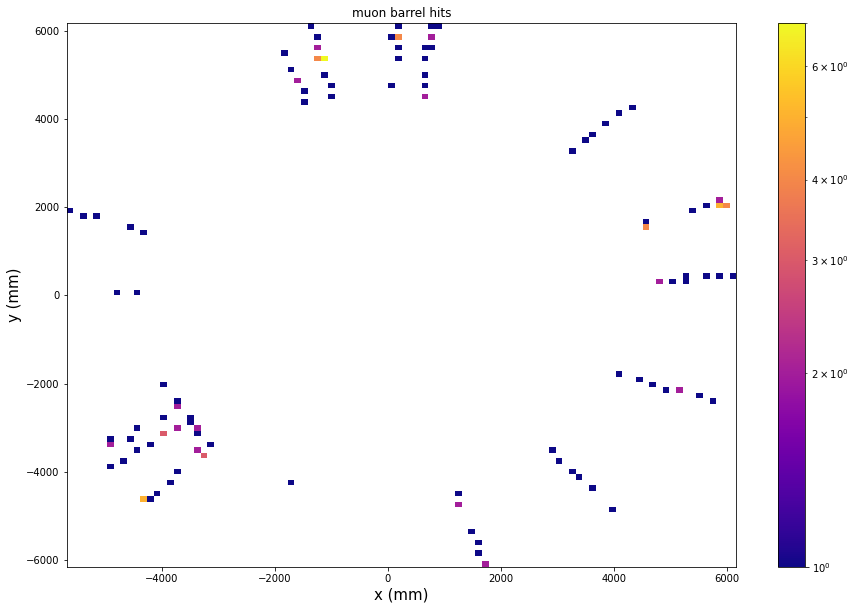

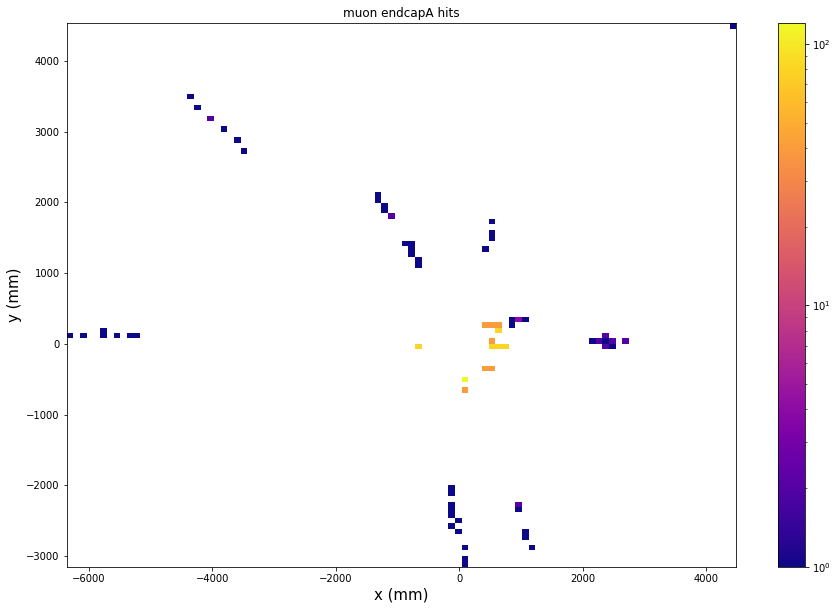

In [19]:
#plot muons
plot2DHistogram(muonHits.z, muonHits.y , bins=100, label="muon hits;z (mm);y (mm)")

# separate into barrel and endcap
barrel=abs(muonHits.z)<4000
endcapA=muonHits.z>4000
plot2DHistogram(muonHits.x[barrel], muonHits.y[barrel] , bins=100, label="muon barrel hits;x (mm);y (mm)")
plot2DHistogram(muonHits.x[endcapA], muonHits.y[endcapA] , bins=100, label="muon endcapA hits;x (mm);y (mm)")

In [20]:
print(truthMuons.vtxX)
print(truthMuons.vtxY)
print(truthMuons.vtxZ)

[[0], [0], [0], [0], [0], [0], [0], [0], ..., [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], ..., [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], ..., [0], [0], [0], [0], [0], [0], [0]]


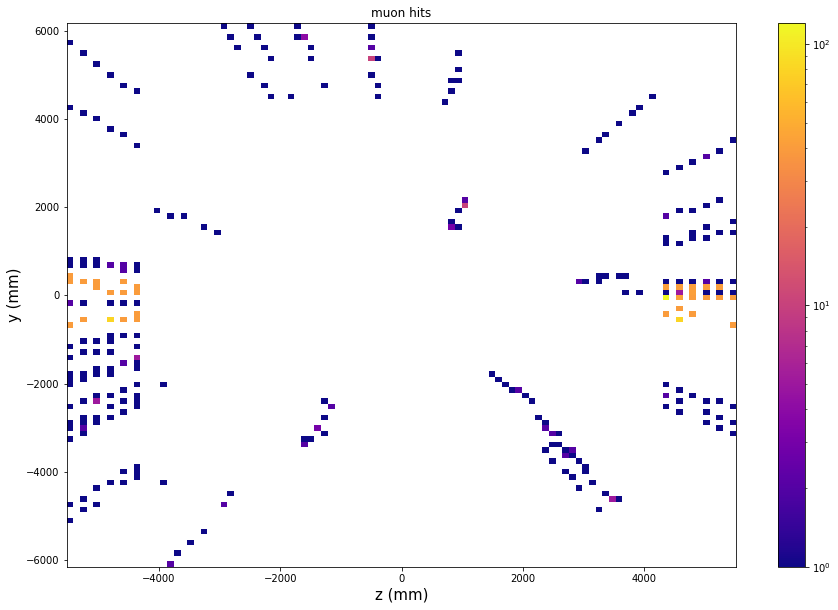

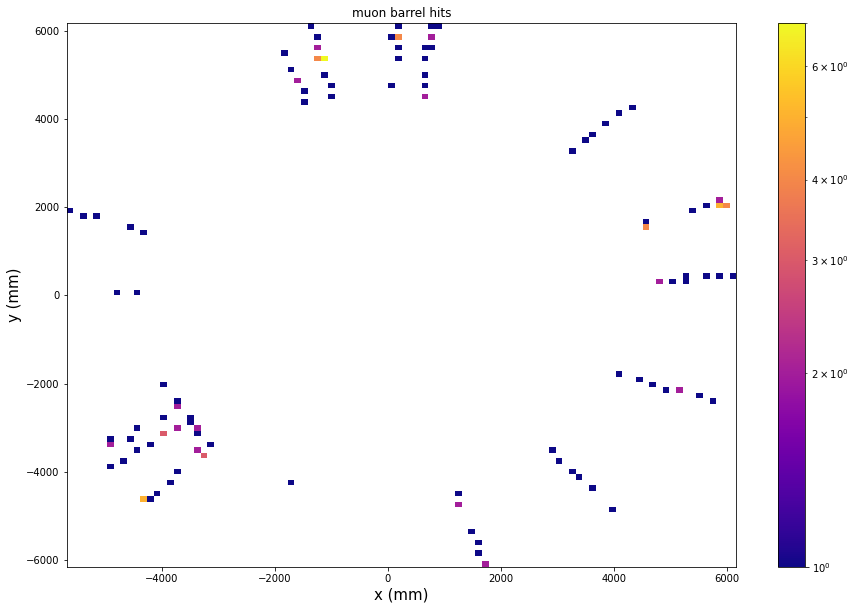

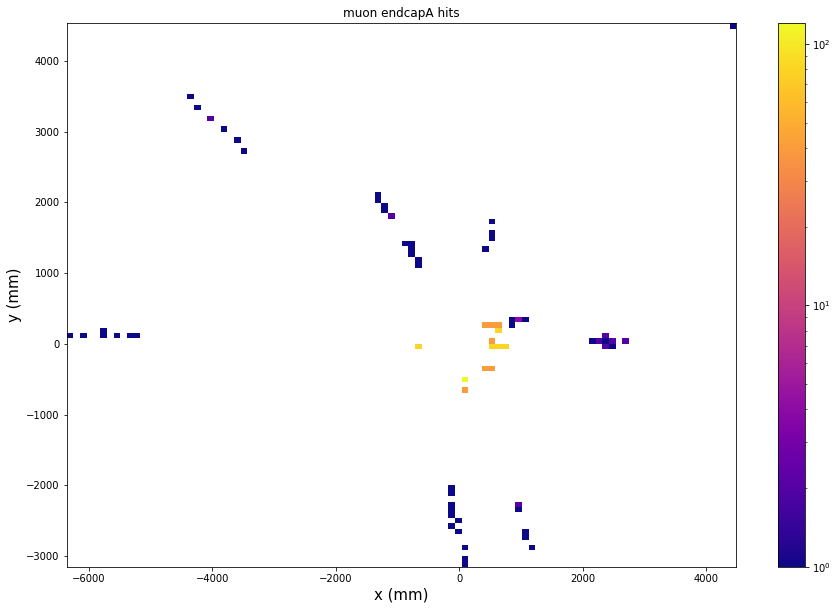

In [21]:
#plot muons
plot2DHistogram(muonHits.z, muonHits.y , bins=100, label="muon hits;z (mm);y (mm)")

# separate into barrel and endcap
barrel=abs(muonHits.z)<4000
endcapA=muonHits.z>4000
plot2DHistogram(muonHits.x[barrel], muonHits.y[barrel] , bins=100, label="muon barrel hits;x (mm);y (mm)")
plot2DHistogram(muonHits.x[endcapA], muonHits.y[endcapA] , bins=100, label="muon endcapA hits;x (mm);y (mm)")


## Plot tracks without any selections


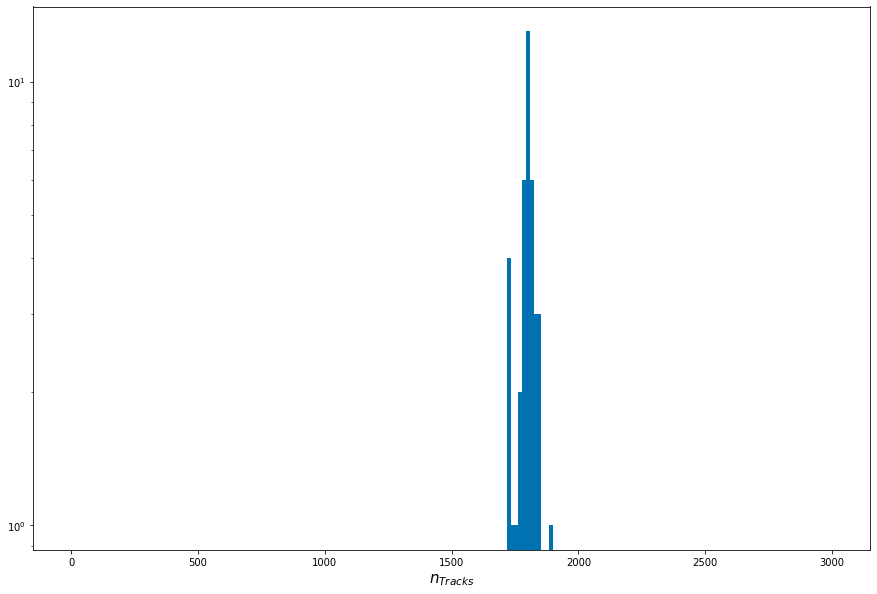

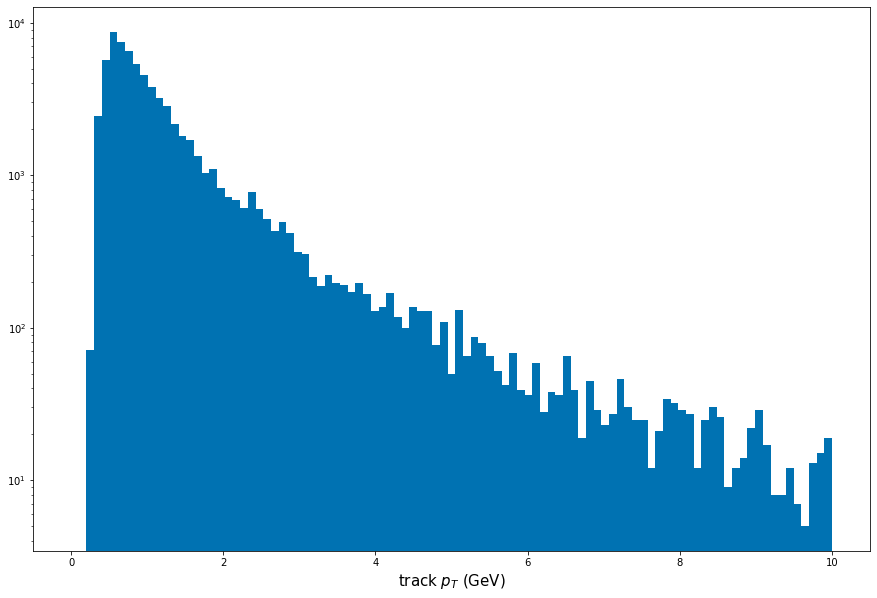

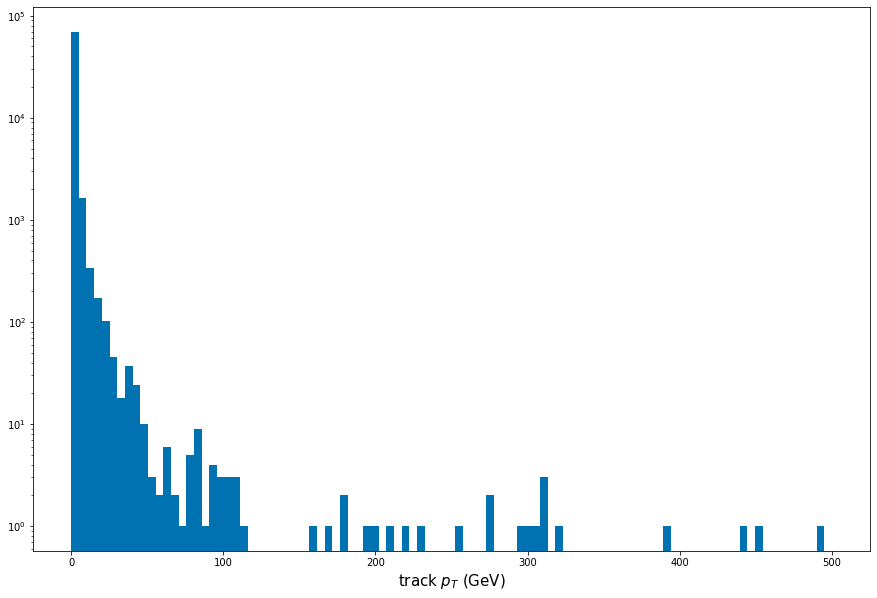

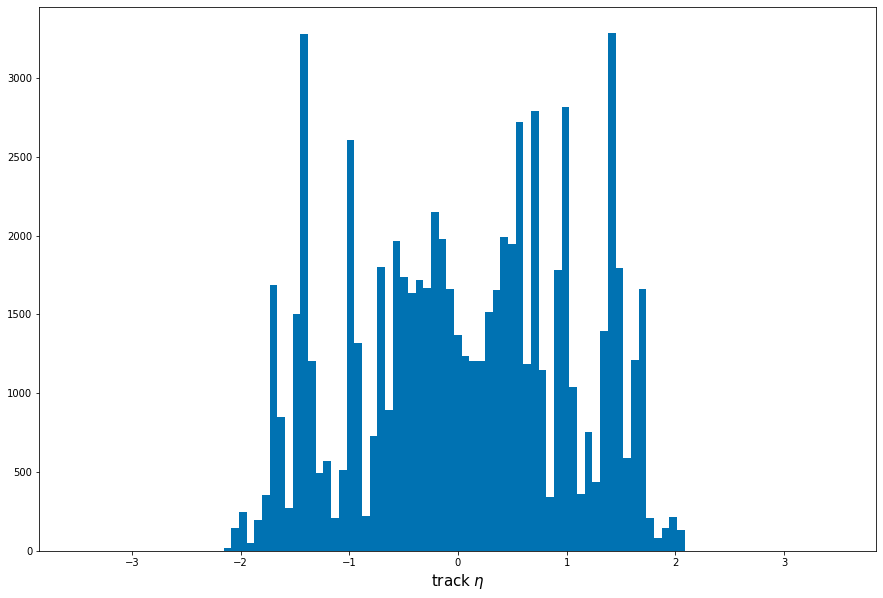

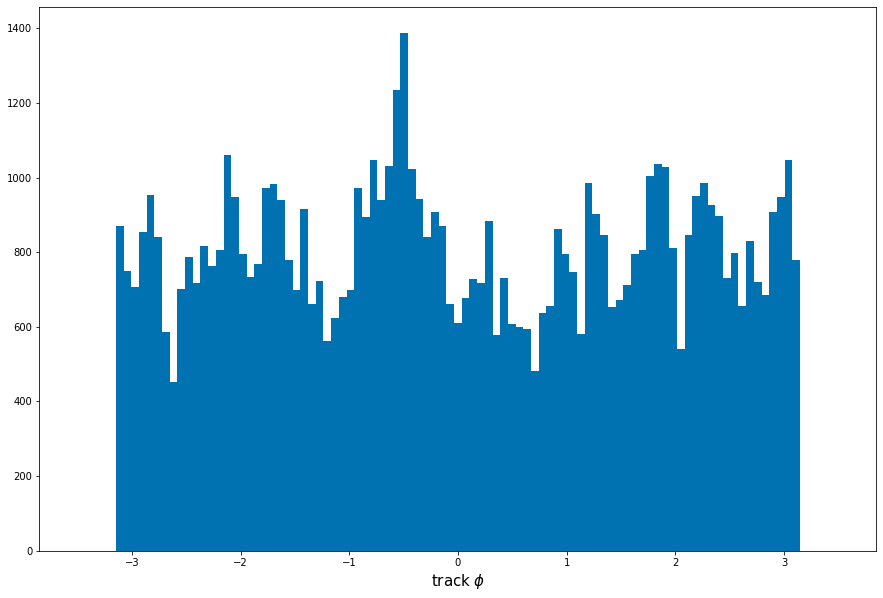

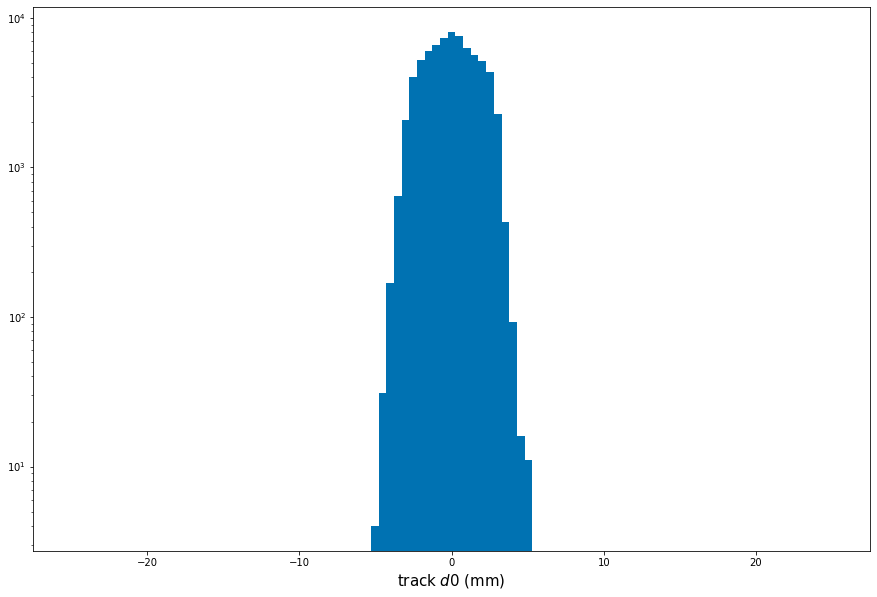

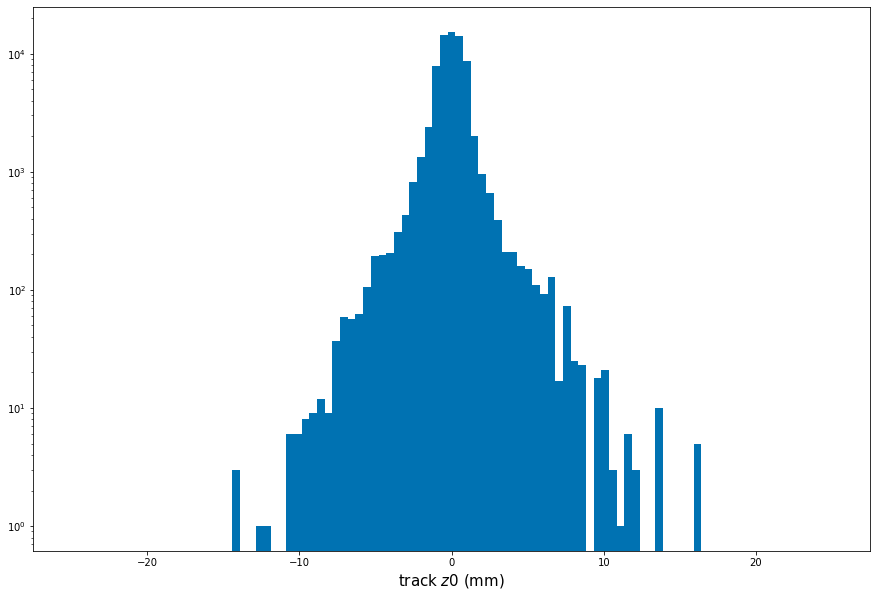

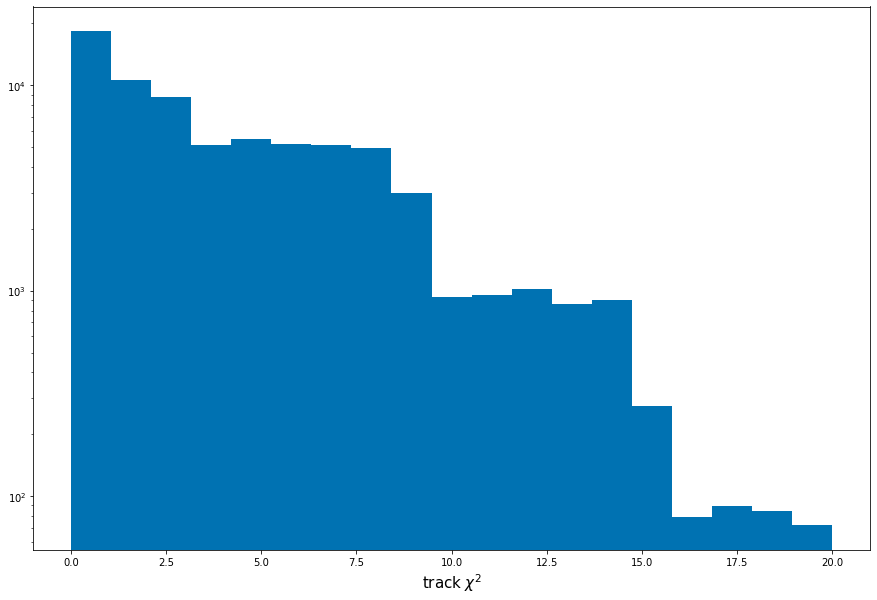

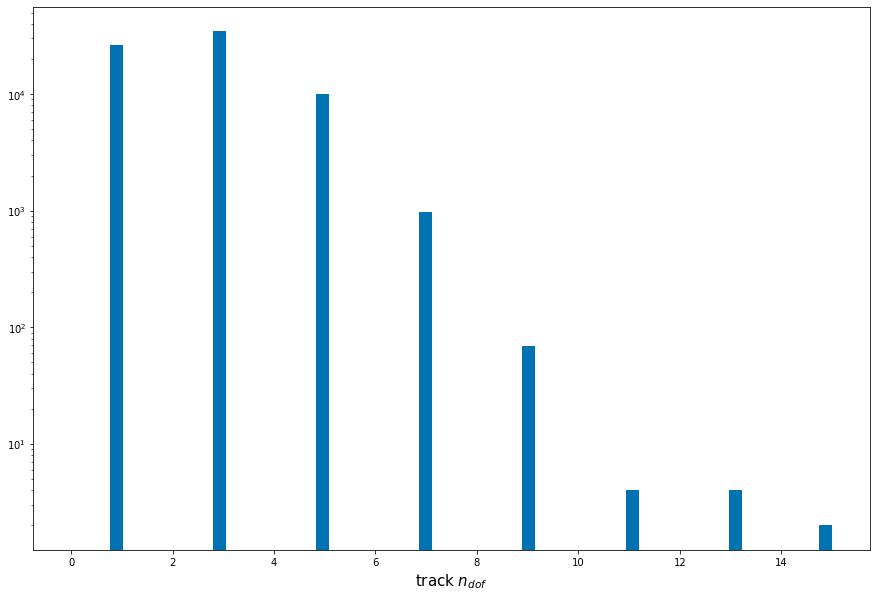

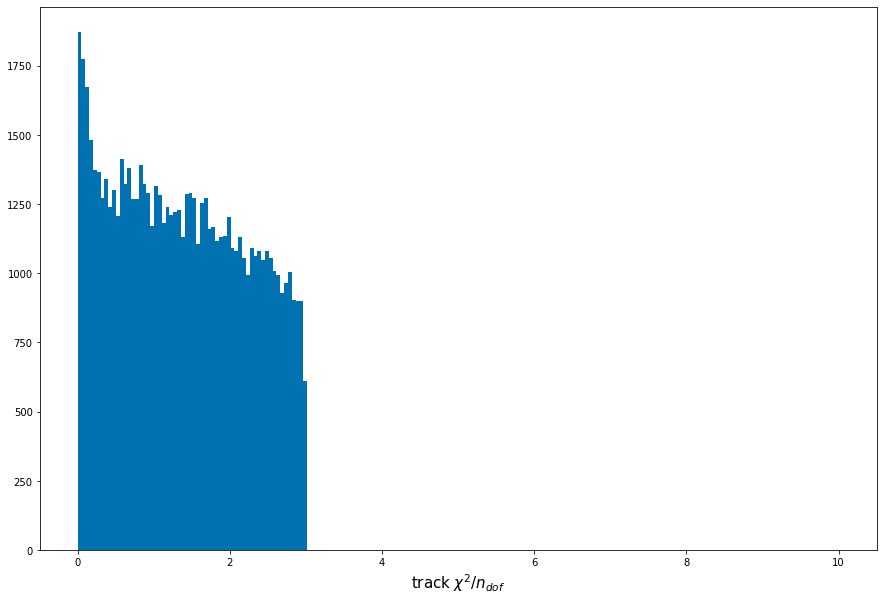

In [22]:

# basic kinematics
plot1DHistogram(ak.num(tracks) , bins=np.linspace(0,3000,200), scale='log', label=";$n_{Tracks}$")

plot1DHistogram(tracks.pt , bins=np.linspace(0,10,100), scale='log', label=";track $p_T$ (GeV)")
plot1DHistogram(tracks.pt , bins=np.linspace(0,500,100), scale='log', label=";track $p_T$ (GeV)")
plot1DHistogram(tracks.eta, bins=np.linspace(-3.5,3.5,100), label=";track $\eta$")
plot1DHistogram(tracks.phi, bins=np.linspace(-3.5,3.5,100), label=";track $\phi$")

# impact parameters, distance of closest approach
plot1DHistogram(tracks.d0, bins=np.linspace(-25,25,100), scale='log', label=";track $d{0}$ (mm)")
plot1DHistogram(tracks.z0, bins=np.linspace(-25,25,100), scale='log', label=";track $z{0}$ (mm)")

# quality variables
plot1DHistogram(tracks.chi2, bins=np.linspace(0,20,20), scale='log', label=";track $\chi^2$")
plot1DHistogram(tracks.ndf , bins=np.linspace(0,15,60), scale='log', label=";track $n_{dof}$")
plot1DHistogram(tracks.chi2/tracks.ndf, bins=np.linspace(0,10,200), label=";track $\chi^2/n_{dof}$")


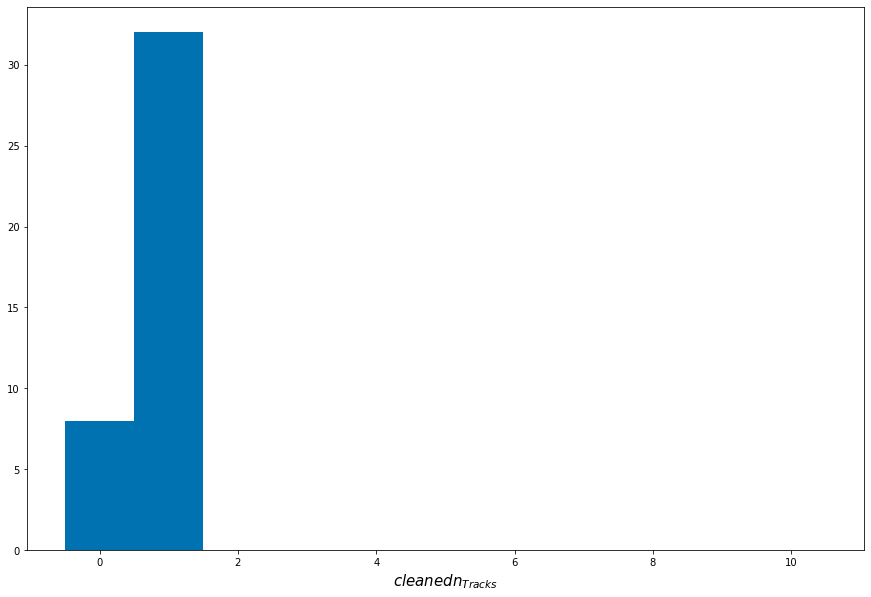

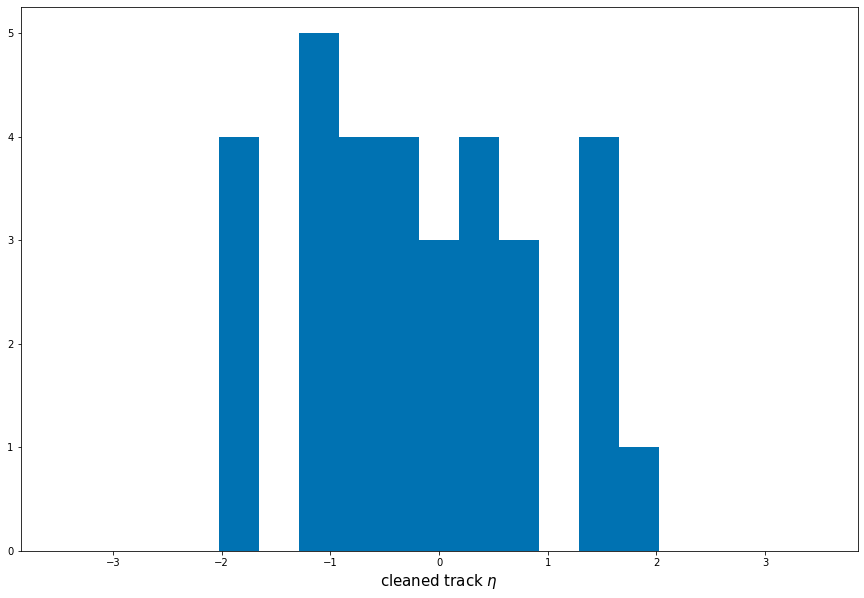

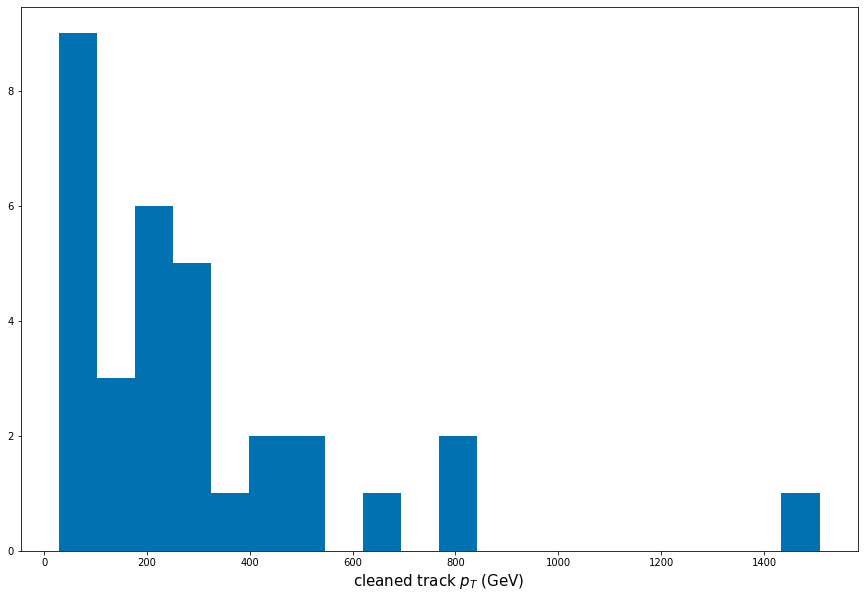

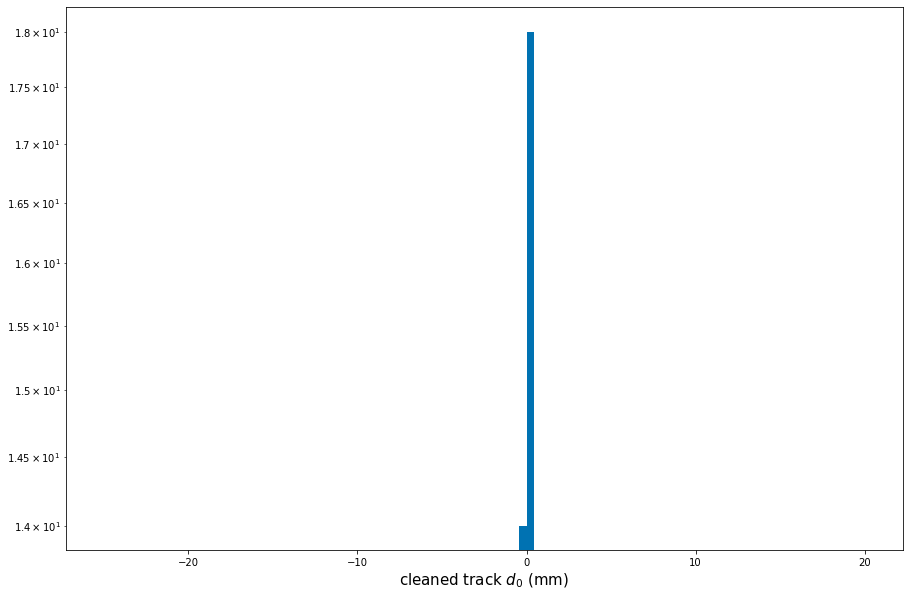

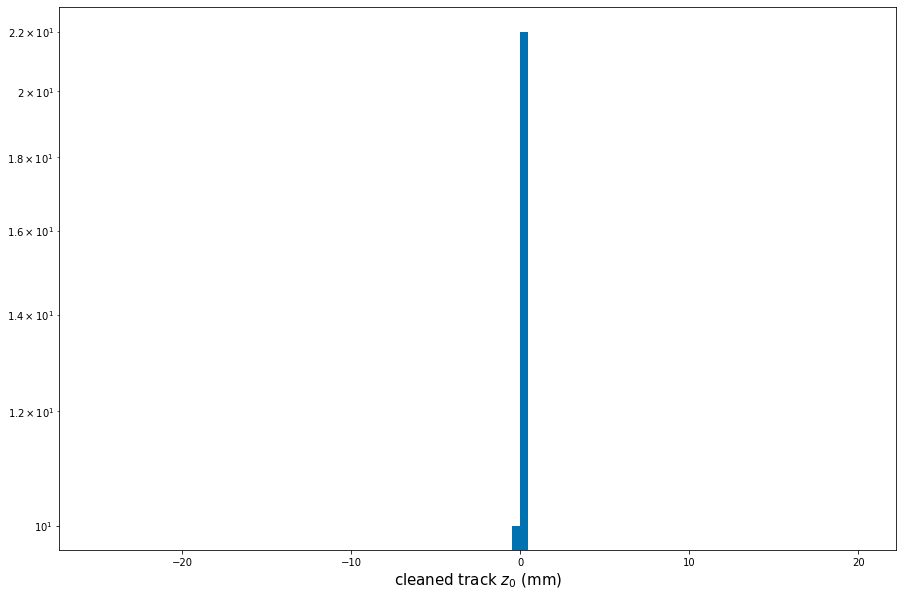

In [23]:
# try and select high quality tracks
clean=(tracks.ndf>7)&(tracks.pt>1) # use ndf as a proxy for-nhits

plot1DHistogram(ak.num(tracks[clean]), bins=np.linspace(-0.5,10.5,12), label=";$cleaned n_{Tracks}$")

plot1DHistogram(tracks.eta[clean], bins=np.linspace(-3.5,3.5,20), label=";cleaned track $\eta$")
plot1DHistogram(tracks.pt[clean], bins=20, scale='linear', label=";cleaned track $p_{T}$ (GeV)")

plot1DHistogram(tracks.d0[clean], bins=np.linspace(-25,20,100), scale='log', label=";cleaned track $d_0$ (mm)")
plot1DHistogram(tracks.z0[clean], bins=np.linspace(-25,20,100), scale='log', label=";cleaned track $z_0$ (mm)")



#  Now try to match truth muons to tracks

Match truth muons to the track closest in $\Delta R= \sqrt {\Delta\eta)^2 +(\Delta\phi)^2}$

Compare 'truth matched' tracks to 'unmatched' tracks. Note down differences in pt, eta, phi, quality of fit, number of hits on track etc. How do these differences compare to the 'track cleaning' from before?


Do the same for Muon Hits, what rate of muon hits are not matched to a collision particle?

In [24]:
cleanTracks=tracks[(tracks.ndf>5)&(tracks.pt>1)] # to start, leave cut on ndf a little loose

all_pairs = ak.cartesian([cleanTracks,truthMuons])

In [25]:
# Test that it did what we want
for i in range(0,10):
    print(i, all_pairs[i])

0 [({pt: 492, theta: 2.42, ...}, {px: 13, ...})]
1 [({pt: 1.04, theta: 2.19, ...}, {px: -21.6, ...}), ({...}, {...})]
2 [({pt: 278, theta: 2.3, phi: ..., ...}, {px: -111, ...})]
3 []
4 [({pt: 440, theta: 2.45, ...}, {px: 364, ...})]
5 [({pt: 40.7, theta: 2.5, ...}, {px: -39.8, ...}), (...), ({...}, {...})]
6 [({pt: 836, theta: 1.07, ...}, {px: -557, ...})]
7 [({pt: 1.12, theta: 0.578, ...}, {px: -22.5, ...}), ({...}, {...})]
8 [({pt: 34.1, theta: 1.02, ...}, {px: 34.3, ...}), (...), ({...}, {...})]
9 [({pt: 168, theta: 1.41, ...}, {px: -50.3, ...})]


In [26]:
# Now unzip for computing angles
trks, mus = ak.unzip(all_pairs)

# Identify pair with the minimum dR
dRs = trks.deltaR(mus)
which = ak.argmin(abs(dRs), axis=1, keepdims=True) 

# also require dR < 0.1
dRcut = dRs[which]<0.1
matched = which[dRcut]

for i in range(0,10):
    print(i, dRs[i], which[i], matched[i], trks[matched][i].pt, mus[matched][i].pt)

0 [2.19e-05] [0] [0] [492] [500]
1 [2.99, 3.38e-05] [1] [1] [41.6] [42.2]
2 [0.000842] [0] [0] [278] [124]
3 [] [None] [None] [None] [None]
4 [1.82e-05] [0] [0] [440] [439]
5 [6.88e-05, 1.87, 2.62] [0] [0] [40.7] [40.9]
6 [2.37e-05] [0] [0] [836] [820]
7 [2.42, 0.000137] [1] [1] [45.5] [45.6]
8 [2.87e-05, 1.9, 0.459] [0] [0] [34.1] [34.3]
9 [4.65e-05] [0] [0] [168] [169]


In [27]:
# a handy plotting function
colors = []
def compare1DHistograms(datas,bins,scale='linear',label="",leg=[]):

    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    
    for i,data in enumerate(datas): 

        # handle data, there must be a smarter way to do this...
        if type(data[0])==np.int64   : data_flat=data
        elif type(data[0])==np.float32 : data_flat=data
        else : data_flat = ak.flatten(data, axis=None)
            
        ax.hist(data_flat, bins, alpha=0.5, label=leg[i] if len(leg)>i else "")
   
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.legend()
    plt.yscale(scale)
    plt.show()

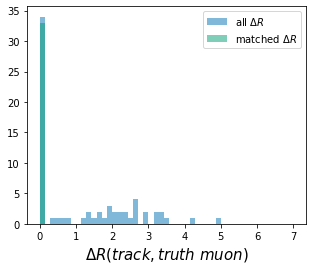

In [28]:
# plot all dRs

arrays = [dRs,dRs[matched]]
legends= ["all $\Delta R$", "matched $\Delta R$"]

compare1DHistograms(arrays, bins=np.linspace(0,7,50), leg=legends, label=";$\Delta R(track, truth~muon)$")


# Follow up

Investigate the following
* Efficiency: What fraction of truth muons were reconstructed as 'clean tracks'?
* Fake rate: What fraction of clean tracks were not matched to a truth muon?
* How would loosening your clean track selection improve efficiency? improve your fake rate?
* How close are the reconstructed tracks parameters to those of the truth muon? eg. pT, eta, phi, etc

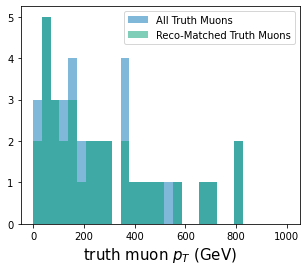

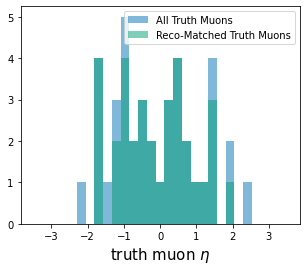

In [29]:
# Steps towards efficiency
recodMuons = mus[matched]

arrays = [truthMuons.pt,recodMuons.pt]
legend = [ "All Truth Muons","Reco-Matched Truth Muons"]
compare1DHistograms(arrays, bins=np.linspace(0,1000,30), leg=legend, label=";truth muon $p_{T}$ (GeV)")

arrays = [truthMuons.eta,recodMuons.eta]
legend = [ "All Truth Muons","Reco-Matched Truth Muons"]
compare1DHistograms(arrays, bins=np.linspace(-3.5,3.5,30), leg=legend, label=";truth muon $\eta$")

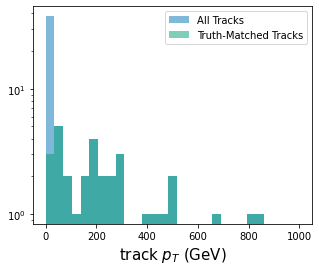

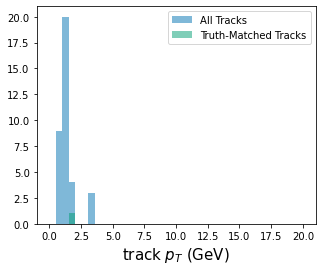

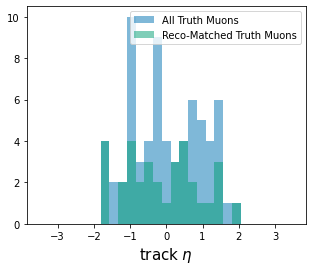

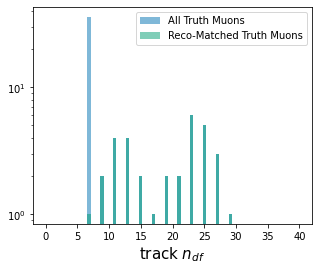

In [30]:
# Steps towards fake rate
matchedTracks = trks[matched]

arrays = [cleanTracks.pt,matchedTracks.pt]
legend = [ "All Tracks","Truth-Matched Tracks"]
compare1DHistograms(arrays, bins=np.linspace(0,1000,30), leg=legend, scale='log',label=";track $p_{T}$ (GeV)")
compare1DHistograms(arrays, bins=np.linspace(0,20,40), leg=legend, label=";track $p_{T}$ (GeV)")

arrays = [cleanTracks.eta,matchedTracks.eta]
legend = [ "All Truth Muons","Reco-Matched Truth Muons"]
compare1DHistograms(arrays, bins=np.linspace(-3.5,3.5,30), leg=legend, label=";track $\eta$")

arrays = [cleanTracks.ndf,matchedTracks.ndf]
legend = [ "All Truth Muons","Reco-Matched Truth Muons"]
compare1DHistograms(arrays, bins=np.linspace(0,40,80), leg=legend, scale='log', label=";track $n_{df}$")

### Isaac's Hit Detector

In [31]:
# Get the list of branches in the tree
for branch in treeB.keys():
    print(branch)

TightSelectedPandoraPFOs#0
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.index
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.collectionID
SiTracks#0
SiTracks#0/SiTracks#0.index
SiTracks#0/SiTracks#0.collectionID
SelectedPandoraPFOs#0
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.index
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.collectionID
LooseSelectedPandoraPFOs#0
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.index
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.collectionID
LE_SelectedPandoraPFOs#0
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.index
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.collectionID
LE_LooseSelectedPandoraPFOs#0
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.index
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.collectionID
MCPhysicsParticles#0
MCPhysicsParticles#0/MCPhysicsParticles#0.index
MCPhysicsParticles#0/MCPhysicsParticles#0.collectionID
YokeEndcapCollection
YokeEndcapCollection/YokeEndcap

In [32]:
#Setting up an akward array that contains data from each of the three layers of the tracker at the barrel and the endcaps
trackerHits = uproot.concatenate("/Users/isaac/Downloads/muonGun_reco_480.root:events",filter_name=["IBTr*","IETr*","VBTr*","VETr*","OETr*","OBTr*"])

In [33]:
print(type(trackerHits["VBTrackerHits.type"]))
for i in range(10):
    print((trackerHits["VBTrackerHits.type"][i]))

<class 'awkward.highlevel.Array'>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [34]:
print(len(trackerHits["VBTrackerHits.position.x"]))
for i in range(10):
    print(trackerHits["VBTrackerHits.position.x"][i])

10
[48.3, 48.1, 48.2, -87.5, -30.2, 48.6, ..., -8.14, -9.37, -6.71, 29, 28.6, 27.7]
[28.5, 30.5, 48.4, 50.4, 70, 72, 96.9, ..., -9.72, -6.72, 29, 28.3, 28.6, 27.7]
[48.3, 48.1, -87, -30.2, 48.6, -22.4, ..., -8.14, -9.37, -6.98, 29, 28.3, 28.6]
[-16.4, -17.5, 48.3, 48.1, 48.2, -87, ..., -9.37, -6.97, -9.71, 29, 28.3, 28.6]
[19.2, 20.5, 32.4, 33.7, 47, 48.3, ..., -6.96, -9.71, -6.72, 29, 28.3, 27.7]
[4.33, 4.41, 4.72, 7.37, 7.65, 10.5, ..., -9.38, -6.96, -6.71, 29, 28.6, 27.7]
[-28.5, -30.5, -48.7, -50.7, -70.5, -72.5, ..., 29, 28.3, 28.6, 27.7, 27.5]
[21.9, 23.4, 37.2, 38.7, 54.5, 56, ..., -9.37, -6.97, -9.78, 29, 28.3, 27.7]
[27.7, 29.6, 47, 48.9, 68.5, 70.4, ..., -9.37, -6.98, -9.72, 29, 28.6, 27.7]
[-30.2, -32.2, -51.9, -54, -74.6, -76.7, ..., -8.13, -9.38, 29, 28.3, 28.6]


In [35]:
print(len(trackerHits["VBTrackerHits.position.y"]))
for i in range(10):
    print(trackerHits["VBTrackerHits.position.y"][i])

10
[-17.3, -17.8, -17.5, 52.7, -1.93, 21.7, ..., 31, 32.2, -8.84, -9.83, -11.9]
[9.99, 10.7, 17, 17.7, 24.5, 25.2, ..., 30.8, 32.2, -8.83, -10.4, -9.82, -11.9]
[-17.3, -17.8, 53.6, -1.93, 21.7, -23.2, ..., 31, 32.2, -8.83, -10.4, -9.83]
[-26.2, -28, -17.3, -17.8, -17.5, 53.6, ..., 32.2, 30.8, -8.83, -10.4, -9.82]
[-23.5, -25.1, -39.6, -41.2, -57.4, -59, ..., 30.8, 32.2, -8.82, -10.4, -11.9]
[30.2, 30.8, 32.9, 51.4, 53.5, 73.6, ..., 31, 32.2, 32.2, -8.83, -9.82, -11.9]
[9.9, 10.6, 16.9, 17.6, 24.5, 25.1, ..., -8.83, -10.4, -9.82, -11.9, -12.4]
[20.8, 22.2, 35.3, 36.8, 51.8, 53.2, ..., 31, 32.2, 30.8, -8.83, -10.4, -11.9]
[-11.9, -12.7, -20.2, -21, -29.5, -30.3, ..., 32.2, 30.8, -8.83, -9.81, -11.9]
[1.04, 1.11, 1.79, 1.86, 2.58, 2.63, ..., 30.2, 30.2, 31, -8.84, -10.4, -9.82]


In [36]:
print(len(trackerHits["VBTrackerHits.time"]))
for i in range(10):
    print(trackerHits["VBTrackerHits.time"][i])

10
[-0.0267, -0.0211, -0.0501, -0.0799, ..., -0.0756, -0.0411, -0.0352, -0.0425]
[0.0195, 0.0448, -0.0249, 0.0184, ..., -0.0422, -0.0895, -0.0373, -0.0469]
[-0.0363, -0.0323, -0.0812, -0.0235, ..., -0.0526, -0.0373, -0.0692, -0.042]
[0.0207, 0.0317, -0.0277, -0.0529, ..., -0.0544, -0.0868, -0.0157, -0.084]
[0.0367, -0.0211, 0.0236, 0.000405, ..., -0.0621, -0.0767, -0.0622, -0.0488]
[0.0343, 0.0454, -0.0175, 0.0026, ..., -0.0526, -0.0721, -0.0882, -0.0364]
[0.0248, 0.0347, 0.0315, 0.0334, ..., -0.0753, -0.0584, -0.056, -0.0698]
[-0.0297, -0.0151, 0.0512, -0.0261, ..., -0.0837, -0.0177, -0.0567, -0.0866]
[0.0221, -0.0337, 0.0237, -0.039, ..., -0.0717, -0.0442, -0.064, -0.0668]
[-0.0186, 0.0355, 0.0361, 0.0265, ..., -0.0535, -0.0696, -0.0738, -0.0874]


In [37]:
print(len(trackerHits["VBTrackerHits.position.z"]))
for i in range(10):
    print(trackerHits["VBTrackerHits.position.z"][i])

10
[18.9, 18.6, 17.8, 54.9, -55.8, -65, ..., -18.4, -15.4, -1.93, -0.795, 2.86]
[5.11, 5.47, 8.7, 9.05, 12.6, 12.9, ..., -15.3, -1.93, -0.894, -0.782, 0.43]
[18.9, 18.6, 56.3, -55.7, -65, -8.73, ..., -18.4, -15.5, -1.93, -0.9, -0.792]
[-45.3, -48.4, 18.9, 18.6, 17.8, 56.3, ..., -15.5, -14.5, -1.93, -0.903, -0.794]
[15.8, 16.9, 26.7, 27.8, 38.7, 39.8, ..., -14.5, -15.4, -1.92, -0.901, 0.431]
[-14.6, -14.9, -15.9, -24.9, -25.9, ..., -15.5, -15.4, -1.94, -0.803, 0.437]
[-20.1, -21.5, -34.4, -35.7, -49.7, ..., -1.92, -0.906, -0.794, 0.438, 3.19]
[19.6, 21, 33.4, 34.7, 48.9, 50.2, ..., -15.5, -16.9, -1.93, -0.906, 0.435]
[10.2, 10.9, 17.3, 18, 25.3, 26, ..., -18.4, -15.5, -14.5, -1.94, -0.803, 0.43]
[25.1, 26.9, 43.3, 45, 62.2, 63.9, ..., -19.1, -18.4, -1.93, -0.905, -0.796]


In [38]:
print(len(trackerHits["VETrackerHits.rawHits_begin"]))
for i in range(10):
    nonZ=trackerHits["VETrackerHits.rawHits_begin"][i]!=0
    print(trackerHits["VETrackerHits.rawHits_begin"][i][nonZ])

10
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [39]:
print(len(trackerHits["VETrackerHits.rawHits_end"]))
for i in range(10):
    nonZ=trackerHits["VETrackerHits.rawHits_end"][i]!=0
    print(trackerHits["VETrackerHits.rawHits_end"][i][nonZ])

10
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [40]:
#Zipping together the position data from each of the tracker layers
locHits=ak.zip({
    "IBX": trackerHits["IBTrackerHits.position.x"],
    "IBY": trackerHits["IBTrackerHits.position.y"],
    "IBZ": trackerHits["IBTrackerHits.position.z"],
    
    "IEX": trackerHits["IETrackerHits.position.x"],
    "IEY": trackerHits["IETrackerHits.position.y"],
    "IEZ": trackerHits["IETrackerHits.position.z"],
    
    
    "VBX": trackerHits["VBTrackerHits.position.x"],
    "VBY": trackerHits["VBTrackerHits.position.y"],
    "VBZ": trackerHits["VBTrackerHits.position.z"],
    
    "VEX": trackerHits["VETrackerHits.position.x"],
    "VEY": trackerHits["VETrackerHits.position.y"],
    "VEZ": trackerHits["VETrackerHits.position.z"],
    
    
    "OBX": trackerHits["OBTrackerHits.position.x"],
    "OBY": trackerHits["OBTrackerHits.position.y"],
    "OBZ": trackerHits["OBTrackerHits.position.z"],
    
    "OEX": trackerHits["OETrackerHits.position.x"],
    "OEY": trackerHits["OETrackerHits.position.y"],
    "OEZ": trackerHits["OETrackerHits.position.z"]
    }, depth_limit=1)

In [41]:
print(locHits.IEX[6])

[305, -205, -225, -225, -47.1, 393, 456, ..., -123, -166, -167, 161, -188, 185]


In [42]:
def plot(y, bins=50, xlabel="", ylabel="", title=""):
  max=np.percentile(y,99.5)
  min=np.percentile(y, 0.5)
  bins=np.linspace(min, max, bins)
  fig = plt.figure(figsize=(15,10))
  ax = plt.gca()
  ax.set_prop_cycle(color=['#002BFF','#A15FFF','#FF0061','#FF8913'])
  ax.set_xlabel(xlabel,fontsize=26,labelpad=6)
  ax.set_ylabel(ylabel,fontsize=26)
  ax.tick_params(labelsize=18, direction='out', length=8, width=2)
  ax.yaxis.offsetText.set_fontsize(18)
  ax.xaxis.labelpad = 15
  ax.yaxis.labelpad = 15
  ax.tick_params(axis='both', which='major', labelsize=25)
  ax.set_title(title,fontsize=26)
  ax.hist(y, bins)

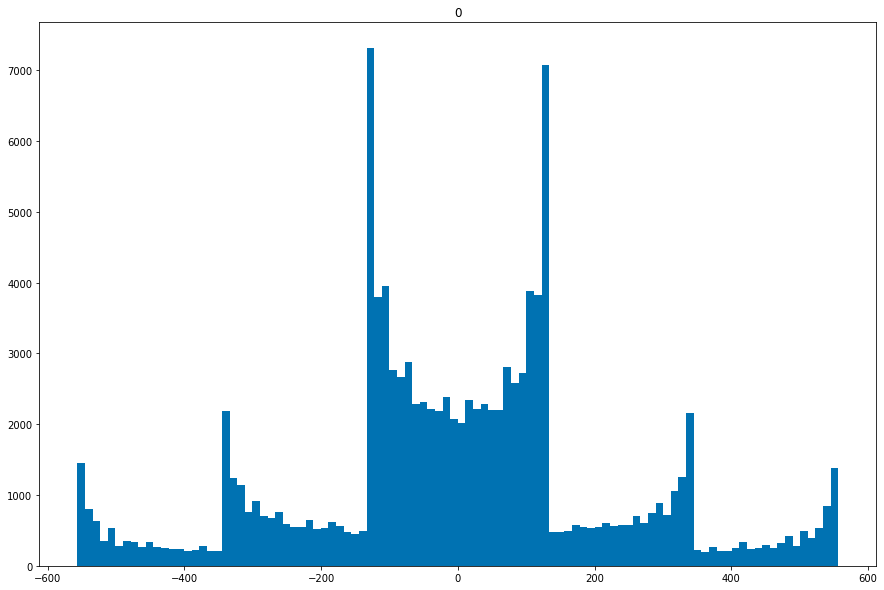

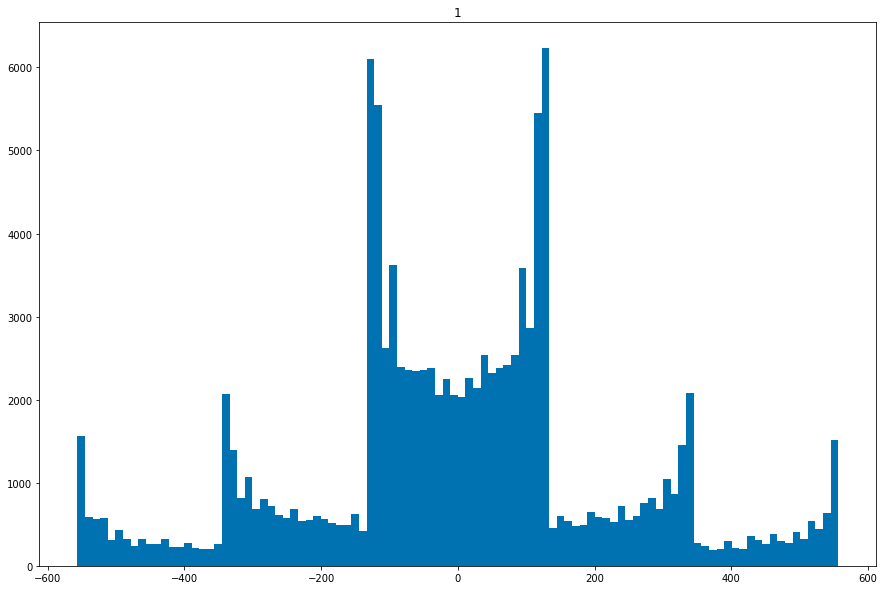

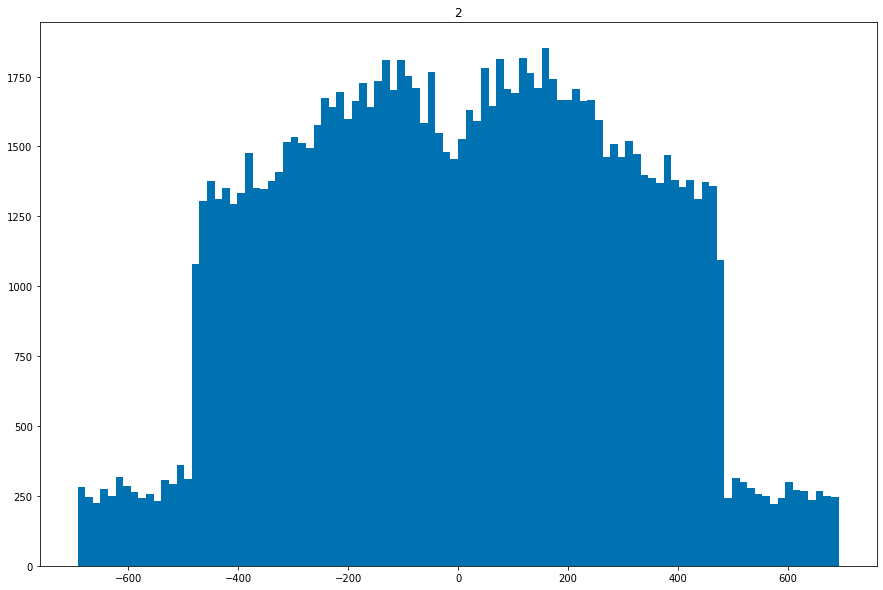

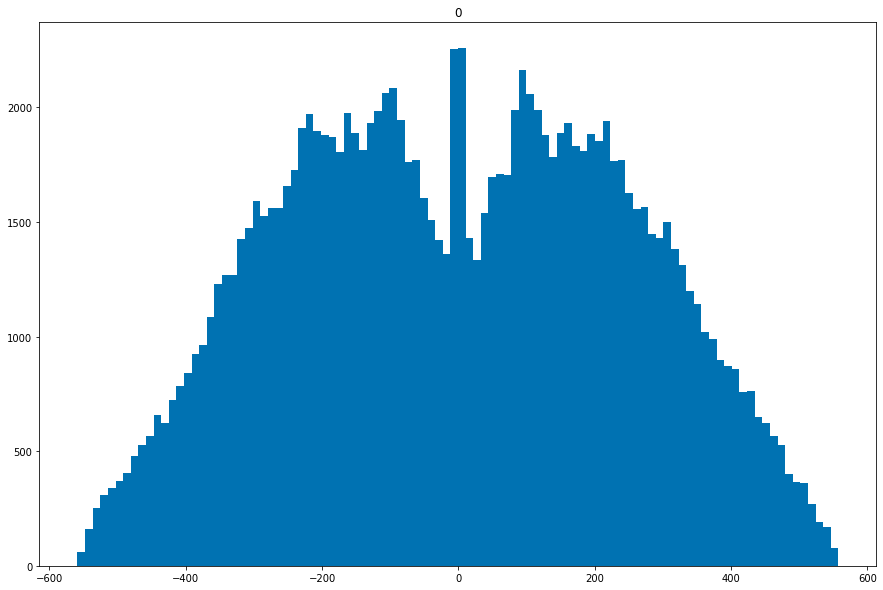

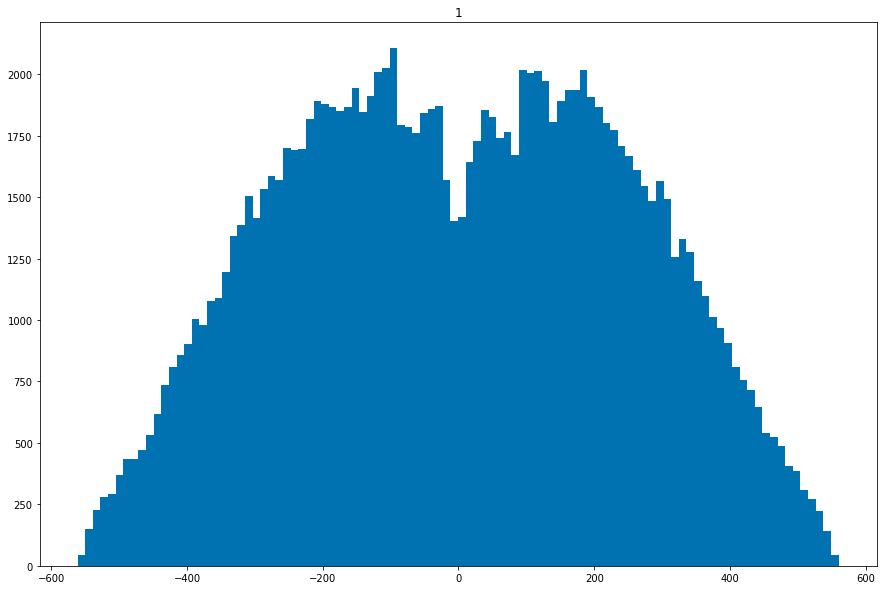

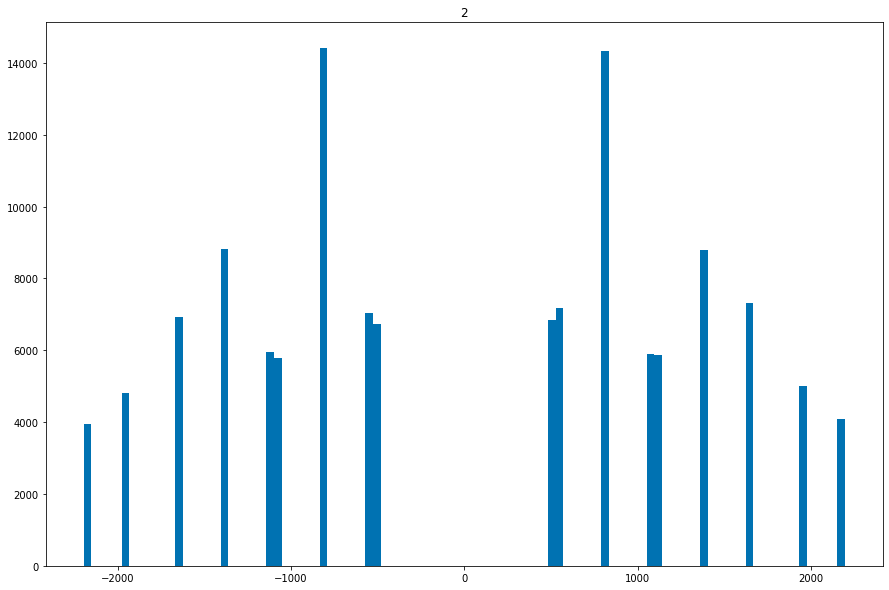

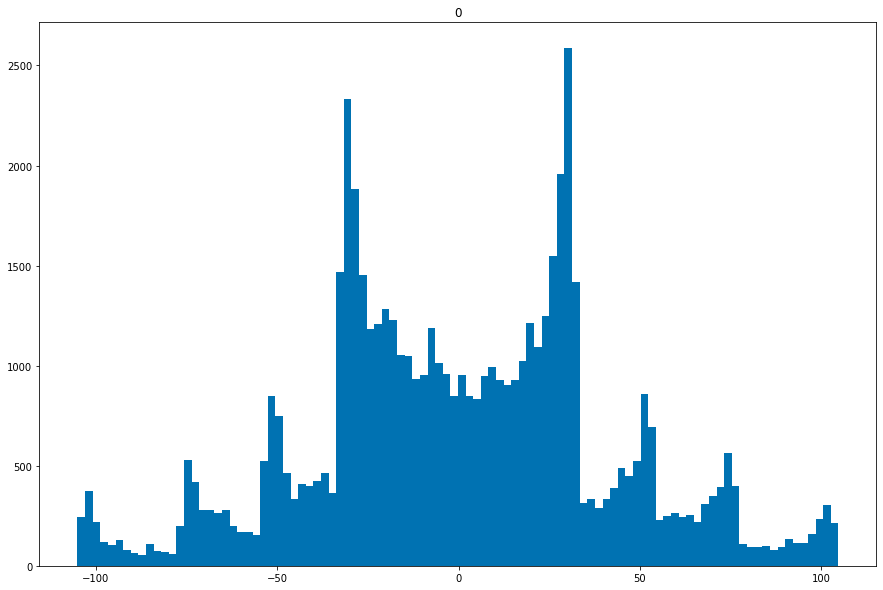

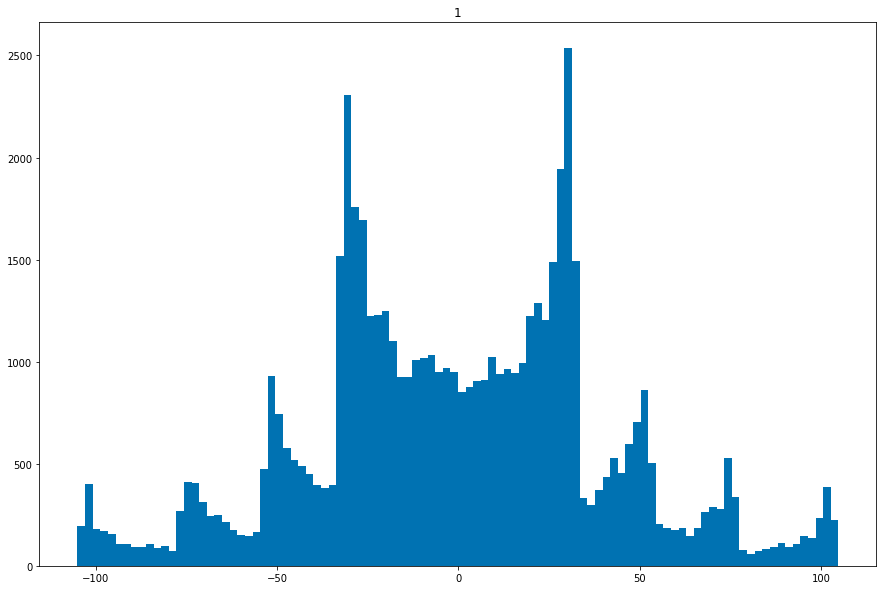

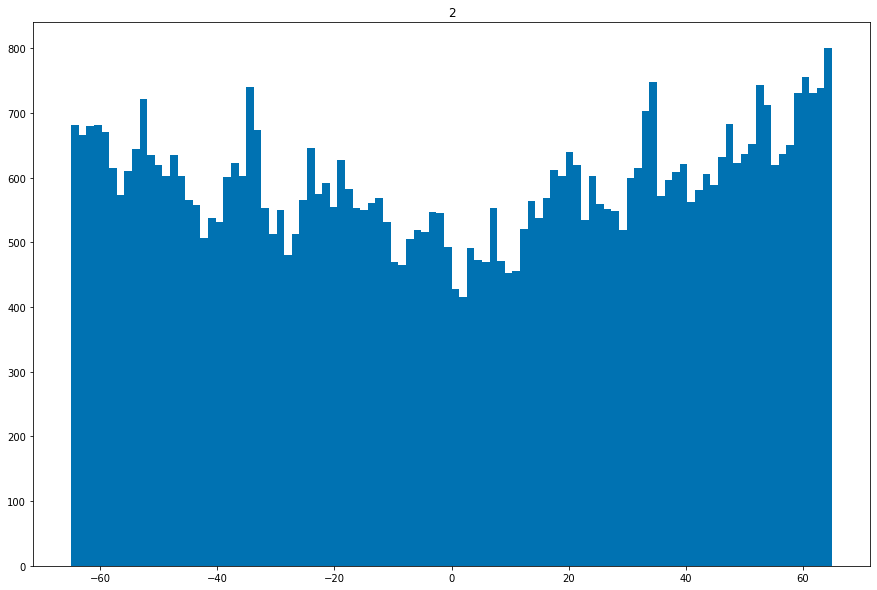

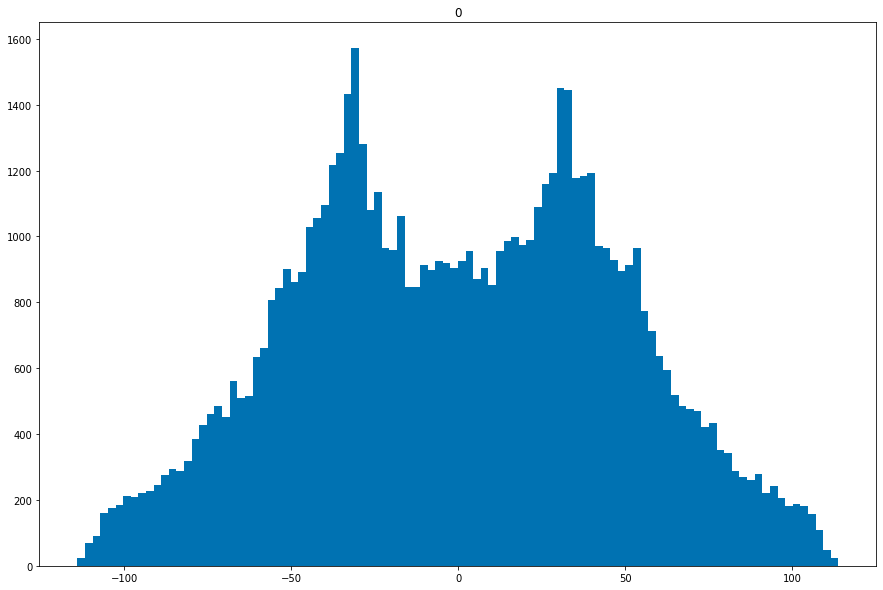

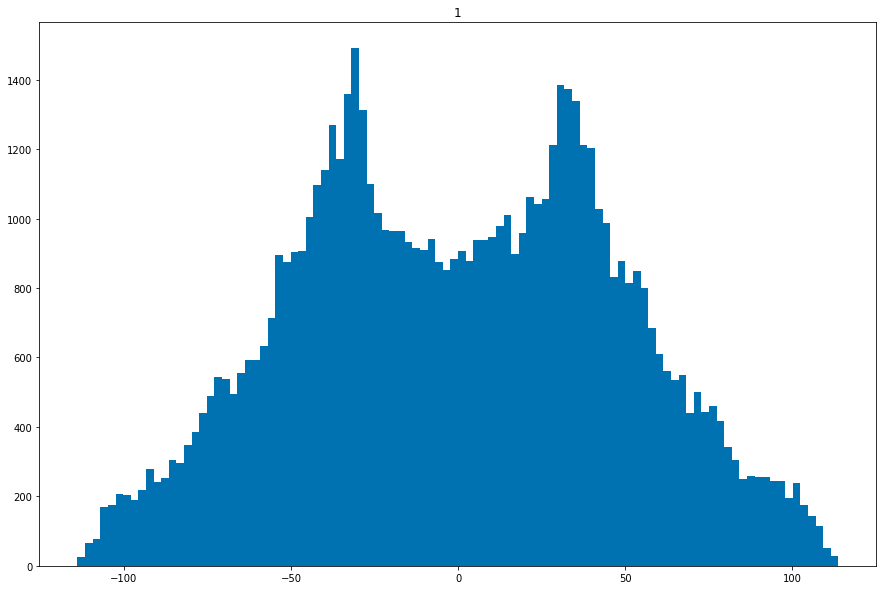

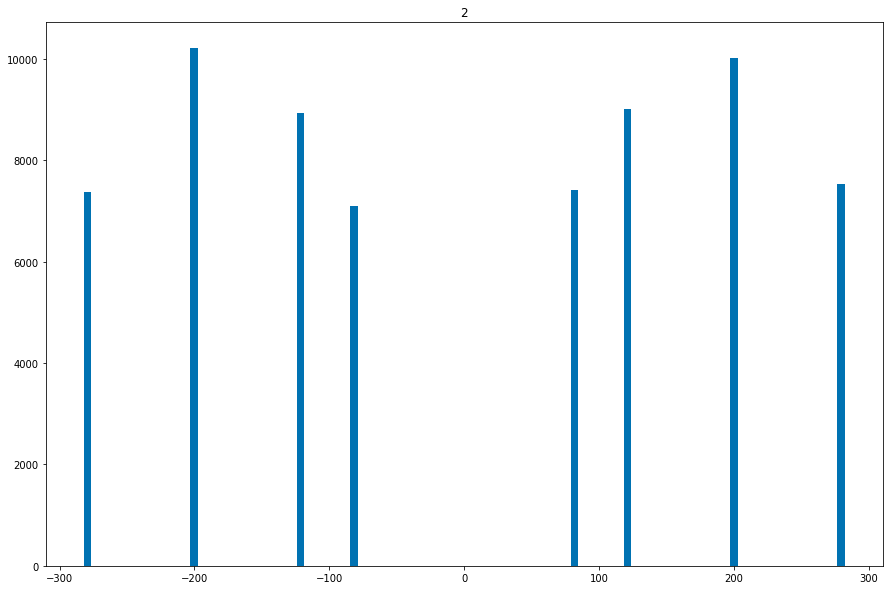

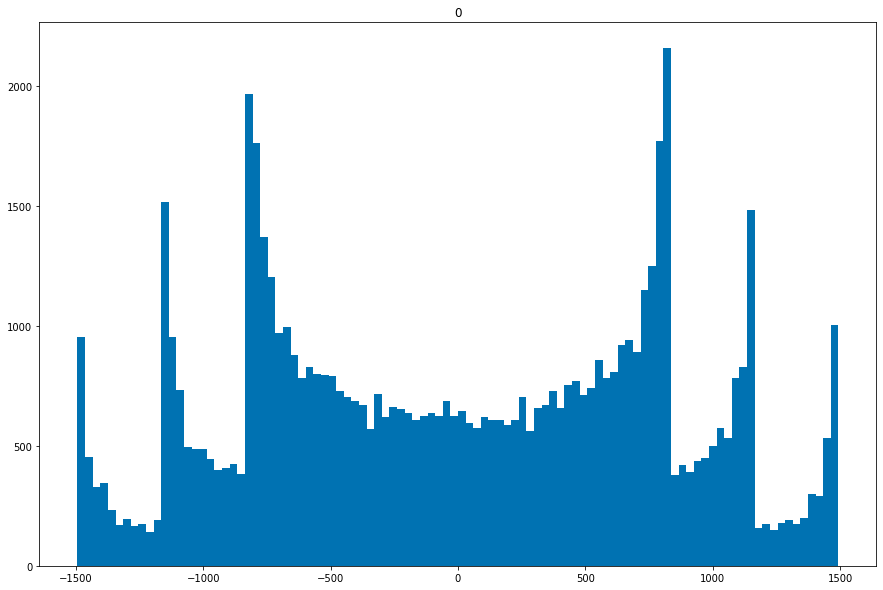

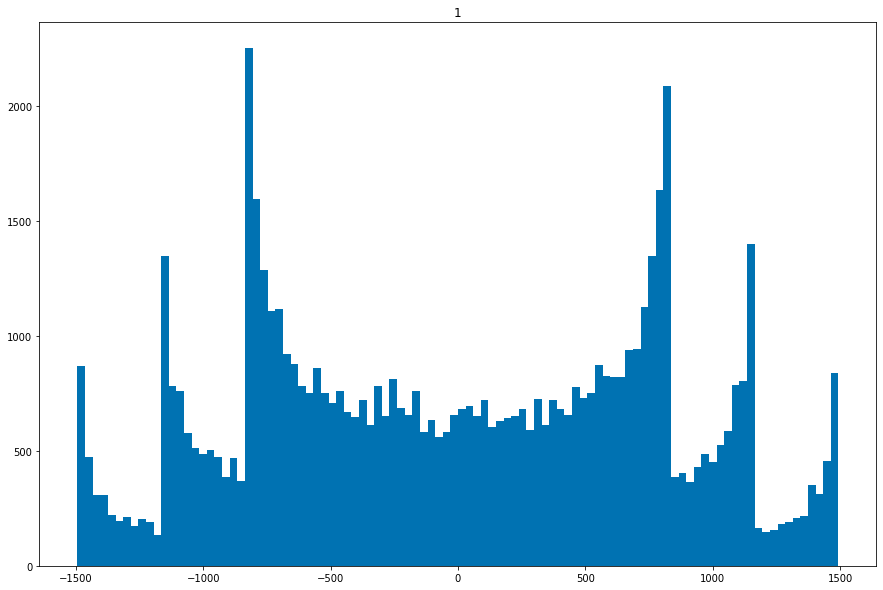

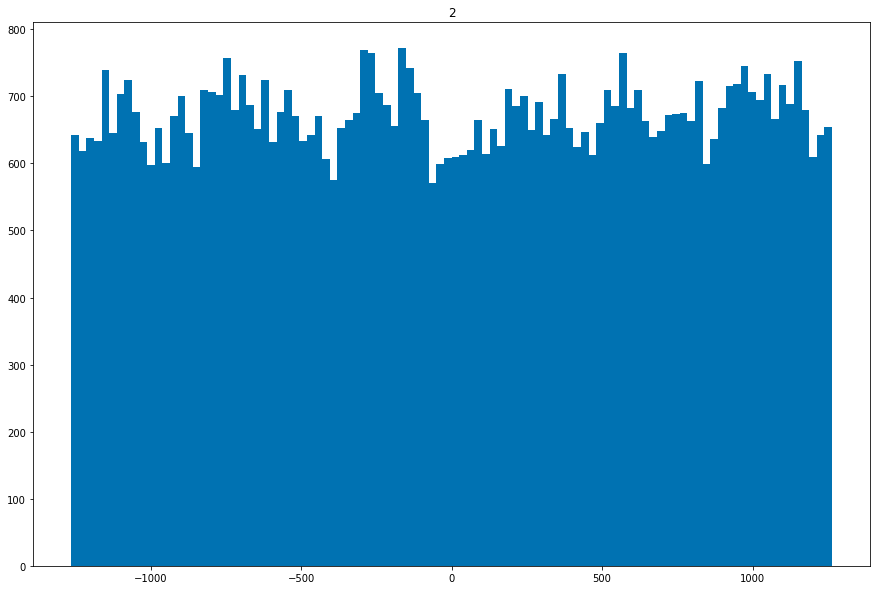

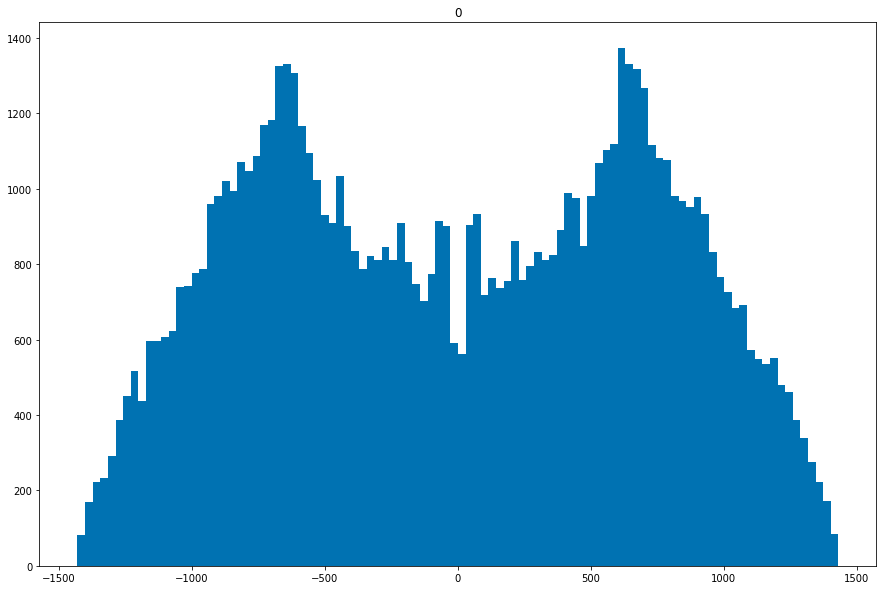

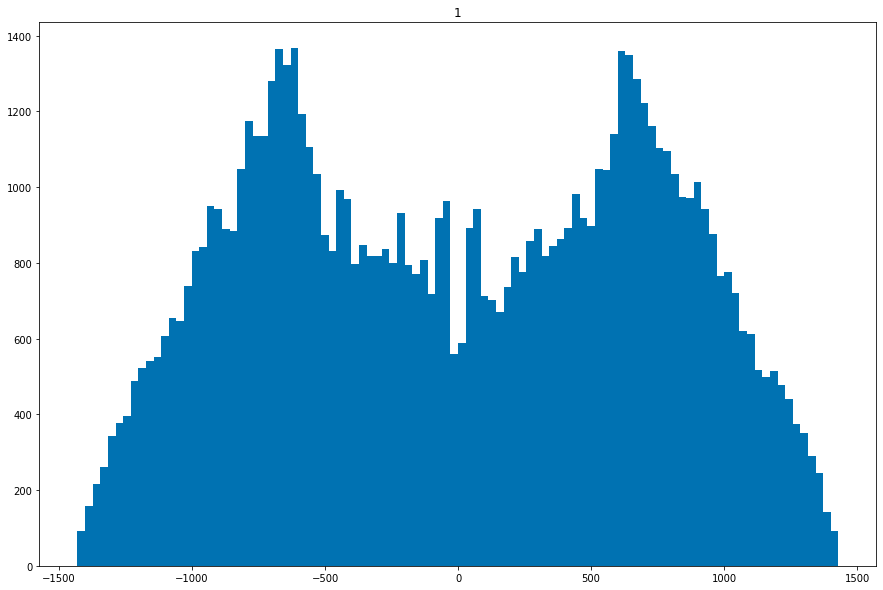

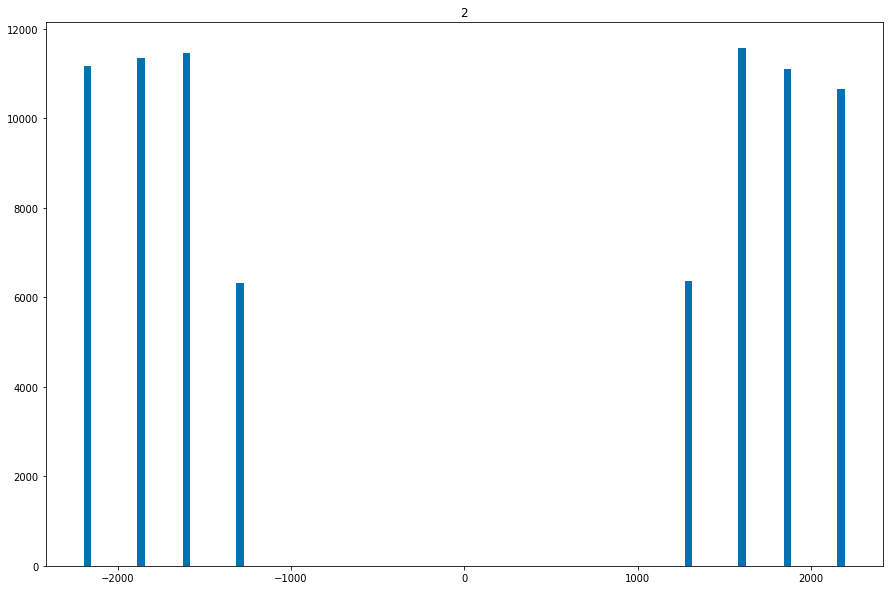

In [43]:
j=0
for i in [locHits.IBX,locHits.IBY,locHits.IBZ,locHits.IEX,locHits.IEY,locHits.IEZ,locHits.VBX,locHits.VBY,locHits.VBZ,locHits.VEX,locHits.VEY,locHits.VEZ,locHits.OBX,locHits.OBY,locHits.OBZ,locHits.OEX,locHits.OEY,locHits.OEZ]:
    plot1DHistogram(i[0], bins=100, label=str(j % 3))
    j+=1

In [44]:
print(min(np.abs(ak.to_numpy(ak.flatten(locHits.VEZ)))))

80.13999999999999


In [45]:
def hist2d(y1,y2, axis1="", axis2="", title="", savefig=False):
    max1=max(y1)
    min1=min(y1)
    max2=max(y2)
    min2=min(y2)
    bins1=np.linspace(min1, max1, 500)
    bins2=np.linspace(min2, max2, 500)
    fig = plt.figure(figsize=(30,20))
    ax = plt.gca()
    ax.set_prop_cycle(color=['#002BFF','#A15FFF','#FF0061','#FF8913'])
    ax.set_xlabel(axis1,fontsize=26,labelpad=6)
    ax.set_ylabel(axis2,fontsize=26)
    ax.tick_params(labelsize=18, direction='out', length=8, width=2)
    #ax.yaxis.offsetText.set_fontsize(18)
    #ax.xaxis.labelpad = 15
    #ax.yaxis.labelpad = 15
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.set_title(title,fontsize=26)
    res=ax.hist2d(y1, y2, (bins1, bins2))
    #help(fig.colorbar)
    cb = fig.colorbar(res[3], ax=ax)
    cb.set_label(label="Hits", fontsize=26)
    if savefig:
        plt.savefig(title + ".pdf", dpi=300)

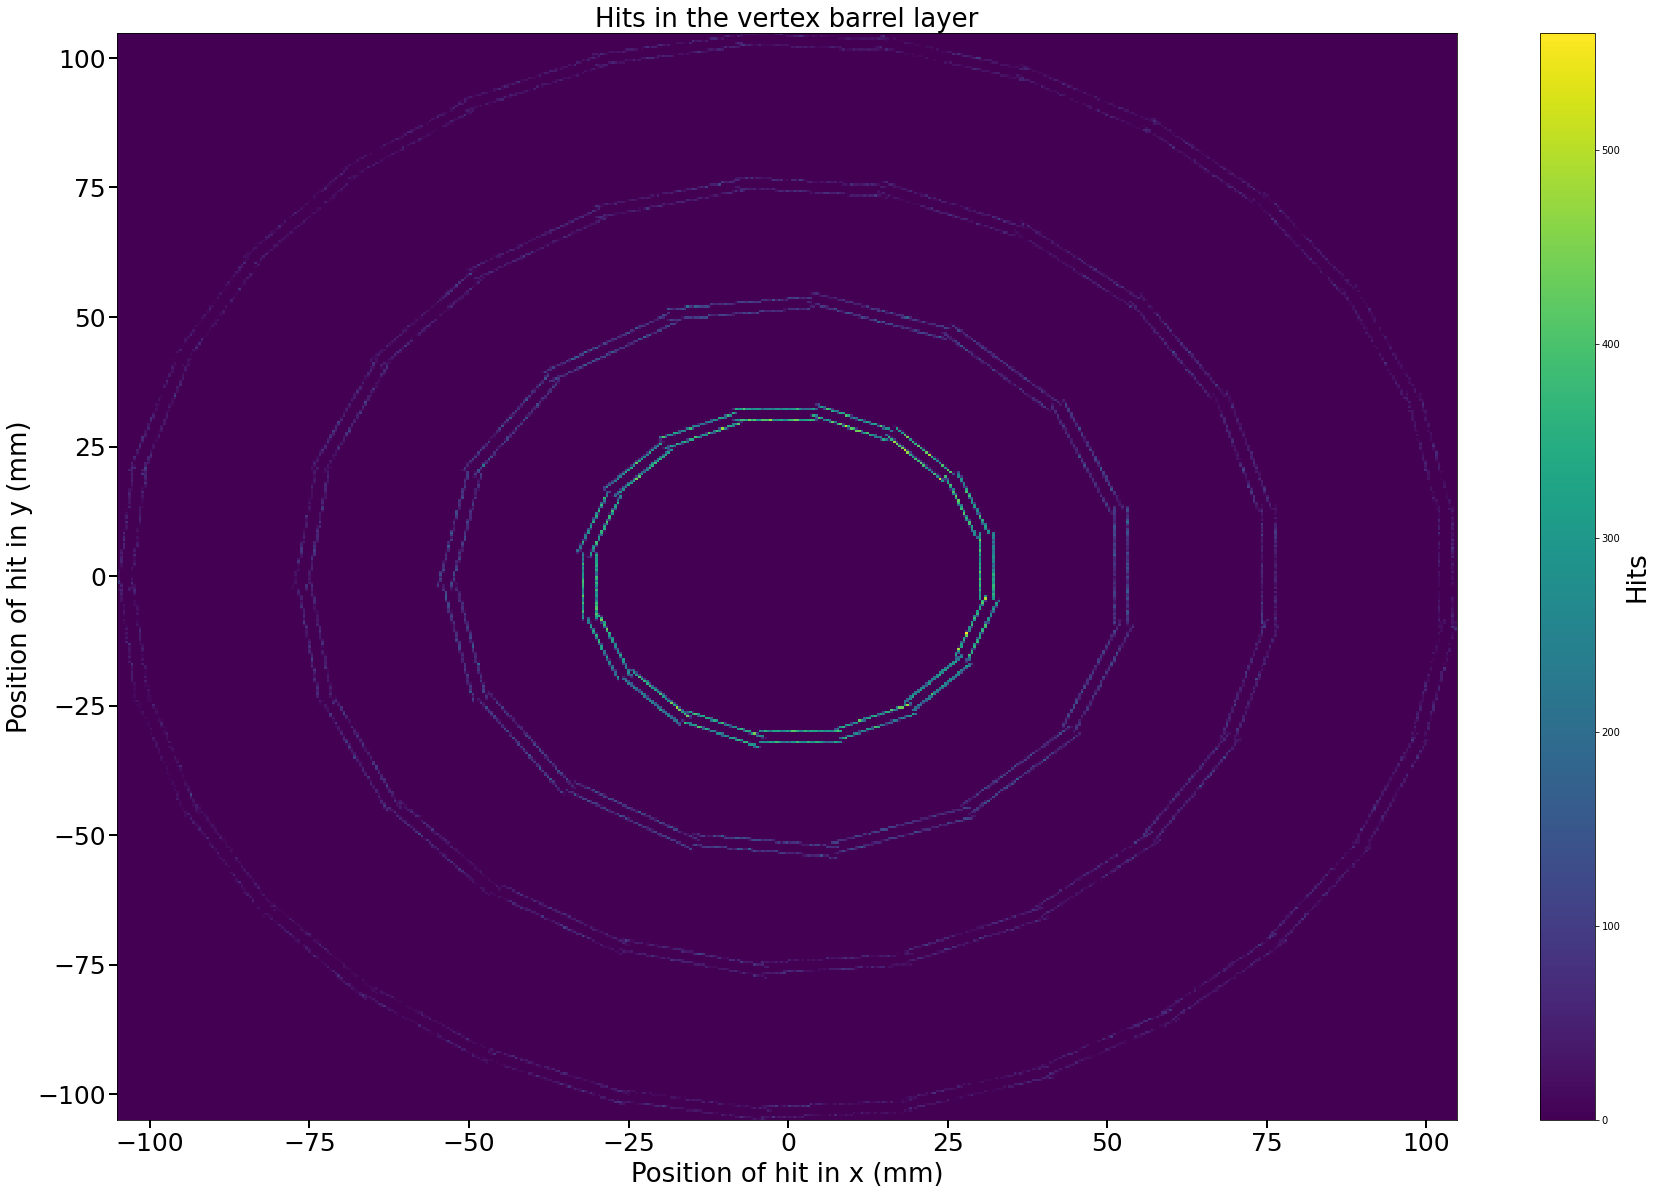

In [46]:
hist2d(ak.to_numpy(ak.concatenate(locHits.VBX)),ak.to_numpy(ak.concatenate(locHits.VBY)), axis1="Position of hit in x (mm)",axis2="Position of hit in y (mm)",title="Hits in the vertex barrel layer")

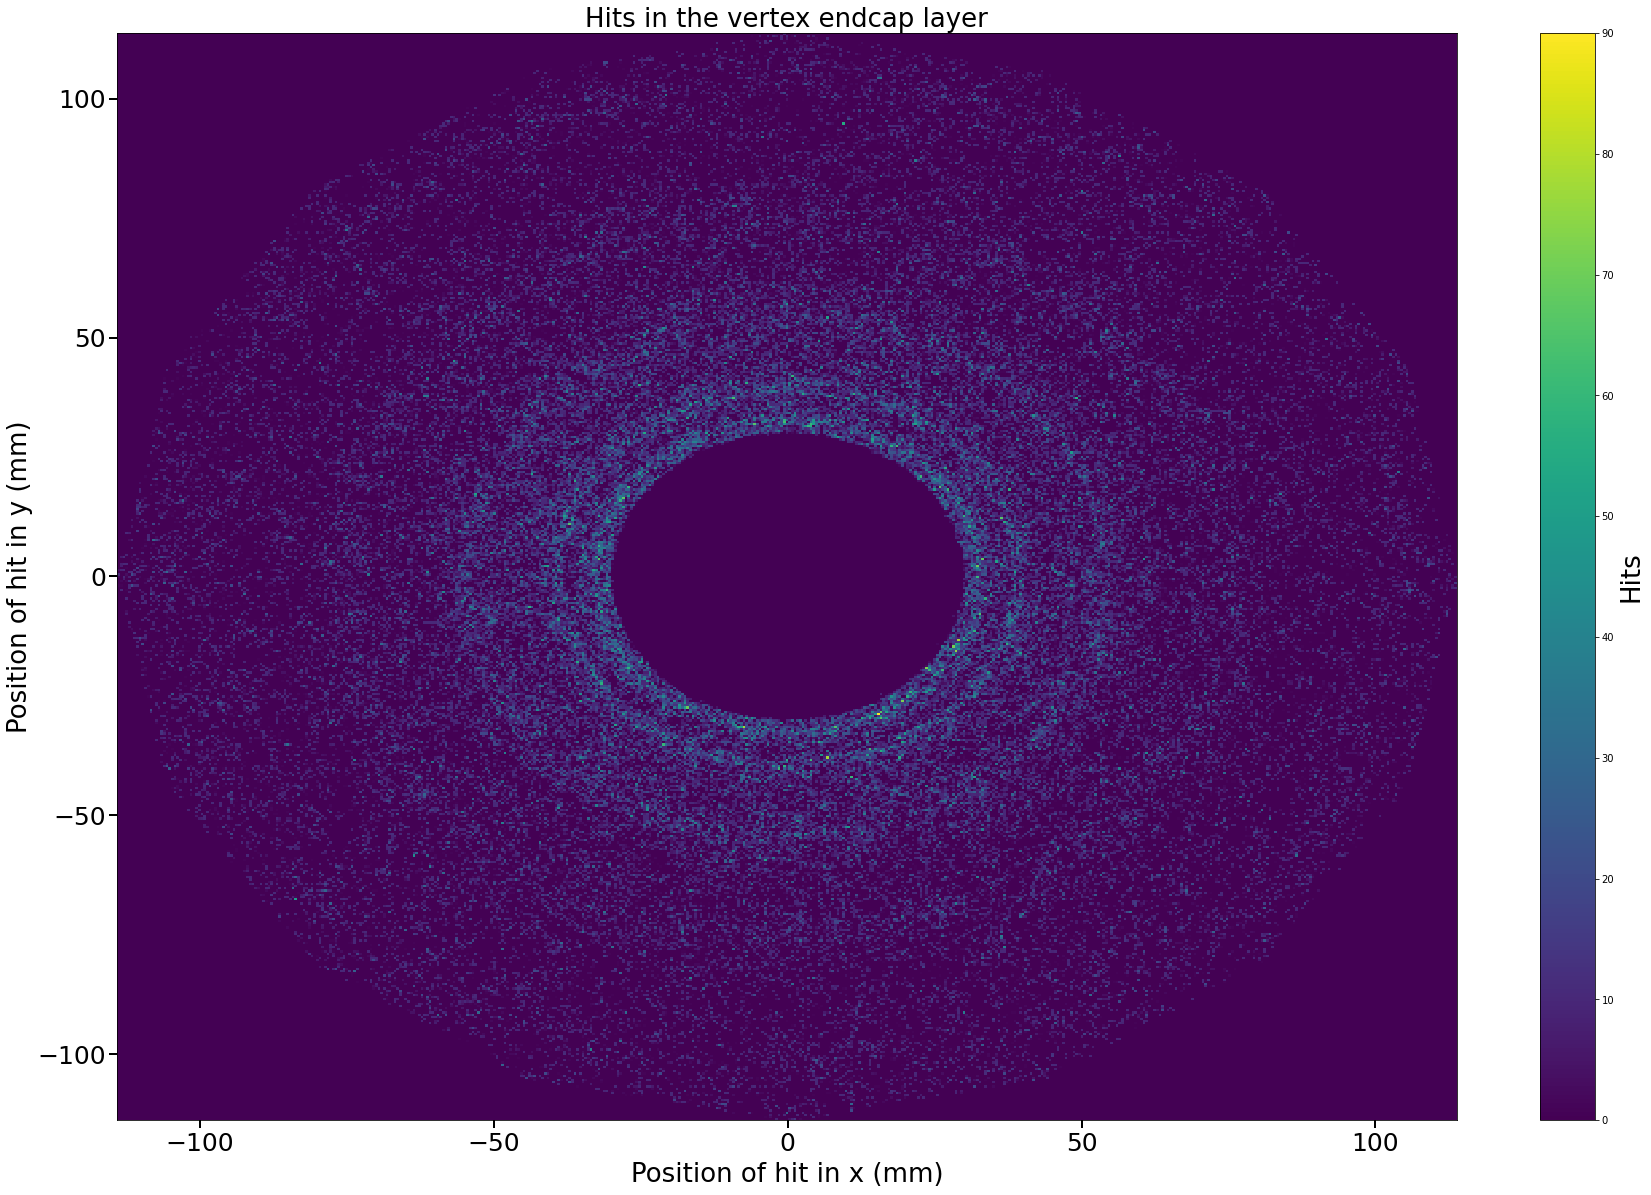

In [47]:
hist2d(ak.to_numpy(ak.concatenate(locHits.VEX)),ak.to_numpy(ak.concatenate(locHits.VEY)), axis1="Position of hit in x (mm)",axis2="Position of hit in y (mm)",title="Hits in the vertex endcap layer")

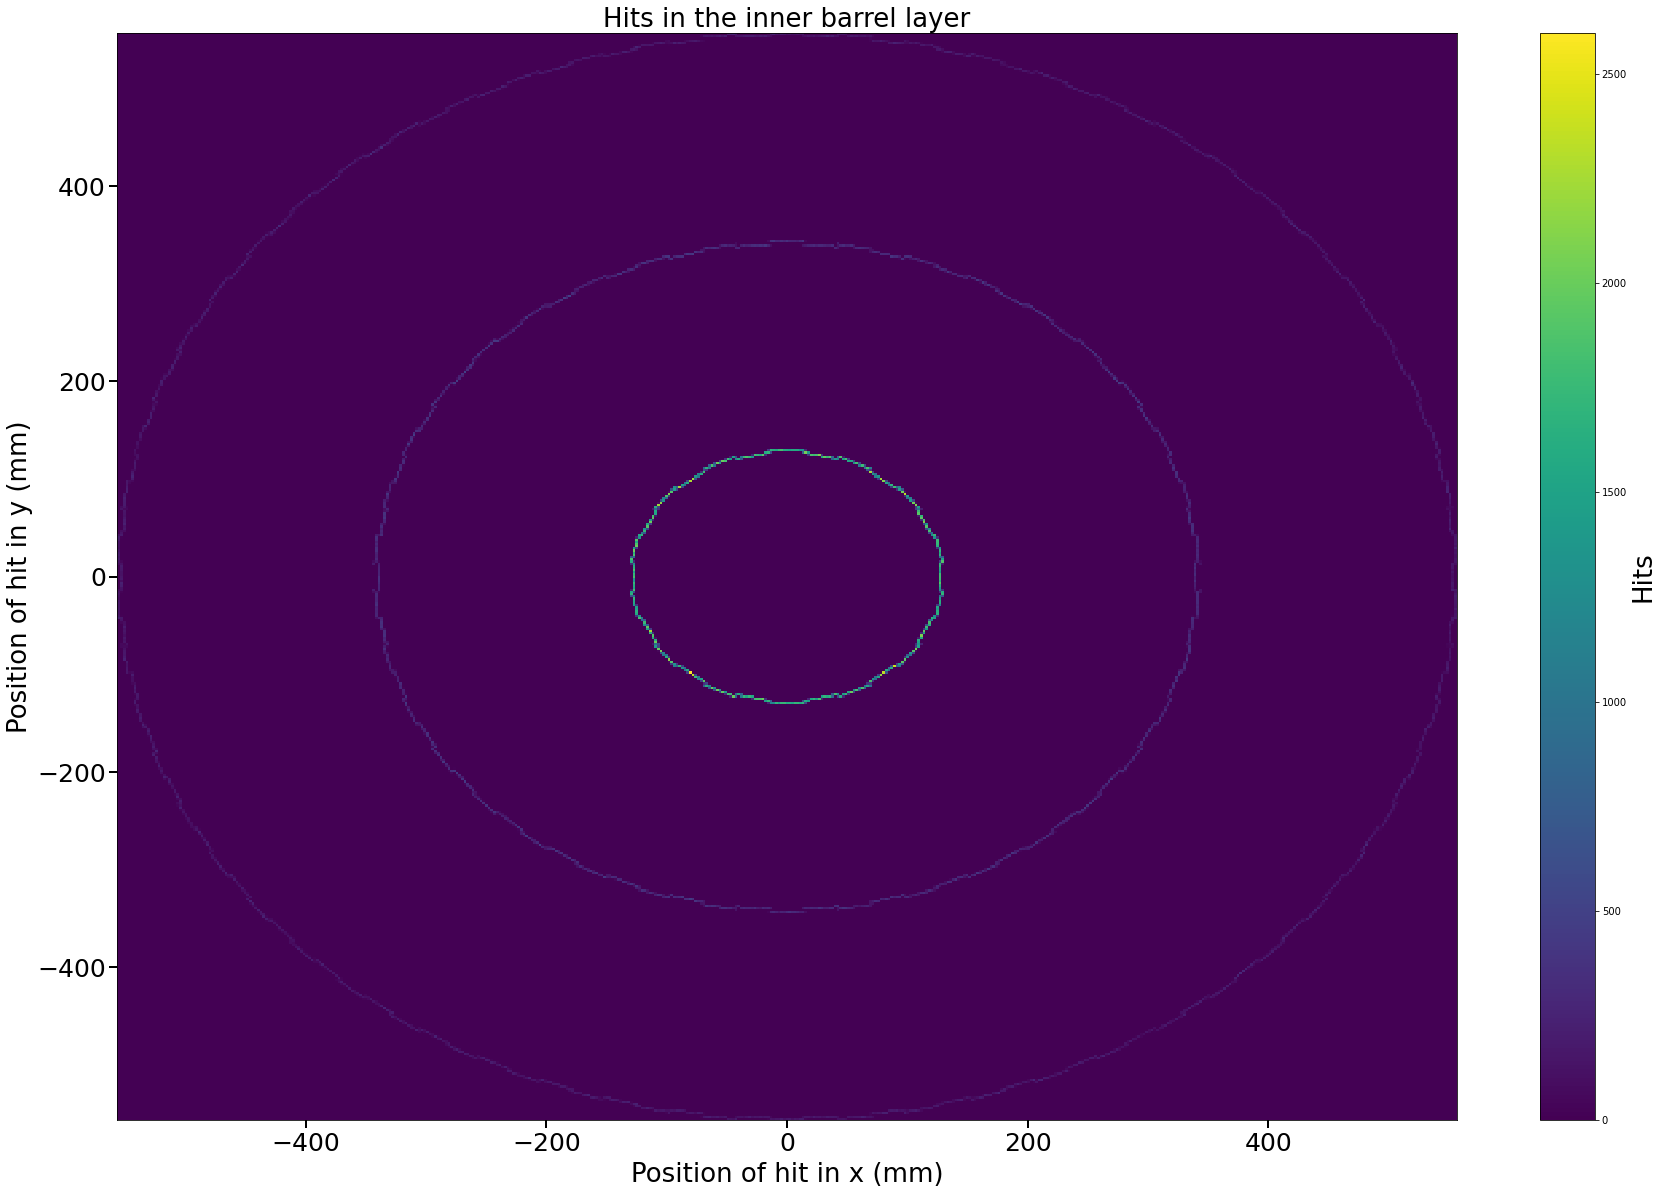

In [48]:
hist2d(ak.to_numpy(ak.concatenate(locHits.IBX)),ak.to_numpy(ak.concatenate(locHits.IBY)), axis1="Position of hit in x (mm)",axis2="Position of hit in y (mm)",title="Hits in the inner barrel layer")

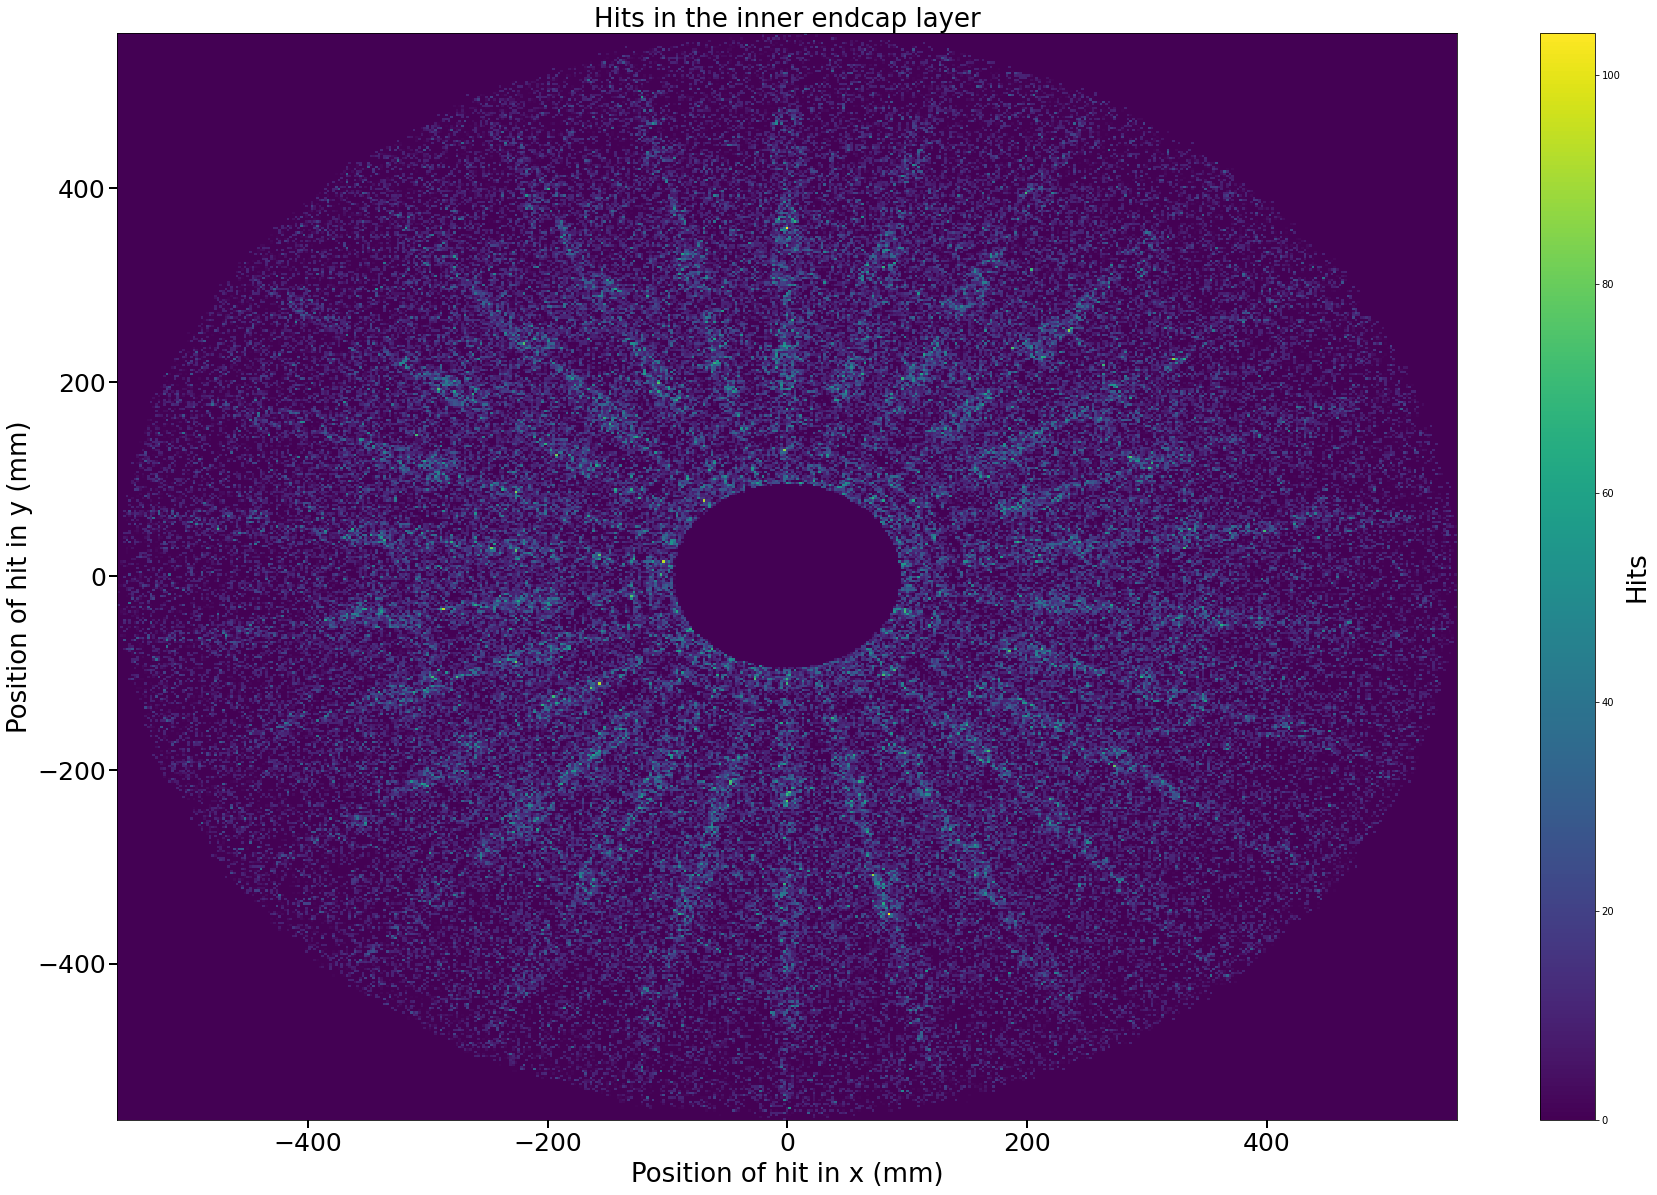

In [49]:
hist2d(ak.to_numpy(ak.concatenate(locHits.IEX)),ak.to_numpy(ak.concatenate(locHits.IEY)), axis1="Position of hit in x (mm)",axis2="Position of hit in y (mm)",title="Hits in the inner endcap layer")

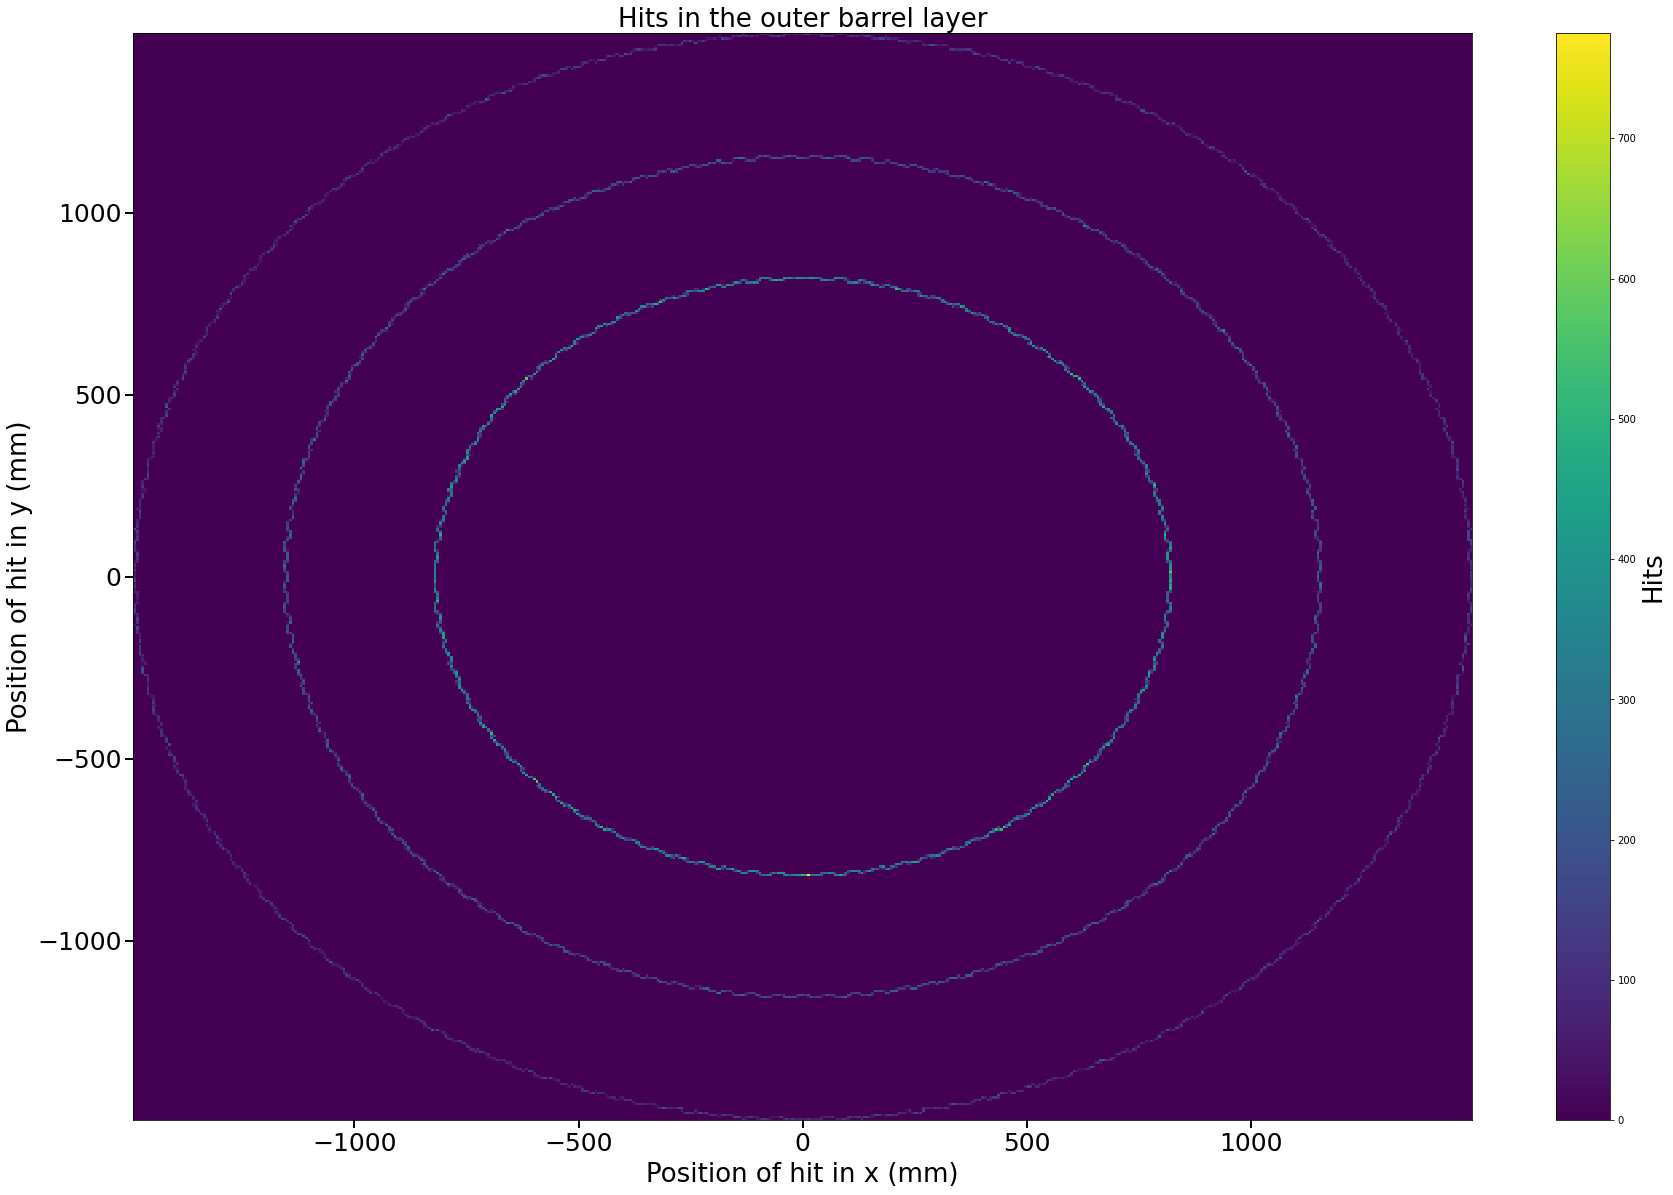

In [50]:
hist2d(ak.to_numpy(ak.concatenate(locHits.OBX)),ak.to_numpy(ak.concatenate(locHits.OBY)), axis1="Position of hit in x (mm)",axis2="Position of hit in y (mm)",title="Hits in the outer barrel layer")

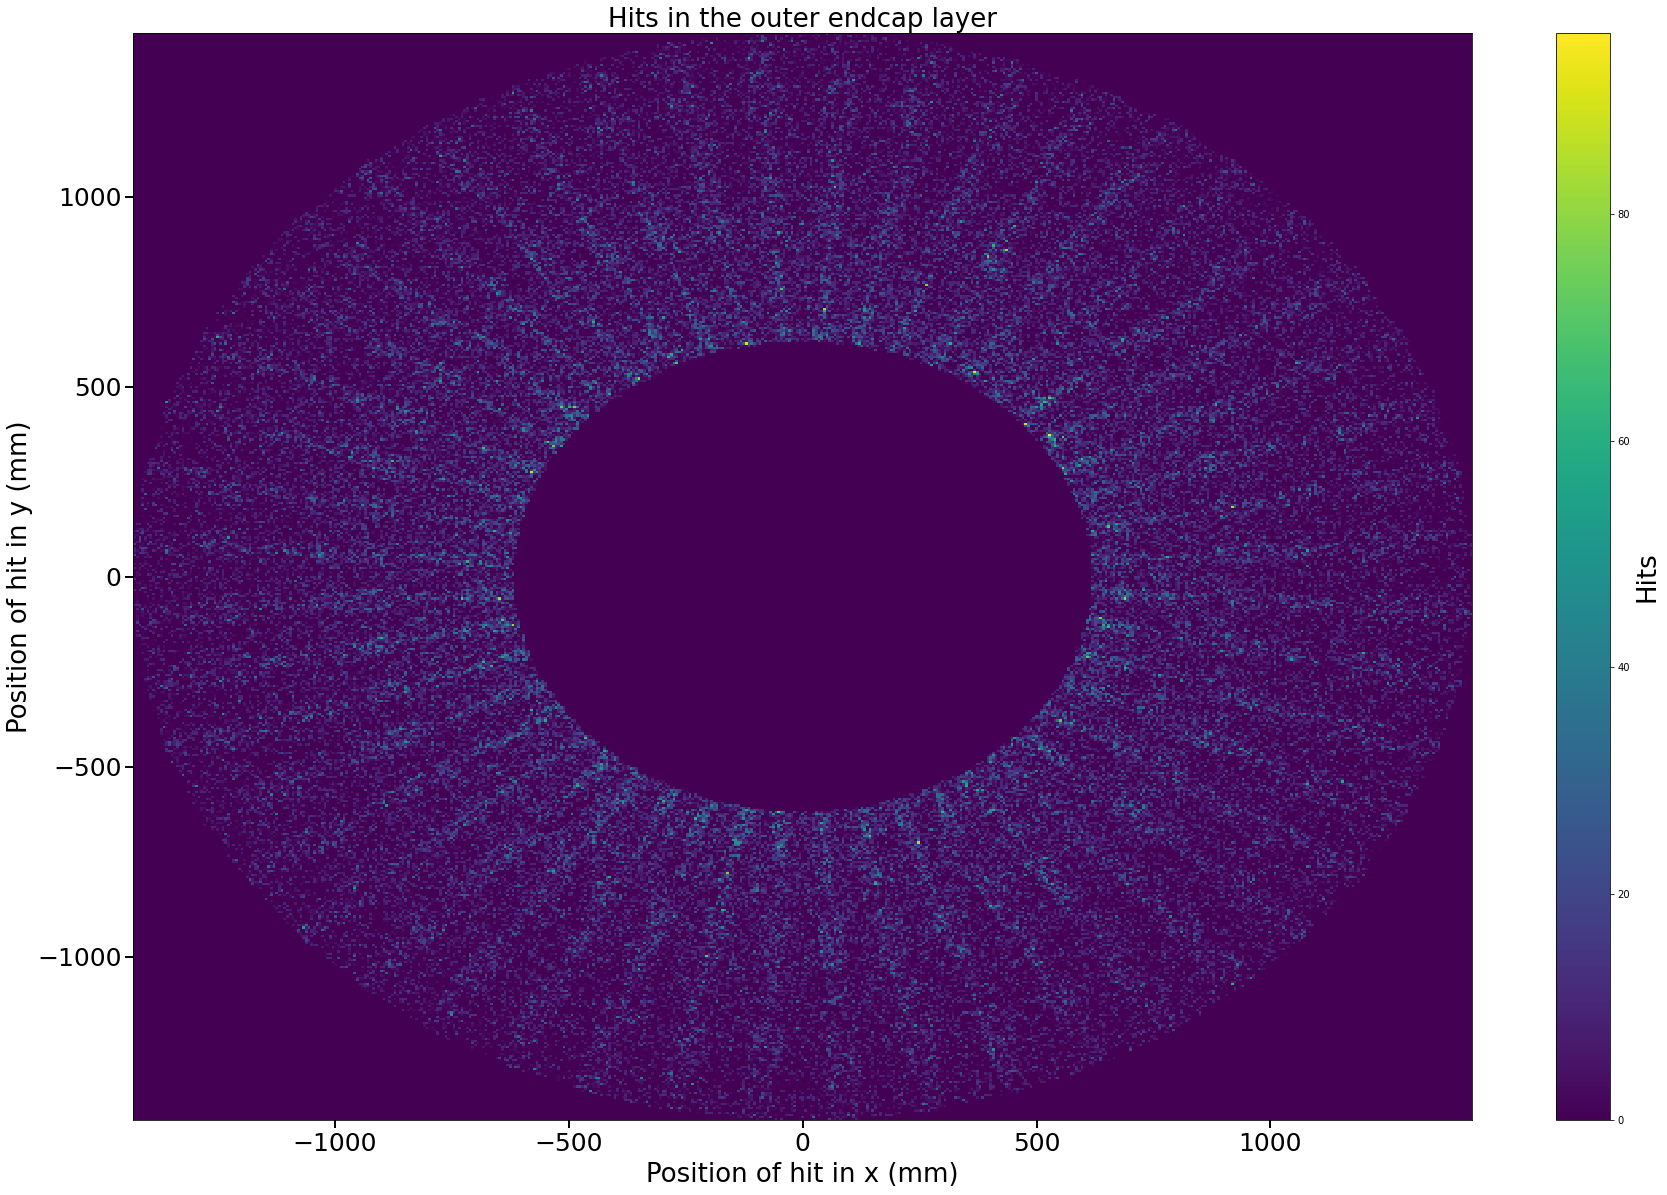

In [51]:
hist2d(ak.to_numpy(ak.concatenate(locHits.OEX)),ak.to_numpy(ak.concatenate(locHits.OEY)), axis1="Position of hit in x (mm)",axis2="Position of hit in y (mm)",title="Hits in the outer endcap layer")

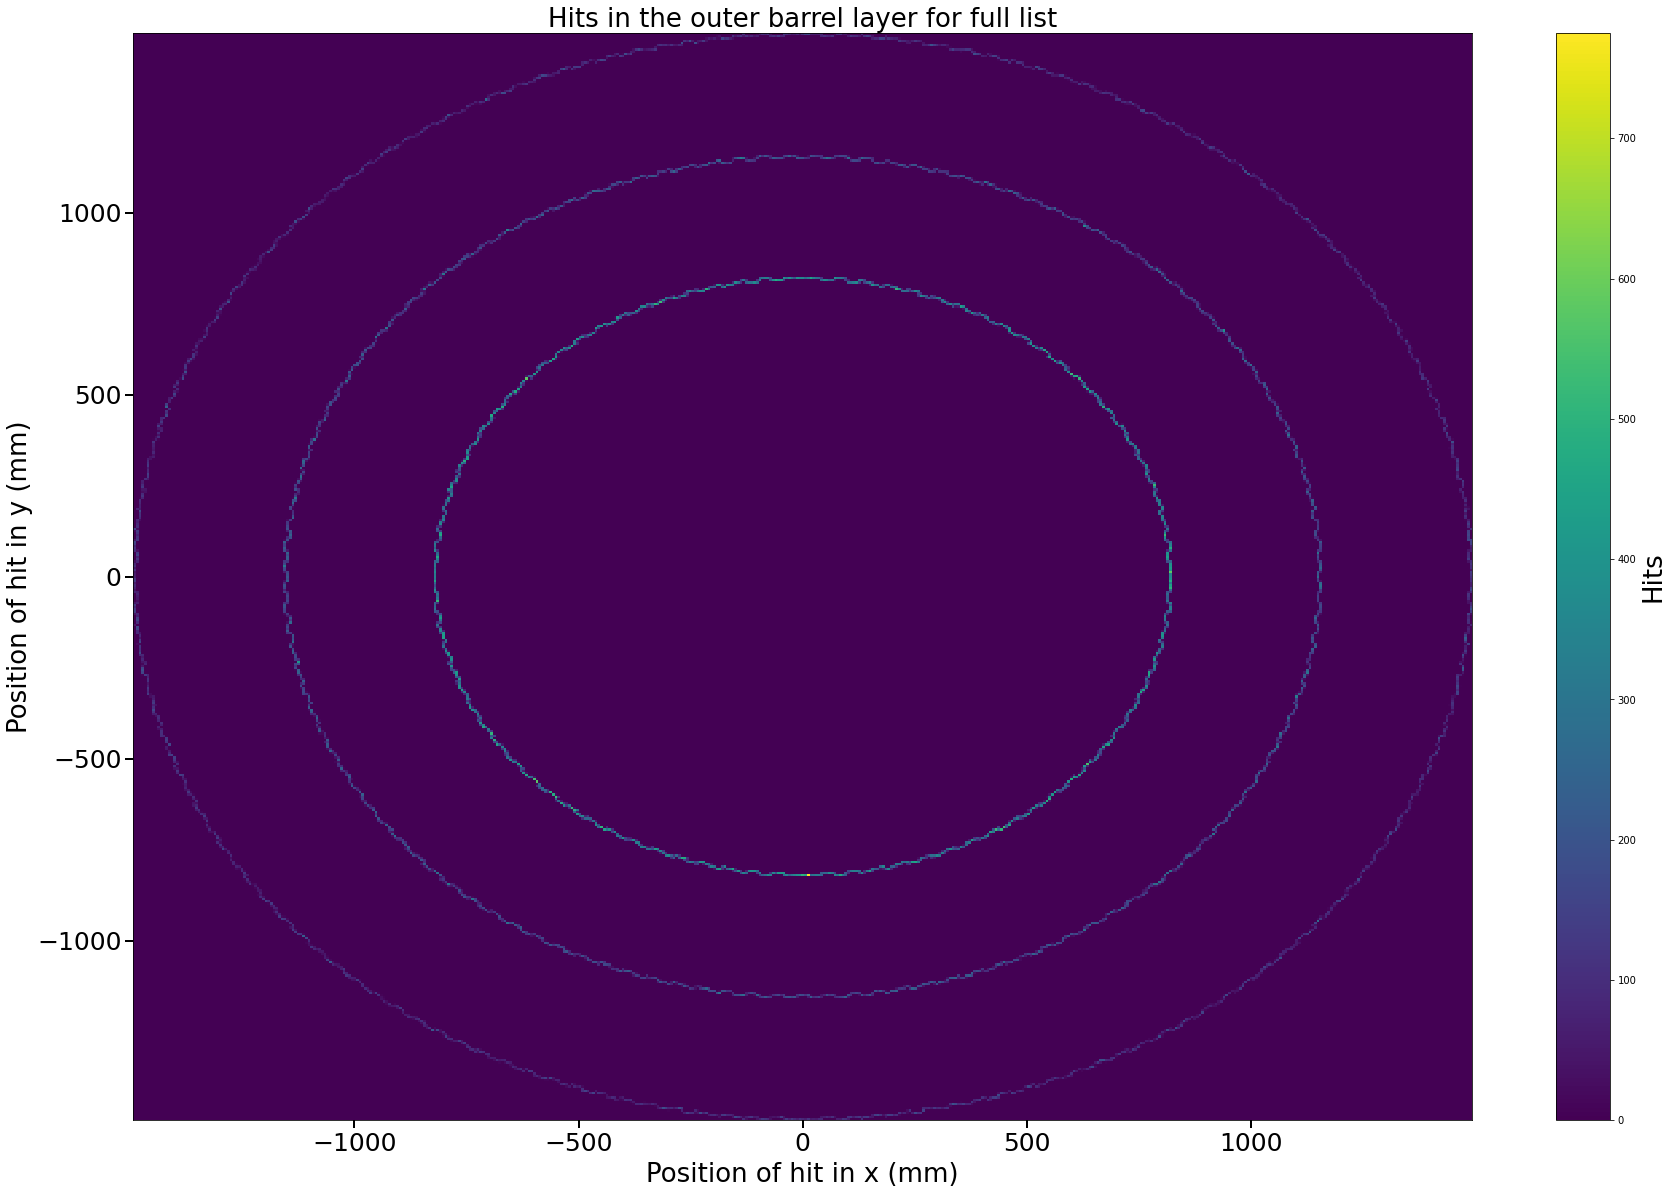

In [52]:
overallX=[]
overallY=[]
for i in range(10):
    overallX.append(locHits.OBX[i])
    overallY.append(locHits.OBY[i])
hist2d(ak.to_numpy(ak.concatenate(overallX)),ak.to_numpy(ak.concatenate(overallY)), axis1="Position of hit in x (mm)",axis2="Position of hit in y (mm)",title="Hits in the outer barrel layer for full list")

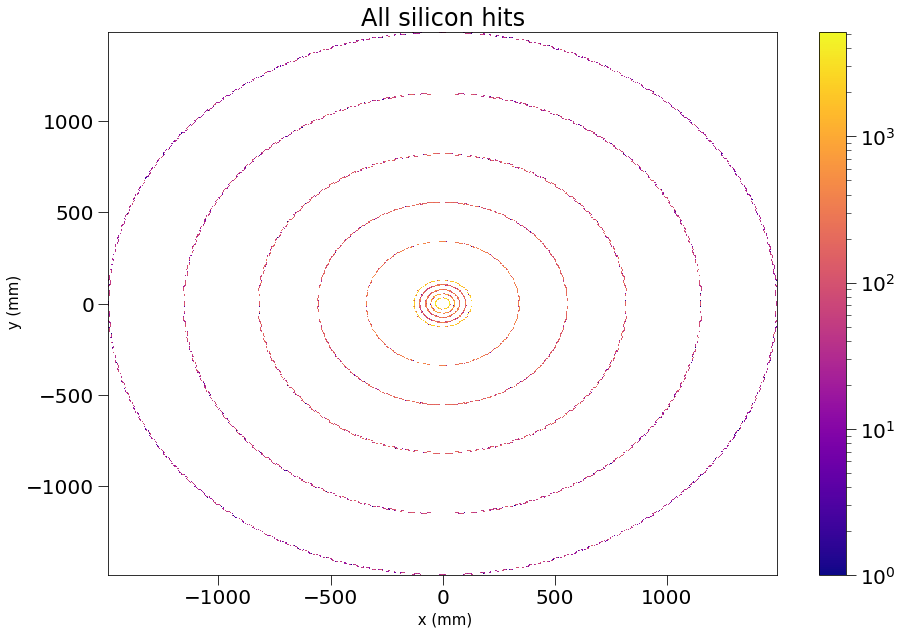

In [157]:
plot2DHistogram(ak.to_numpy(ak.concatenate((ak.flatten(locHits.OBX), ak.flatten(locHits.IBX), ak.flatten(locHits.VBX)))),ak.to_numpy(ak.concatenate((ak.flatten(locHits.OBY), ak.flatten(locHits.IBY), ak.flatten(locHits.VBY)))), bins=1000, label="All silicon hits; x (mm); y (mm)", savefig=True)

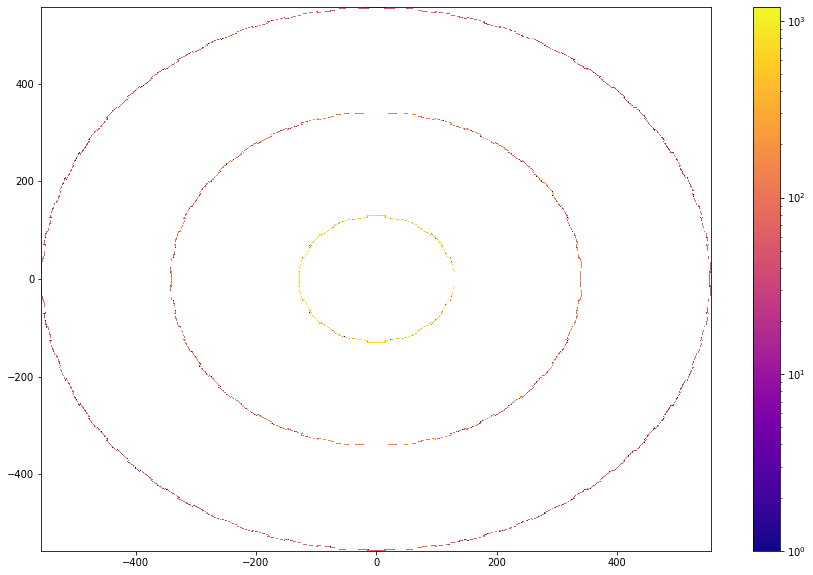

In [54]:
plot2DHistogram(ak.to_numpy(ak.concatenate(locHits.IBX)),ak.to_numpy(ak.concatenate(locHits.IBY)), bins=1000)

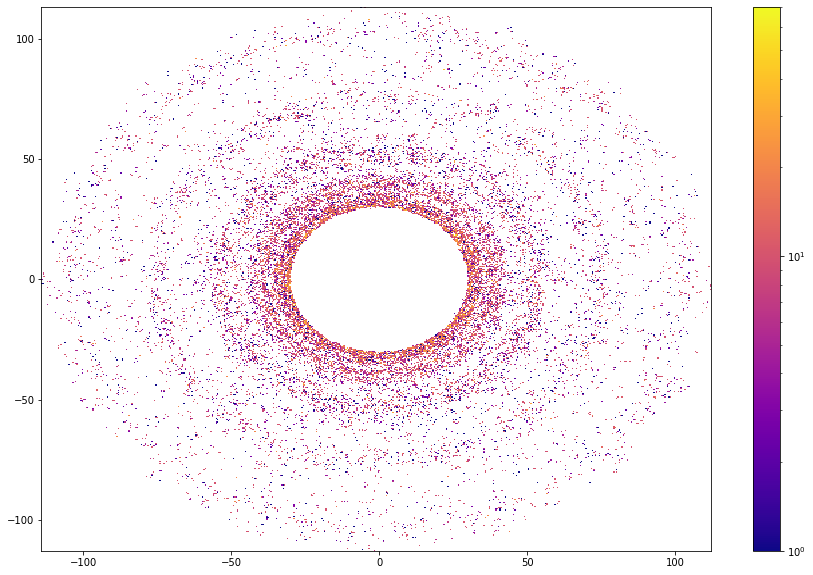

In [55]:
firstVBL=(locHits.VEZ >-100) & (locHits.VEZ < 100)
plot2DHistogram(ak.concatenate(locHits.VEX[firstVBL]),ak.concatenate(locHits.VEY[firstVBL]), bins=500)

In [56]:
help(plt.hist2d)

Help on function hist2d in module matplotlib.pyplot:

hist2d(x, y, bins=10, range=None, density=False, weights=None, cmin=None, cmax=None, *, data=None, **kwargs)
    Make a 2D histogram plot.
    
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input values
    
    bins : None or int or [int, int] or array-like or [array, array]
    
        The bin specification:
    
        - If int, the number of bins for the two dimensions
          (nx=ny=bins).
        - If ``[int, int]``, the number of bins in each dimension
          (nx, ny = bins).
        - If array-like, the bin edges for the two dimensions
          (x_edges=y_edges=bins).
        - If ``[array, array]``, the bin edges in each dimension
          (x_edges, y_edges = bins).
    
        The default value is 10.
    
    range : array-like shape(2, 2), optional
        The leftmost and rightmost edges of the bins along each dimension
        (if not specified explicitly in the bins parameters): ``

#### Holes

In [57]:
# Get the list of branches in the tree
for branch in treeB.keys():
    print(branch)

TightSelectedPandoraPFOs#0
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.index
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.collectionID
SiTracks#0
SiTracks#0/SiTracks#0.index
SiTracks#0/SiTracks#0.collectionID
SelectedPandoraPFOs#0
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.index
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.collectionID
LooseSelectedPandoraPFOs#0
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.index
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.collectionID
LE_SelectedPandoraPFOs#0
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.index
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.collectionID
LE_LooseSelectedPandoraPFOs#0
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.index
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.collectionID
MCPhysicsParticles#0
MCPhysicsParticles#0/MCPhysicsParticles#0.index
MCPhysicsParticles#0/MCPhysicsParticles#0.collectionID
YokeEndcapCollection
YokeEndcapCollection/YokeEndcap

In [58]:
# read in Inner Detector tracks

atIP = tree["SiTracks_Refitted_1.location"]==1 # select only measurements at IP
atLastHit = tree["SiTracks_Refitted_1.location"] == 3
atFirstHit= tree["SiTracks_Refitted_1.location"] == 2
atCal= tree["SiTracks_Refitted_1.location"] == 4

track_mass = 0.135*ak.ones_like(tree["SiTracks_Refitted.type"]) # make a mass array to initialize lorentz vector

# read in silicon tracks.... not sure if this is the collection we want, probably all tracks
tracks = ak.zip({"pt"    : pt(tree["SiTracks_Refitted_1.omega"][atIP]) ,
                 "theta" : theta(tree["SiTracks_Refitted_1.tanLambda"][atIP]) ,
                 "phi"   : tree["SiTracks_Refitted_1.phi"][atIP] ,
                 "mass"  : track_mass,
                 "d0"    : tree["SiTracks_Refitted_1.D0"][atIP], 
                 "z0"    : tree["SiTracks_Refitted_1.Z0"][atIP], 
                 "t"     : tree["SiTracks_Refitted_1.time"][atIP] ,
                 "chi2"  : tree["SiTracks_Refitted.chi2"], 
                 "ndf"   : tree["SiTracks_Refitted.ndf"], 
                 "dEdx"  : tree["SiTracks_Refitted.dEdx"], 
                 "rInner" : tree["SiTracks_Refitted.radiusOfInnermostHit"],
                 "RIH" : tree["SiTracks_Refitted.radiusOfInnermostHit"],
                 "SHB" : tree["SiTracks_Refitted.subDetectorHitNumbers_begin"],
                 "SHE" : tree["SiTracks_Refitted.subDetectorHitNumbers_end"],
                 "HB" : tree["SiTracks_Refitted.trackerHits_begin"],
                 "HE" : tree["SiTracks_Refitted.trackerHits_end"],
                 "TB" : tree["SiTracks_Refitted.tracks_begin"],
                 "TE" : tree["SiTracks_Refitted.tracks_end"],
                 "rxE" : tree["SiTracks_Refitted_1.referencePoint.x"][atLastHit],
                 "ryE" : tree["SiTracks_Refitted_1.referencePoint.y"][atLastHit],
                 "rzE" : tree["SiTracks_Refitted_1.referencePoint.z"][atLastHit],
                 "rxB" : tree["SiTracks_Refitted_1.referencePoint.x"][atFirstHit],
                 "ryB" : tree["SiTracks_Refitted_1.referencePoint.y"][atFirstHit],
                 "rzB" : tree["SiTracks_Refitted_1.referencePoint.z"][atFirstHit],
                 "rxC" : tree["SiTracks_Refitted_1.referencePoint.x"][atCal],
                 "ryC" : tree["SiTracks_Refitted_1.referencePoint.y"][atCal],
                 "rzC" : tree["SiTracks_Refitted_1.referencePoint.z"][atCal],
                 "rx" : tree["SiTracks_Refitted_1.referencePoint.x"],
                 "ry" : tree["SiTracks_Refitted_1.referencePoint.y"],
                 "rz" : tree["SiTracks_Refitted_1.referencePoint.z"],
                 "loc" : tree["SiTracks_Refitted_1.location"],
                 "dEdx" : tree["SiTracks_Refitted.dEdx"],
                 "dEdxError" : tree["SiTracks_Refitted.dEdxError"],
                 "type" : tree["SiTracks_Refitted.type"],
                 "twoValue" : tree["SiTracks_Refitted_2.value"],
                 "omegaB" : tree["SiTracks_Refitted_1.omega"][atFirstHit],
                 "omegaE" : tree["SiTracks_Refitted_1.omega"][atLastHit]
                }, depth_limit=1,
                                   with_name="Momentum4D")

In [59]:
params=ak.zip({"intMap" : treeB["_intMap"],
              "intMapFirst" : treeB["_intMap.first"],
              "intMapSecond" : treeB["_intMap.second"],
              "floatMap" : treeB["_floatMap"],
              "floatMapFirst" : treeB["_floatMap.first"],
              "floatMapSecond" : treeB["_floatMap.second"],
              "stringMap" : treeB["_stringMap"],
              "stringMapFirst" : treeB["_stringMap.first"],
              "stringMapSecond" : treeB["_stringMap.second"],
              "doubleMap" : treeB["_doubleMap"],
              "doubleMapFirst" : treeB["_doubleMap.first"],
              "doubleMapSecond" : treeB["_doubleMap.second"]})

In [60]:
def findLen(akwardarray):
    print(len(akwardarray))
    for i in range(len(akwardarray)):
        print(len(akwardarray[i]))

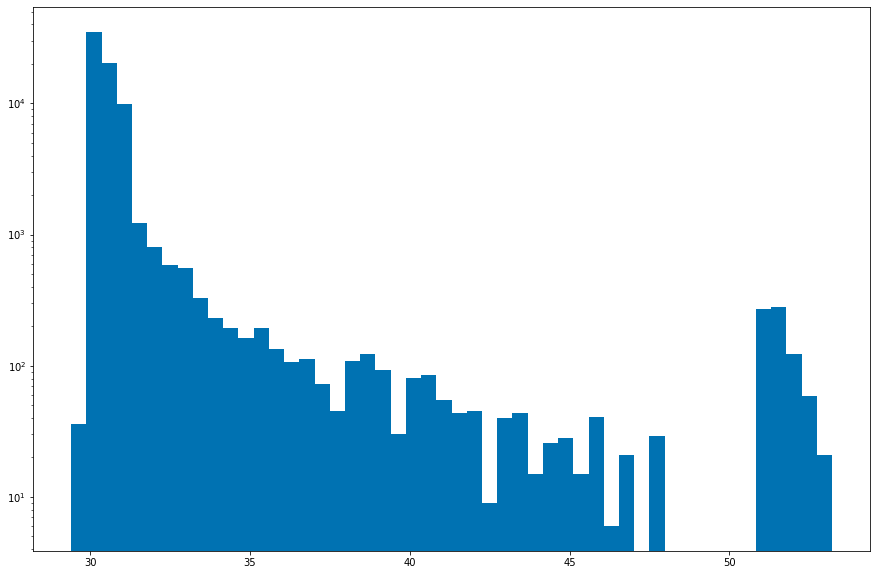

In [61]:
plot1DHistogram(tracks.RIH, bins=50, scale="log")

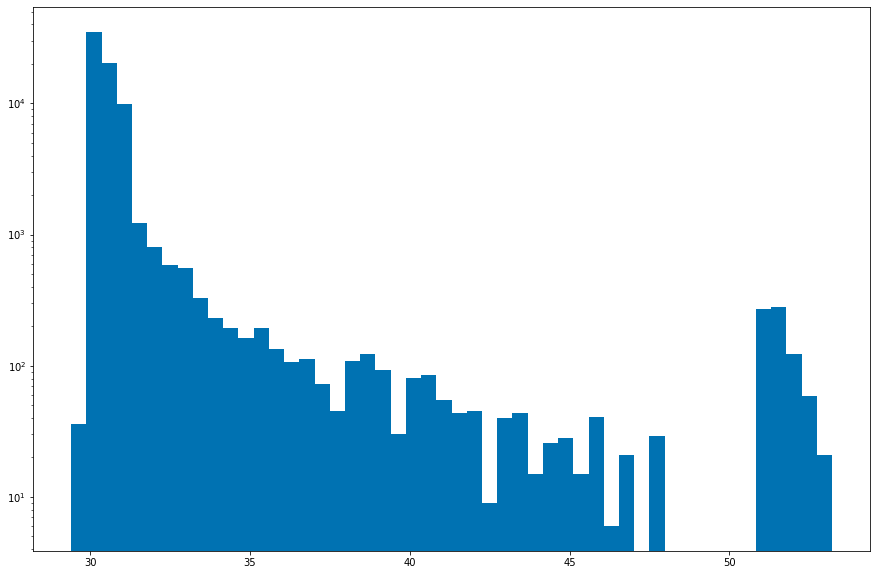

In [62]:
plot1DHistogram(np.sqrt(tracks.rxB**2+tracks.ryB**2), bins=50, scale="log")

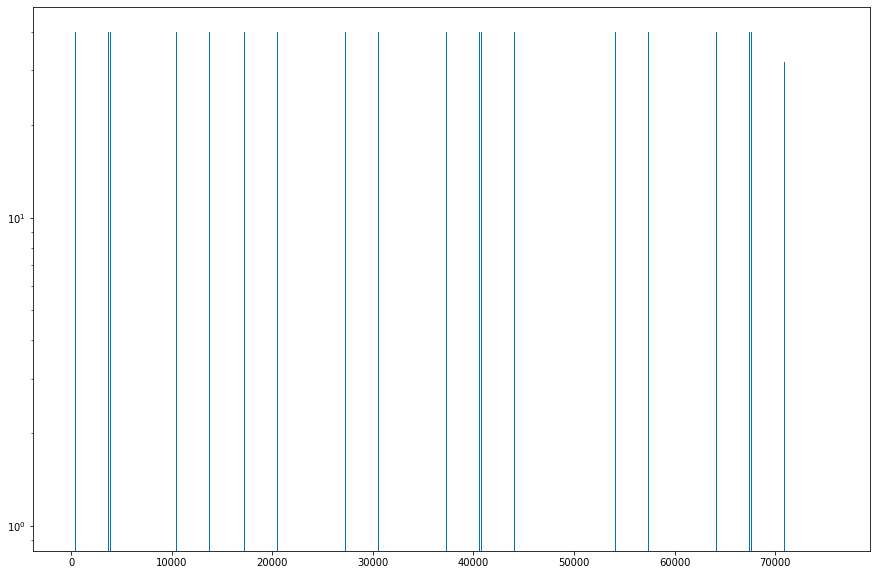

In [63]:
plot1DHistogram(tracks.SHB, bins=80000, scale="log")

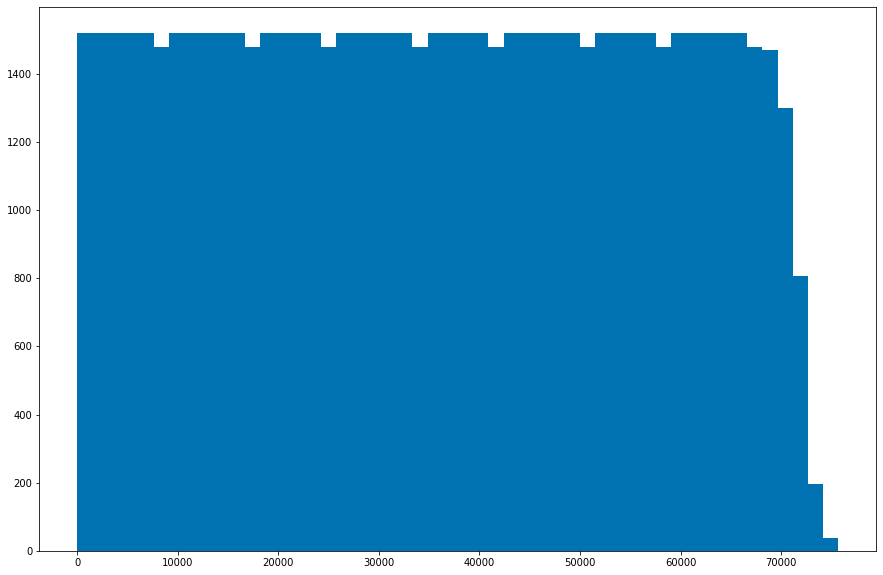

In [64]:
plot1DHistogram(tracks.SHE, bins=50)

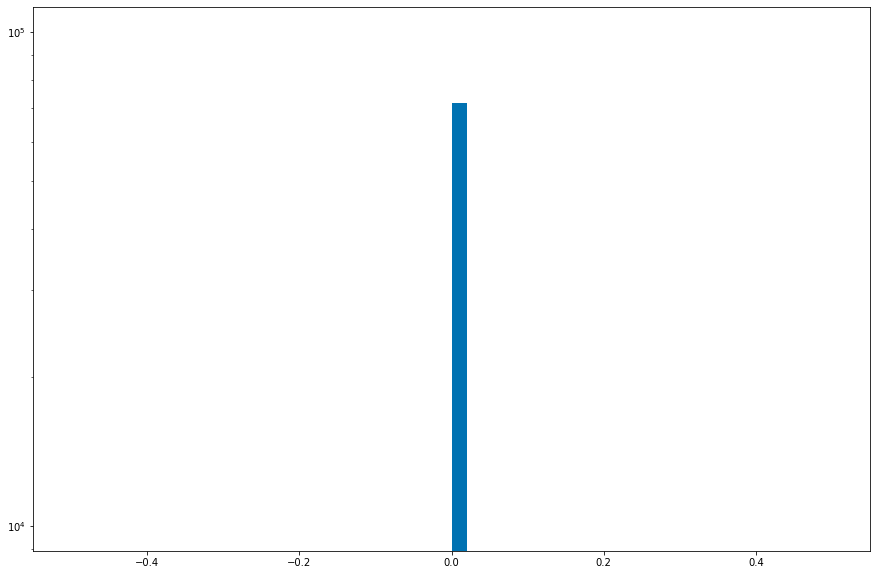

In [65]:
plot1DHistogram(tracks.HB, bins=50, scale="log")

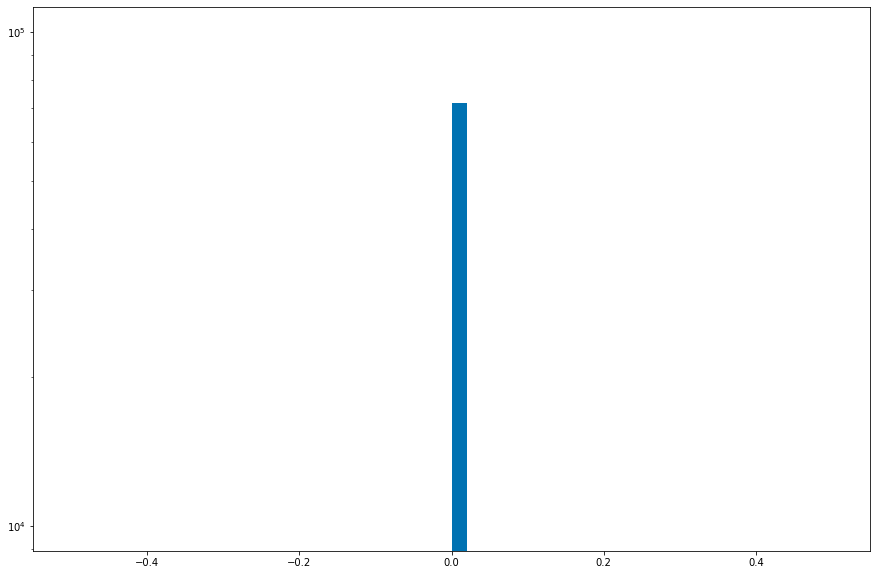

In [66]:
plot1DHistogram(tracks.HE, bins=50, scale="log")

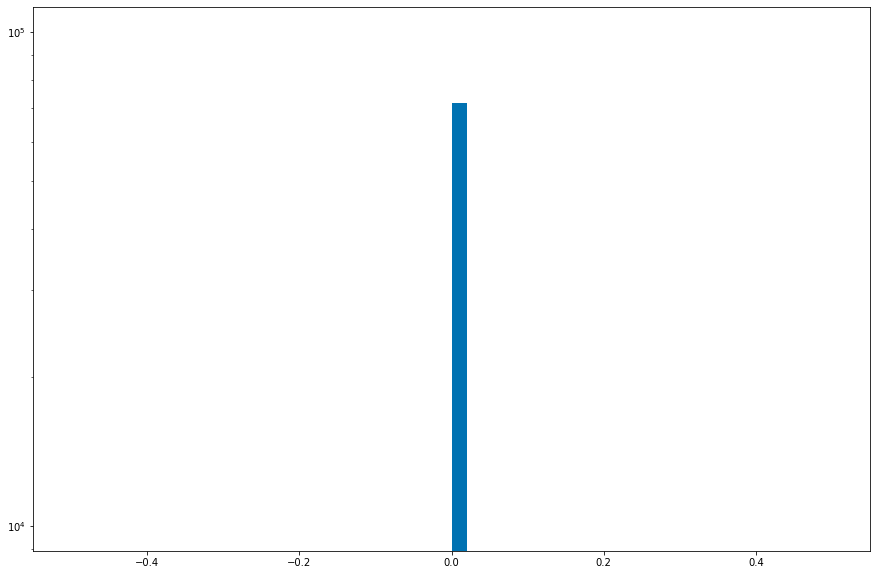

In [67]:
plot1DHistogram(tracks.TB, bins=50, scale="log")

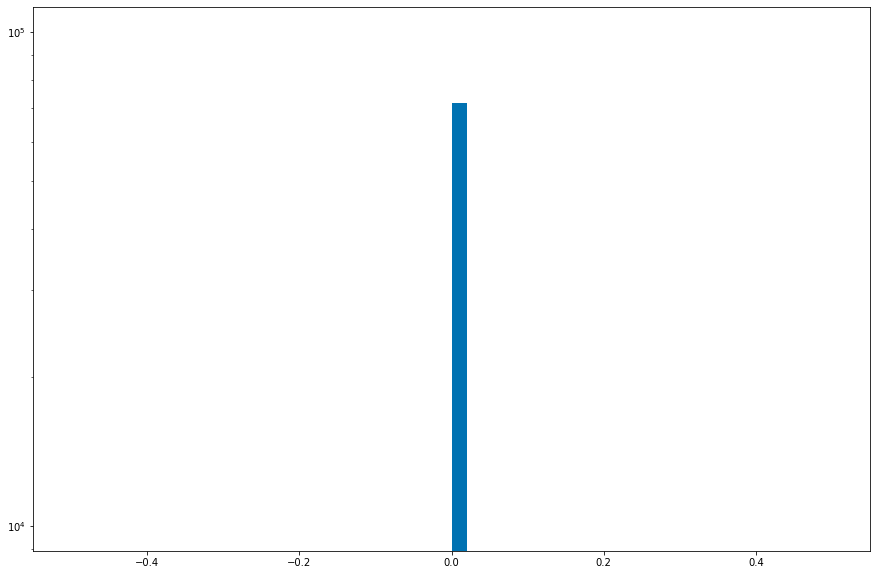

In [68]:
plot1DHistogram(tracks.TE, bins=50, scale="log")

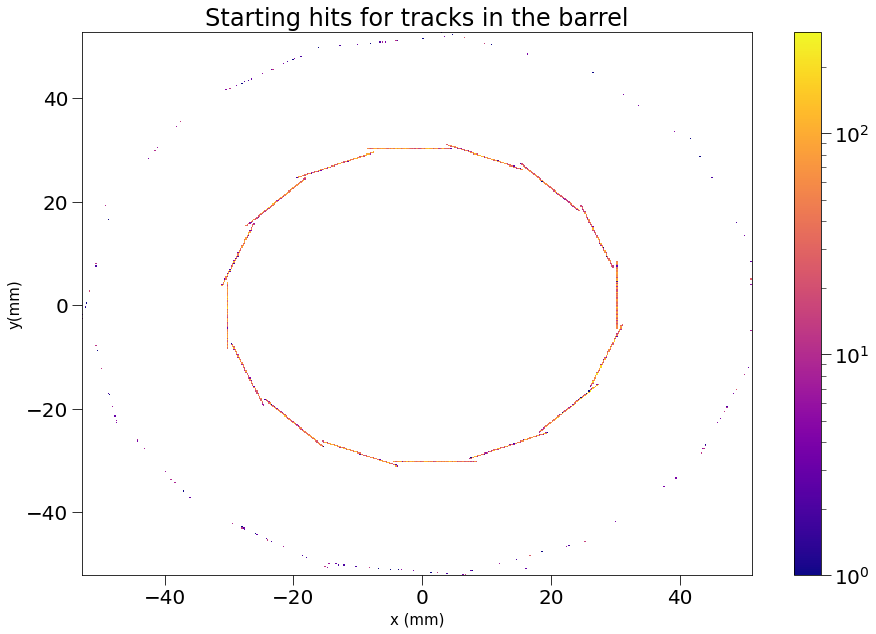

In [151]:
inBarrelB=((tracks.rzB < 80) & (tracks.rzB > -80))
plot2DHistogram(tracks.rxB[inBarrelB], tracks.ryB[inBarrelB], bins=500, label="Starting hits for tracks in the barrel;x (mm);y(mm)", savefig=True)

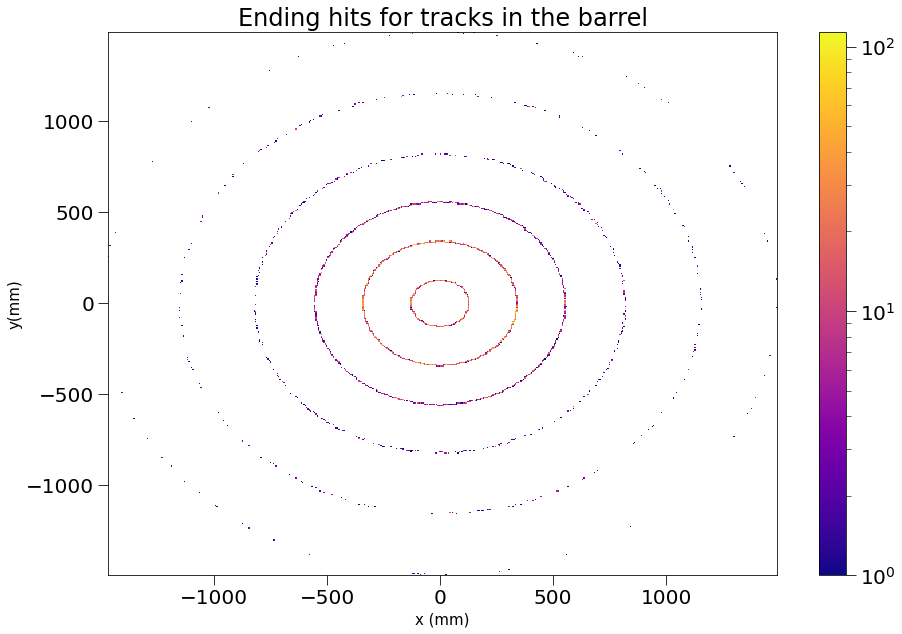

In [152]:
inBarrelE=((tracks.rzE < 200) & (tracks.rzE > -200))
plot2DHistogram(tracks.rxE[inBarrelE], tracks.ryE[inBarrelE], bins=500, label="Ending hits for tracks in the barrel;x (mm);y(mm)", savefig=True)

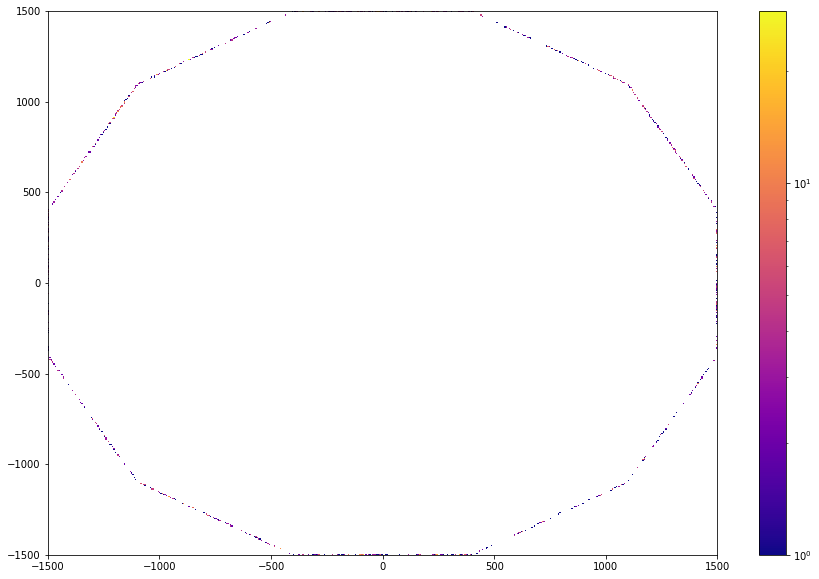

In [71]:
inBarrelE=((tracks.rzC < 200) & (tracks.rzC > -200))
plot2DHistogram(tracks.rxC[inBarrelE], tracks.ryC[inBarrelE], bins=500)

In [72]:
radB=np.sqrt(tracks.rxB**2 + tracks.ryB**2)
rad=np.sqrt(tracks.rxE**2 + tracks.ryE**2)

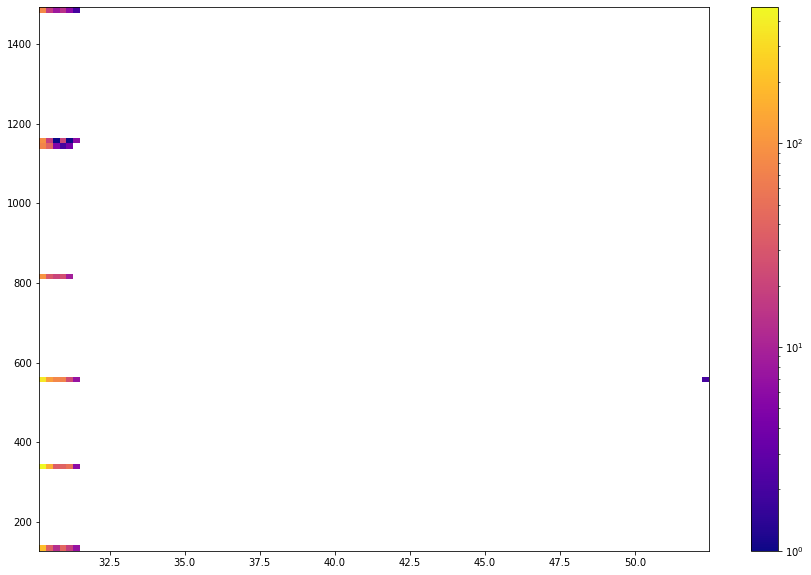

In [73]:
plot2DHistogram(radB[inBarrelB & inBarrelE], rad[inBarrelB & inBarrelE])

/opt/anaconda3/lib/python3.8/site-packages/awkward/_connect/numpy.py:258: RuntimeWarning: invalid value encountered in sqrt
  result = impl(*args, **kwargs)


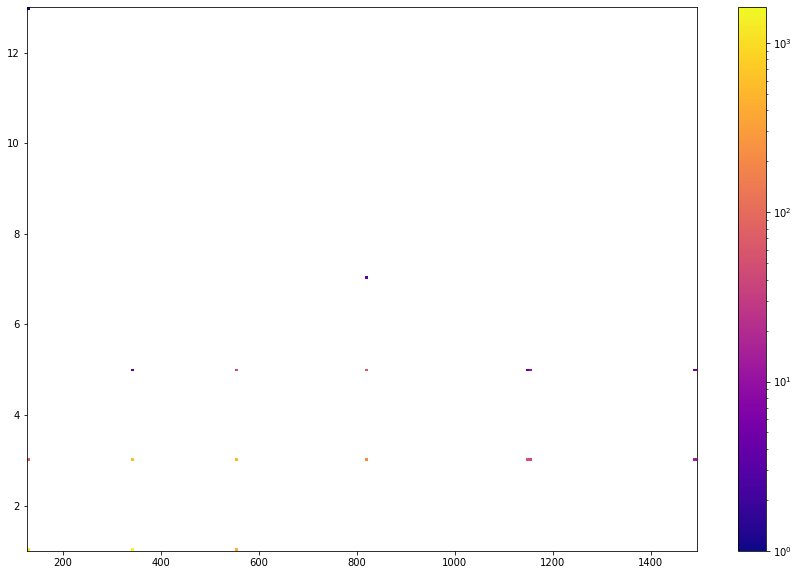

In [74]:
outerZ=80
straightOut=(((np.sqrt(tracks.rxB+tracks.ryB) < 35) & ((tracks.rzB < 80) & (tracks.rzB > -80))) &((tracks.rzE < outerZ) & (tracks.rzE > -outerZ)))
plot2DHistogram(rad[straightOut], tracks.ndf[straightOut], bins=200)

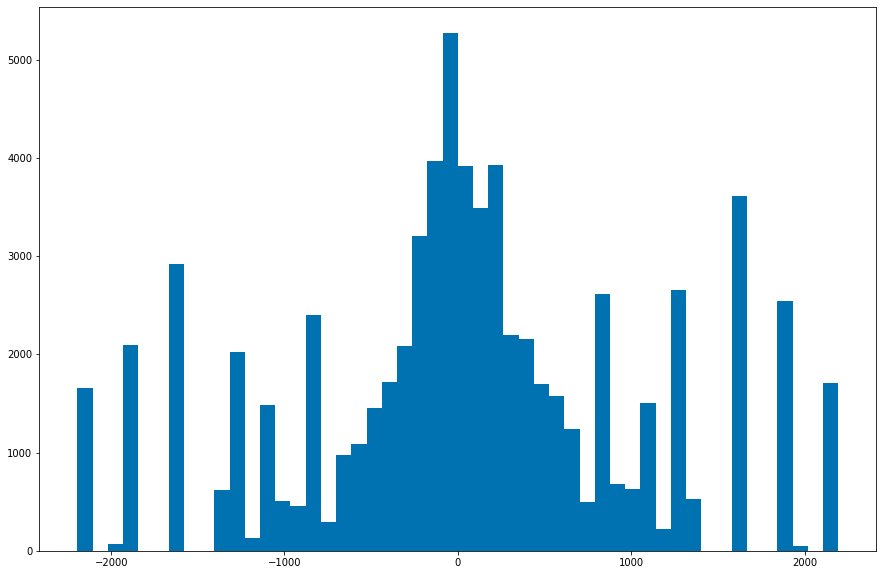

In [75]:
plot1DHistogram(tracks.rzE, bins=50)

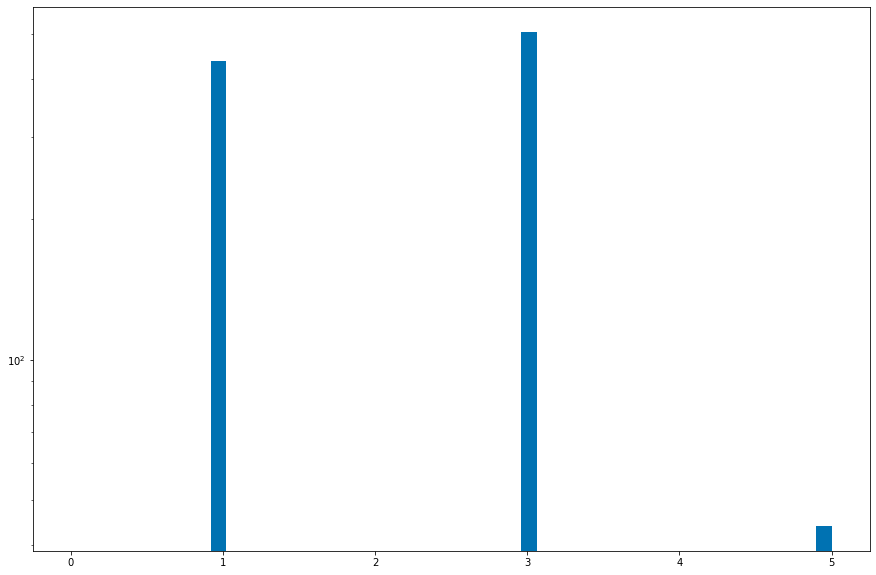

In [76]:
plot1DHistogram(tracks.ndf[straightOut & ((rad >400) & (rad<600))], bins=np.linspace(0,5,50), scale="log")

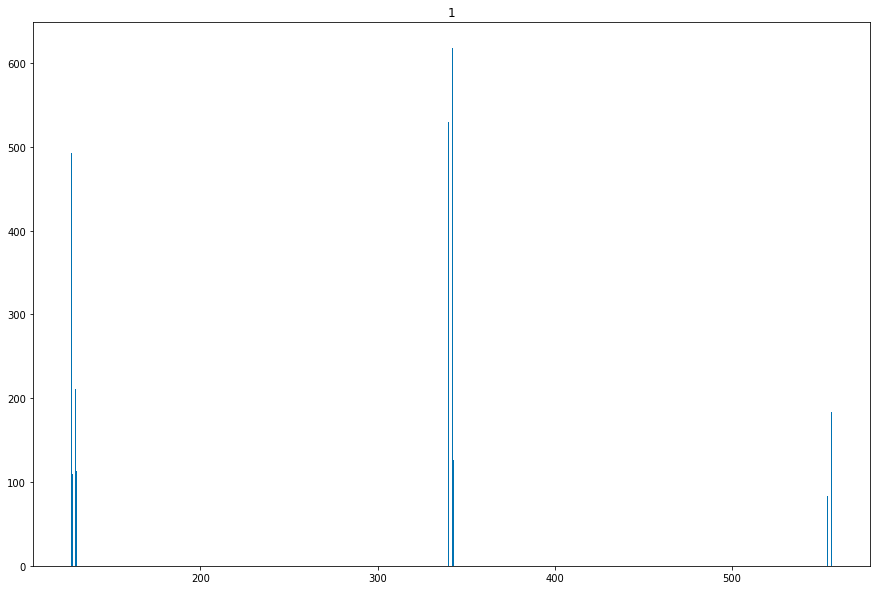

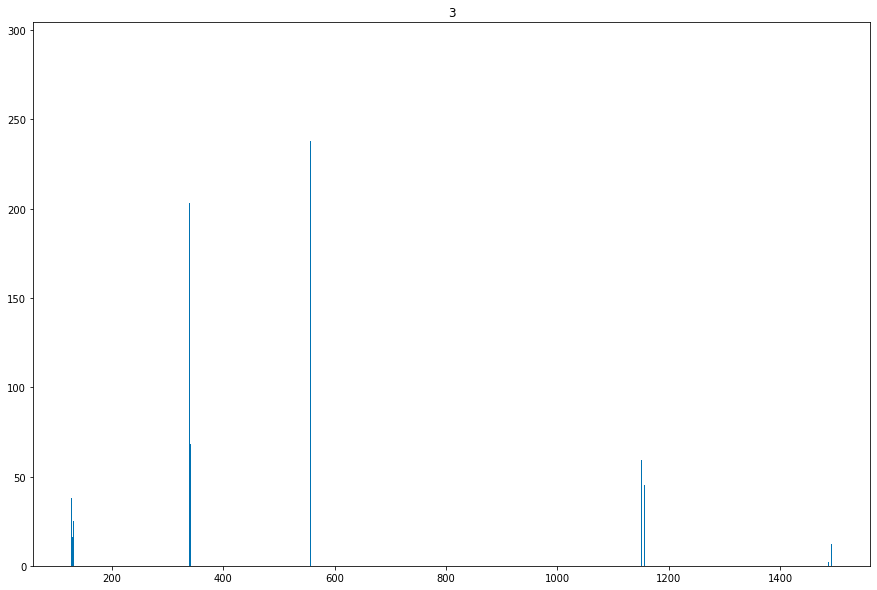

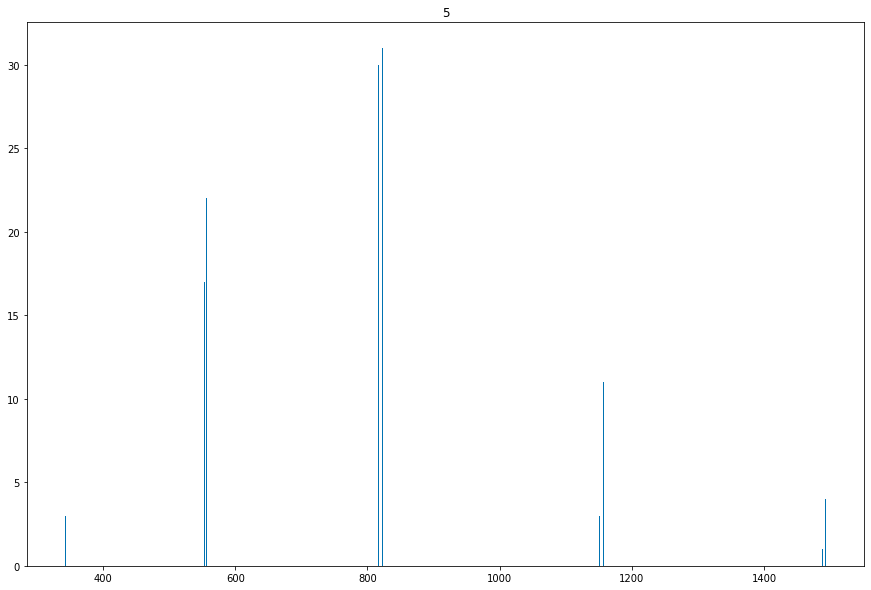

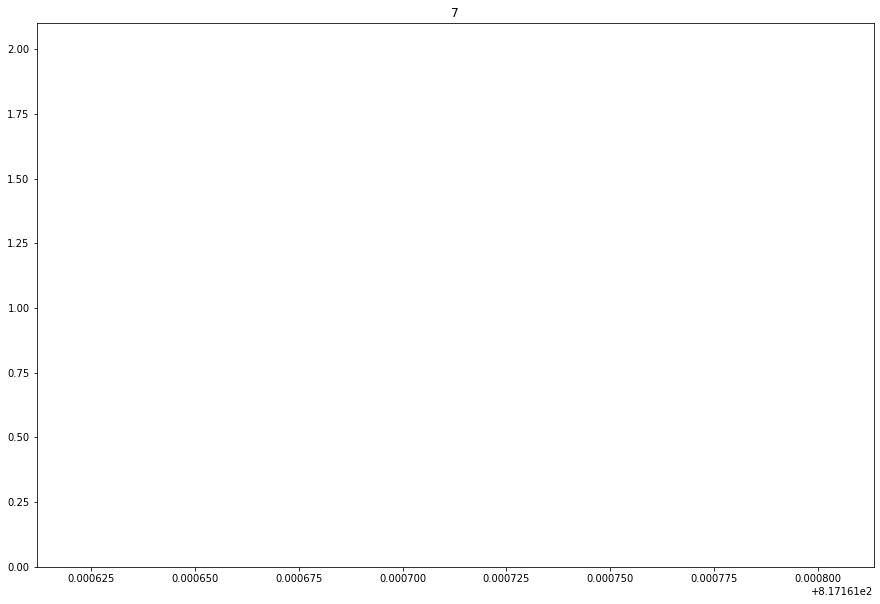

In [77]:
for i in range(4):
    plot1DHistogram(rad[straightOut & (tracks.ndf==(1+2*i))], bins=1000, label=str(1+2*i))

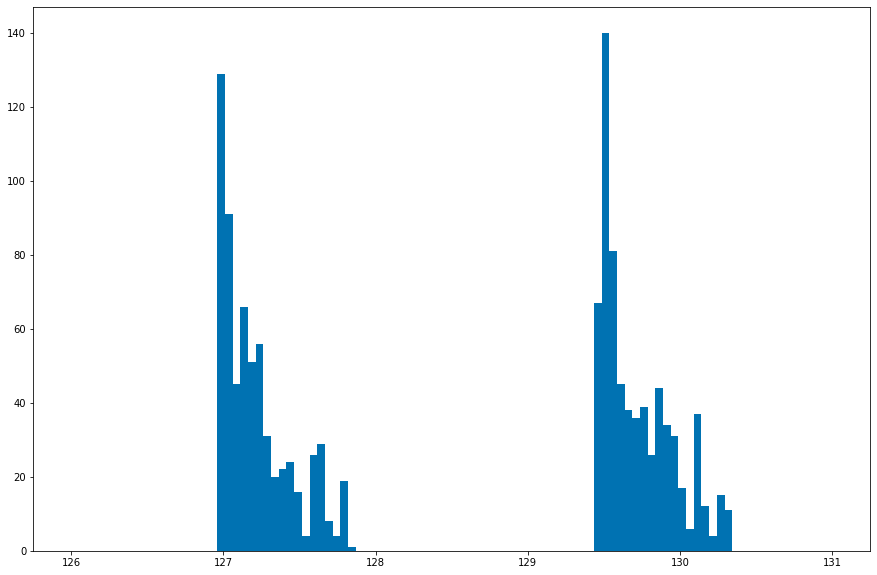

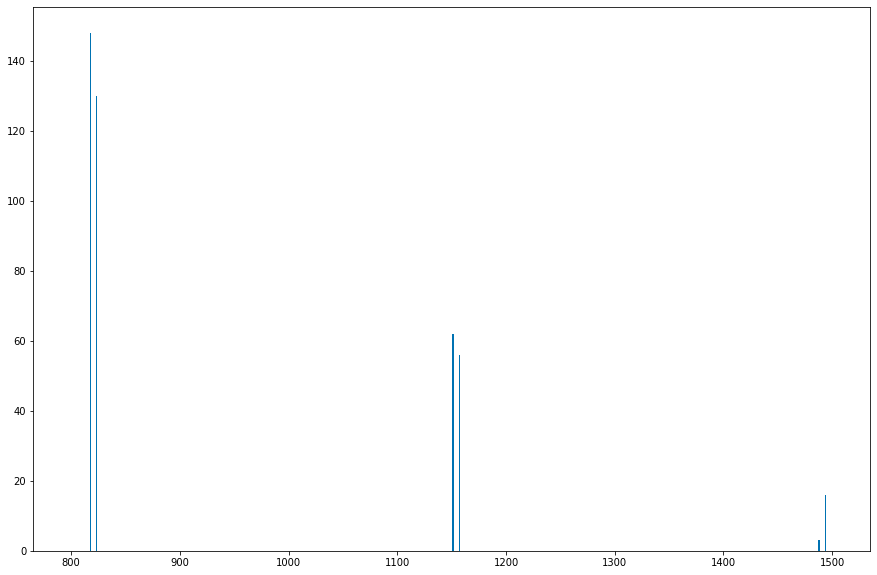

In [78]:
plot1DHistogram(rad[straightOut], bins=np.linspace(126,131,100))
plot1DHistogram(rad[straightOut], bins=np.linspace(800,1500,500))

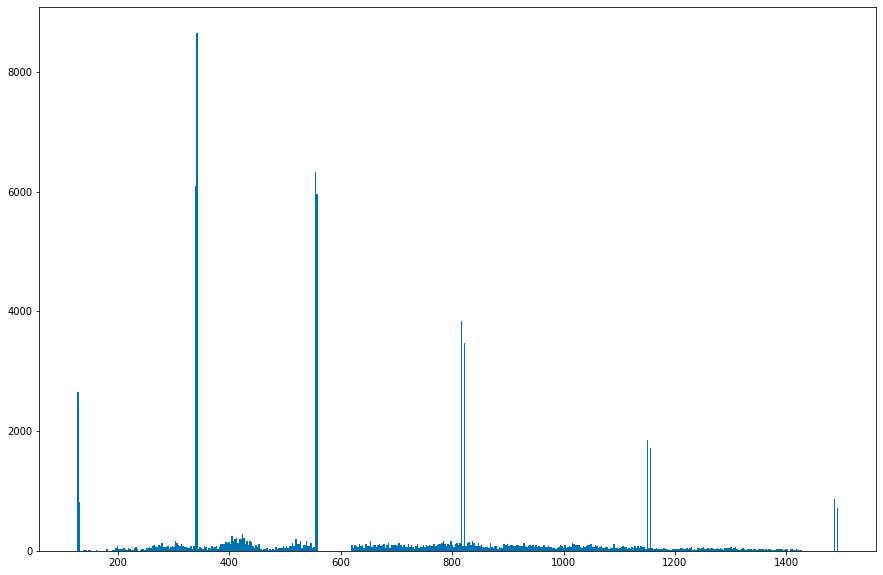

In [79]:
plot1DHistogram(rad, bins=500)

In [80]:
hitsRad=(ak.concatenate((ak.flatten(locHits.OBX), ak.flatten(locHits.IBX), ak.flatten(locHits.VBX)))**2 +ak.concatenate((ak.flatten(locHits.OBY), ak.flatten(locHits.IBY), ak.flatten(locHits.VBY)))**2)**(1/2)

In [81]:
print(type(hitsRad[0]))

<class 'numpy.float64'>


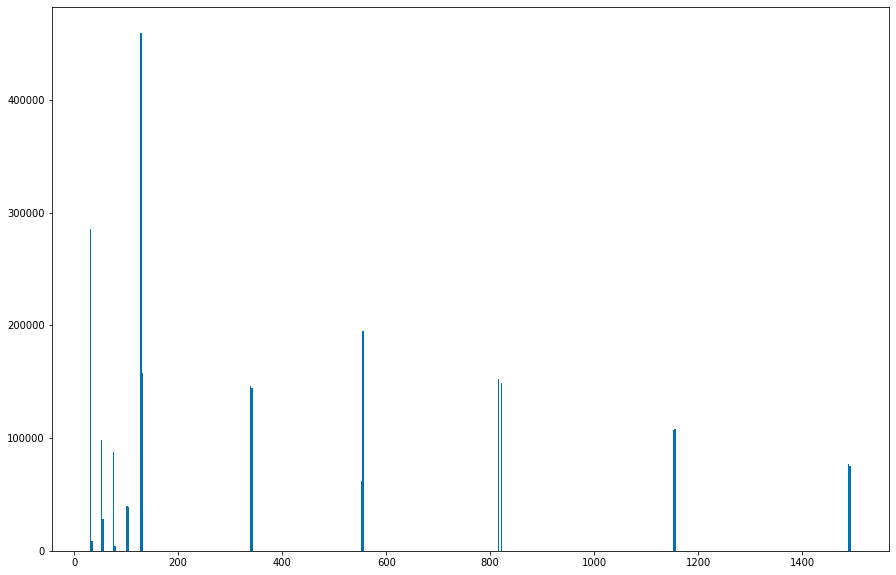

In [82]:
plot1DHistogram(hitsRad, bins=500)

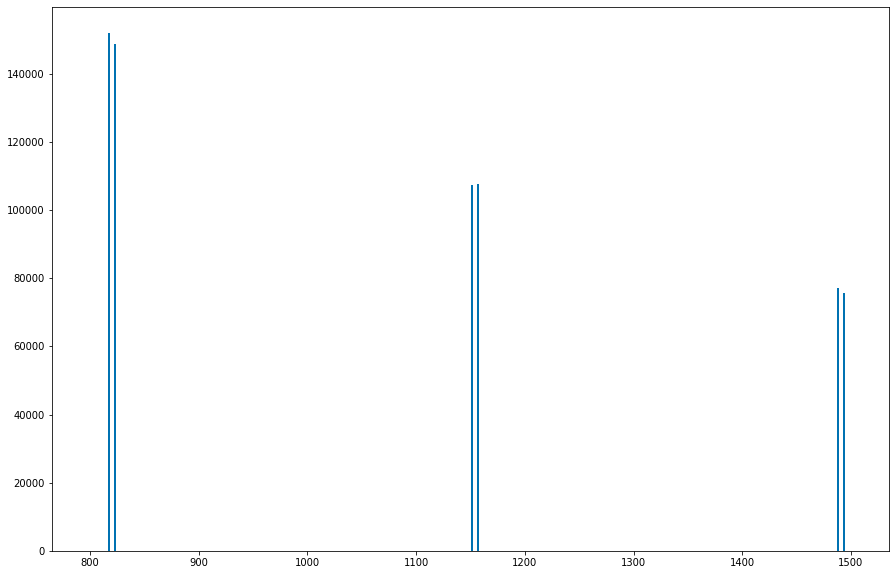

In [83]:
plot1DHistogram(hitsRad, bins=np.linspace(800,1500,500))

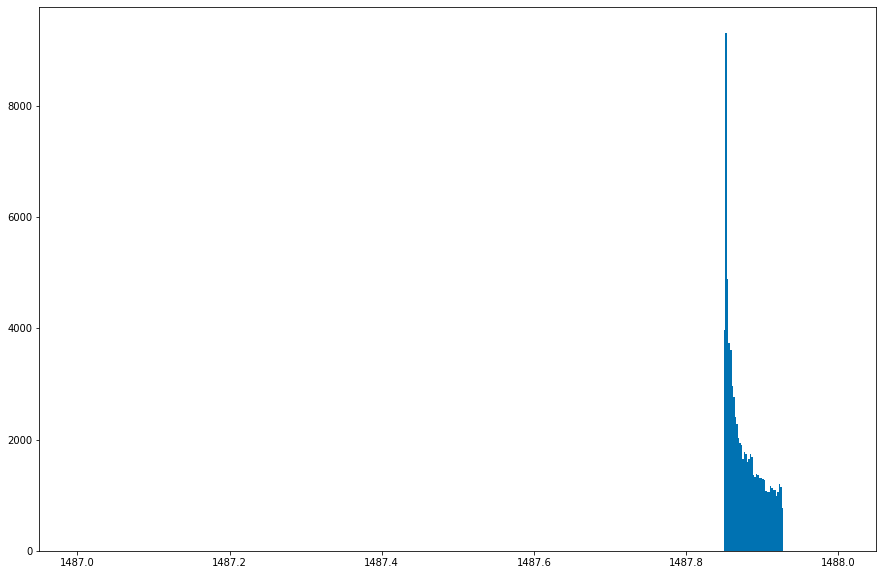

In [84]:
plot1DHistogram(hitsRad, bins=np.linspace(1487,1488,500))

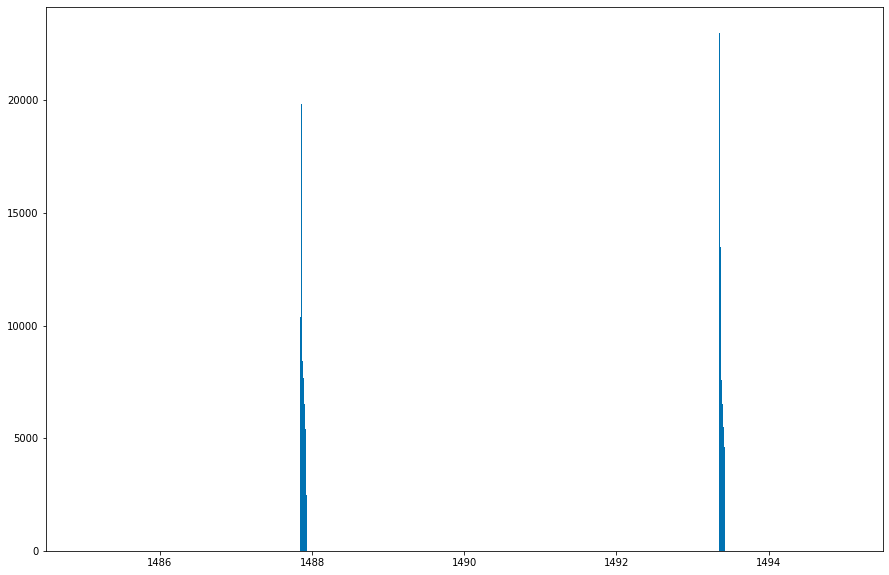

In [85]:
plot1DHistogram(hitsRad, bins=np.linspace(1485,1495,1000))

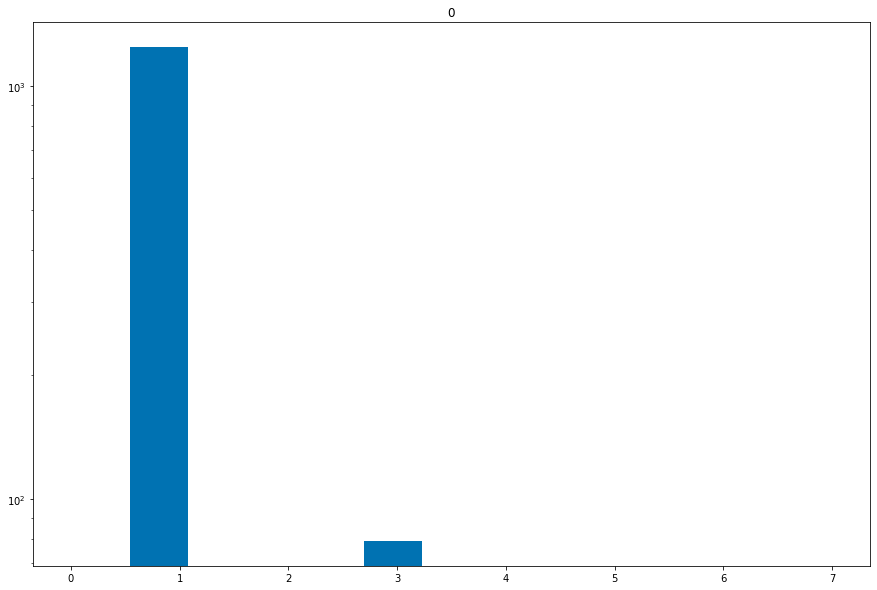

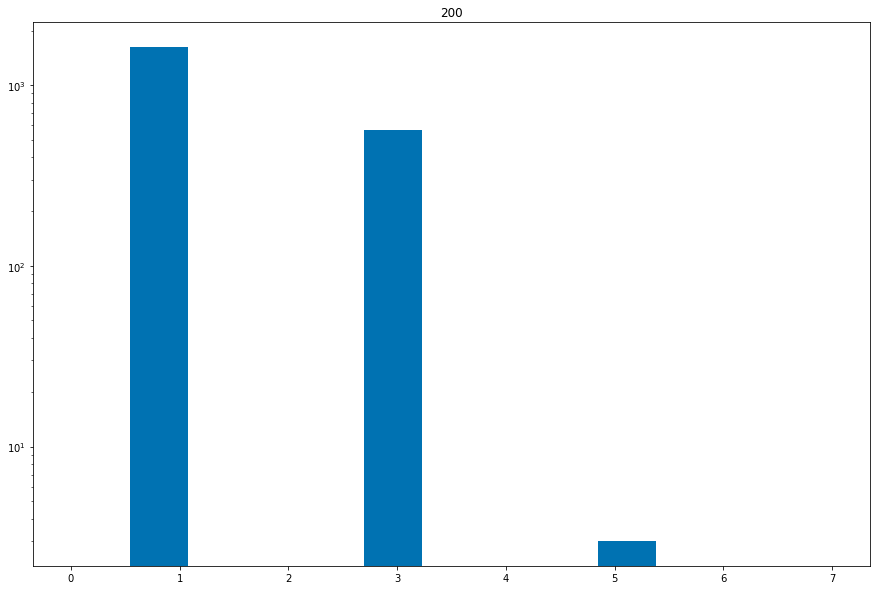

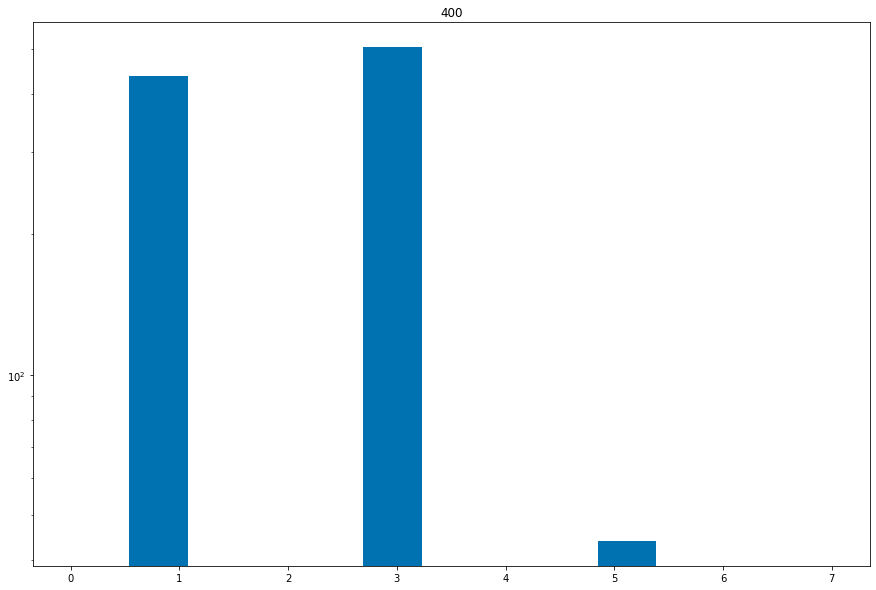

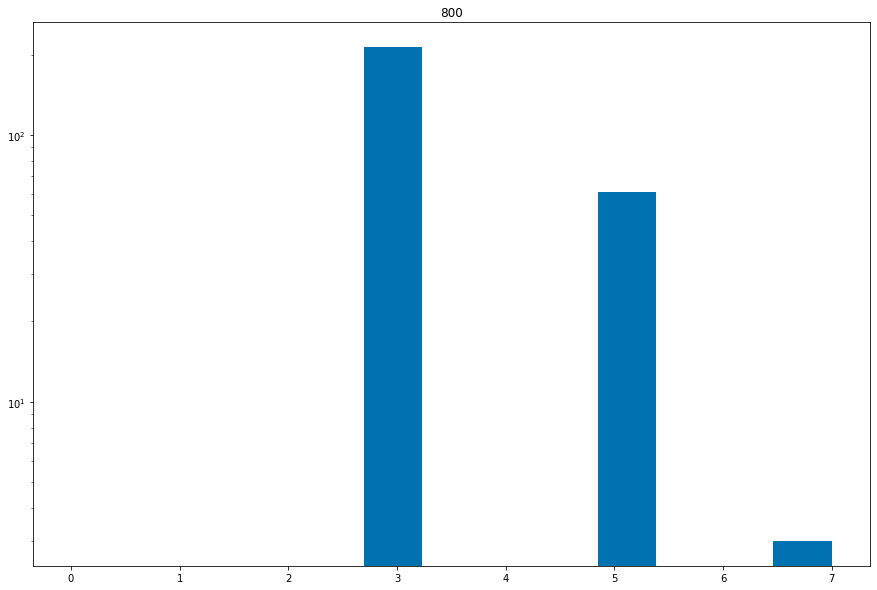

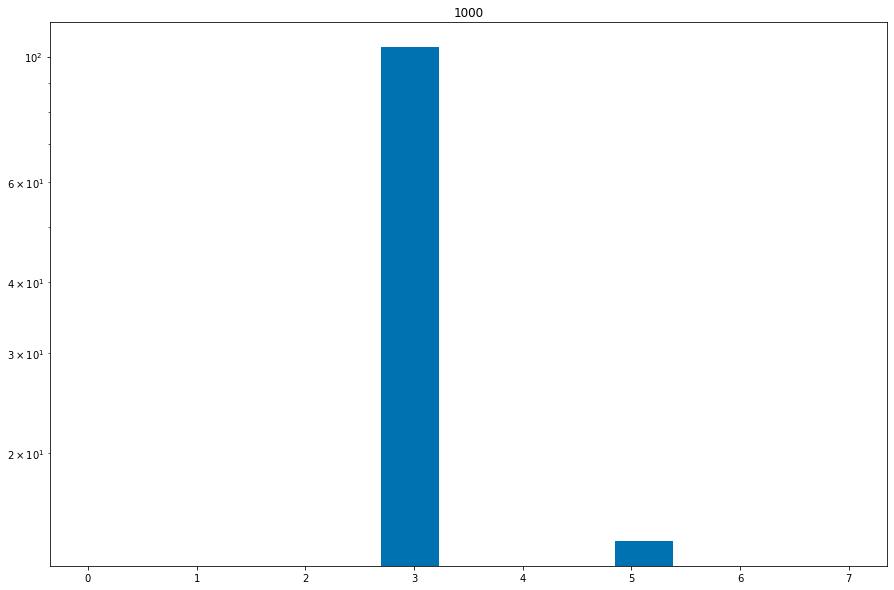

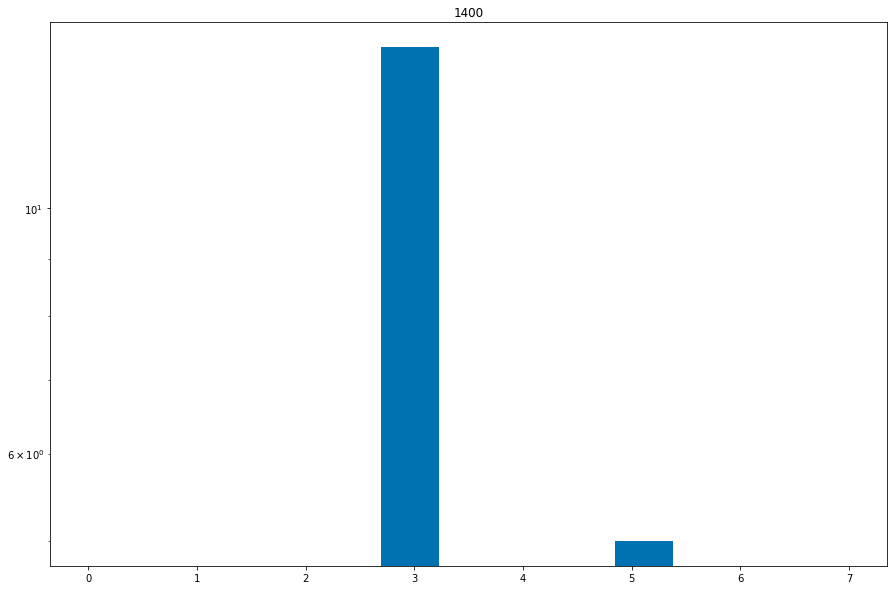

In [86]:
start=[0,200,400,800,1000,1400]
for i in start:
    plot1DHistogram(tracks.ndf[straightOut & ((rad > i) & (rad < (i+200)))],bins=np.linspace(0,7,14), label=str(i), scale="log")

In [87]:
print(findLen(tracks.dEdxError))

40
1847
1814
1812
1799
1816
1794
1726
1791
1797
1733
1803
1810
1819
1771
1803
1821
1728
1782
1798
1784
1851
1802
1836
1784
1806
1781
1772
1805
1843
1735
1839
1809
1830
1760
1794
1796
1728
1795
1892
1785
None


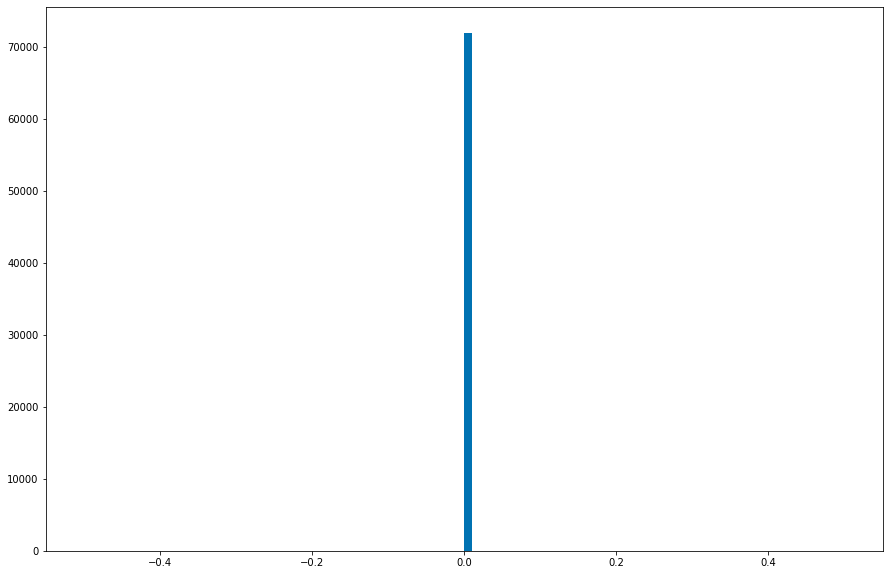

In [88]:
plot1DHistogram(tracks.dEdx, bins=100)

In [89]:
findLen(tracks.rxE)

40
1847
1814
1812
1799
1816
1794
1726
1791
1797
1733
1803
1810
1819
1771
1803
1821
1728
1782
1798
1784
1851
1802
1836
1784
1806
1781
1772
1805
1843
1735
1839
1809
1830
1760
1794
1796
1728
1795
1892
1785


In [90]:
findLen(tracks.rx)

40
7388
7256
7248
7196
7264
7176
6904
7164
7188
6932
7212
7240
7276
7084
7212
7284
6912
7128
7192
7136
7404
7208
7344
7136
7224
7124
7088
7220
7372
6940
7356
7236
7320
7040
7176
7184
6912
7180
7568
7140


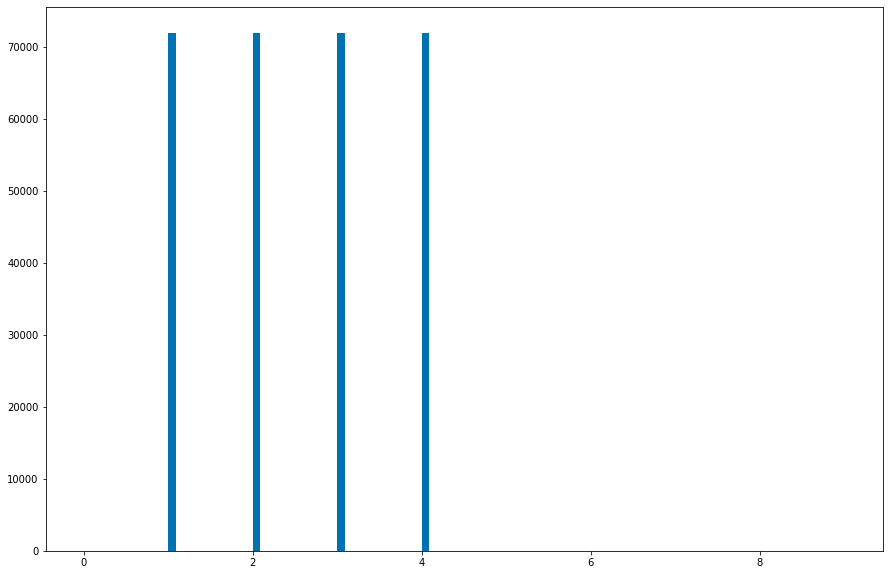

In [91]:
plot1DHistogram(tracks.loc, bins=np.linspace(0,9,100))

In [92]:
def expectedNDOF(start, end, zin=80, zout=80, zoutmin=0):
    #start should be a tuple of (x at first hit, y at first hit, z at first hit),
    #while end should follow the same format
    inBarrel= ((start[2] > -zin) & (start[2] < zin)) & (((end[2] > -zout) & (end[2] <=-zoutmin)) | ((end[2] < zout) & ((end[2] >=zoutmin))))
    ndof=ak.zeros_like(start[0][inBarrel])
    detectorsIn=[30,32,51,53,74,76,102,104,126,339,553,816,1150,1487]
    detectorsOut=[32,34,53,55,76,78,104,106,131,343,557,824,1158,1494]
    startRad=np.sqrt(start[0][inBarrel]**2+start[1][inBarrel]**2)
    endRad=np.sqrt(end[0][inBarrel]**2+end[1][inBarrel]**2)
    for i in range(len(detectorsIn)):
        inTrack=(startRad < detectorsOut[i]) & (endRad > detectorsIn[i])
        ndof=ndof+2*inTrack
    return ndof-5

In [93]:
ENDOF=expectedNDOF((tracks.rxB,tracks.ryB,tracks.rzB),(tracks.rxE,tracks.ryE,tracks.rzE))

In [94]:
findLen(ENDOF)

40
223
217
198
214
238
220
209
223
221
195
190
216
220
196
237
223
210
227
214
198
198
214
220
203
216
202
226
215
198
195
190
215
213
196
216
215
204
222
180
202


In [95]:
inBB=((tracks.rzB < 80) & (tracks.rzB > -80))
inBE=((tracks.rzE < 80) & (tracks.rzE > -80))
findLen(rad[inBB & inBE])

40
223
217
198
214
238
220
209
223
221
195
190
216
220
196
237
223
210
227
214
198
198
214
220
203
216
202
226
215
198
195
190
215
213
196
216
215
204
222
180
202


In [96]:
hitsFirstDet=np.sqrt(tracks.rxB**2+tracks.ryB**2)[inBB & inBE] < 40

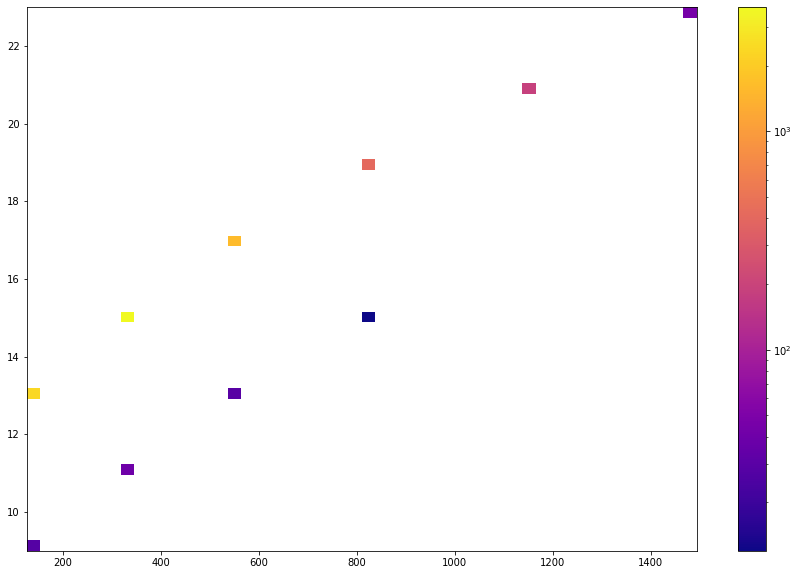

In [97]:
plot2DHistogram(rad[inBB & inBE],ENDOF, bins=50)

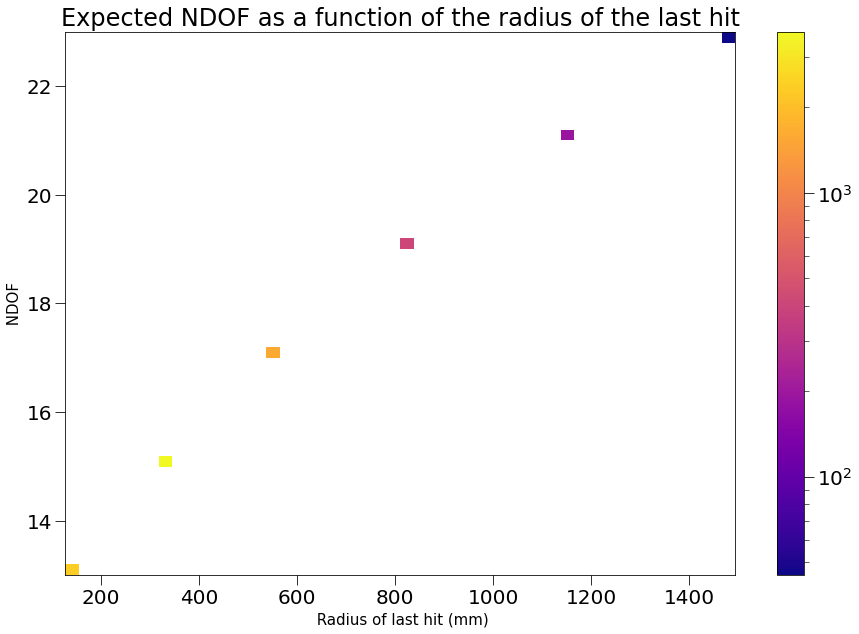

In [154]:
plot2DHistogram(rad[inBB & inBE][hitsFirstDet],ENDOF[hitsFirstDet], bins=50, label="Expected NDOF as a function of the radius of the last hit; Radius of last hit (mm); NDOF ", savefig=True)

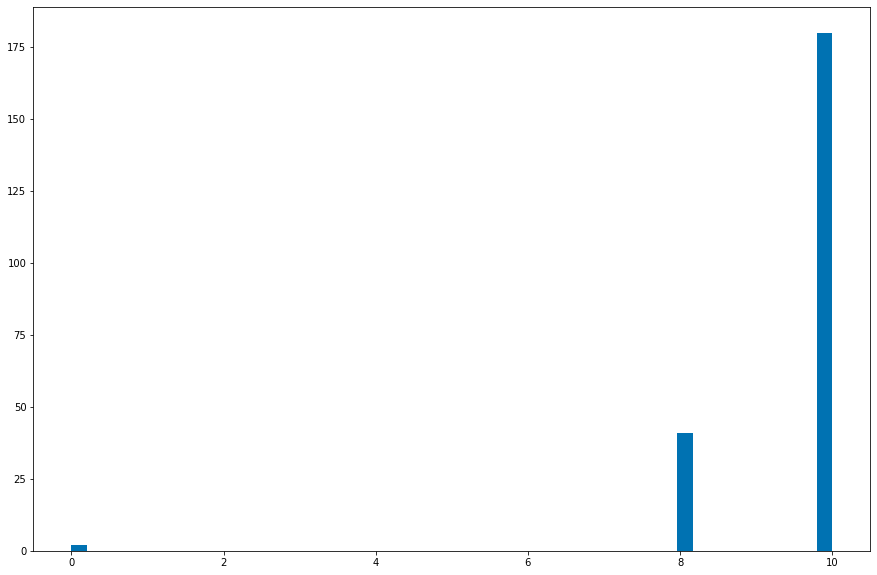

In [99]:
plot1DHistogram(ENDOF-tracks.ndf[inBB & inBE], bins=np.linspace(0,10,50))

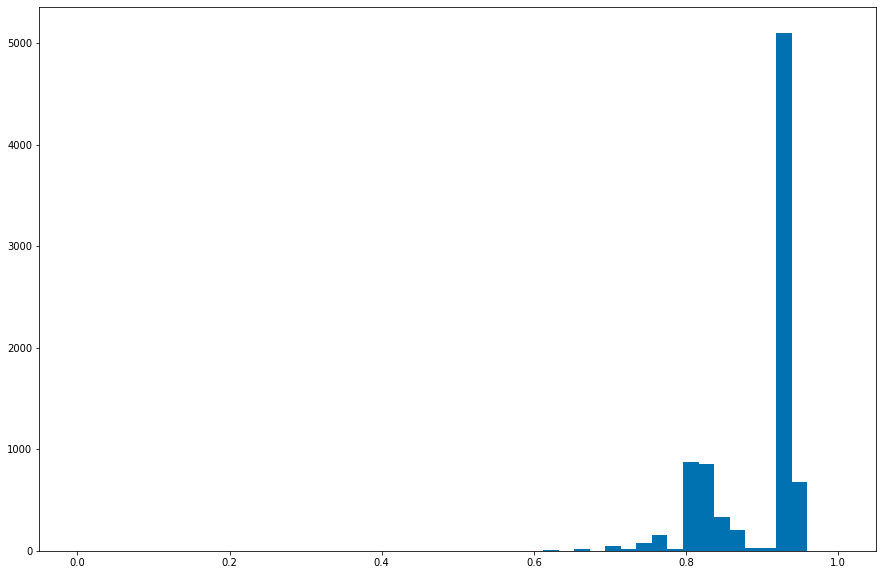

In [100]:
plot1DHistogram((ENDOF-tracks.ndf[inBB & inBE])/ENDOF, bins=np.linspace(0,1,50))

In [101]:
print("Number of tracks analyzed for holes")
print(len(ak.flatten((ENDOF-tracks.ndf[inBB & inBE])/ENDOF)))
print("Number of holes.")
print(ak.sum(ENDOF-tracks.ndf[inBB & inBE]))
print("Holes as a percentage of hits+holes")
print(ak.mean((ENDOF-tracks.ndf[inBB & inBE])/ENDOF)*100)

Number of tracks analyzed for holes
8429
Number of holes.
113550.0
Holes as a percentage of hits+holes
89.2957083535623


In [139]:
ENDOFE=expectedNDOF((tracks.rxB,tracks.ryB,tracks.rzB),(tracks.rxE,tracks.ryE,tracks.rzE), zout=200, zoutmin=80)

In [103]:
inBB=((tracks.rzB < 80) & (tracks.rzB > -80))
inBEE=(((tracks.rzE < 200) & (tracks.rzE >= 80)) |  ((tracks.rzE > -200)& (tracks.rzE <= -80)))

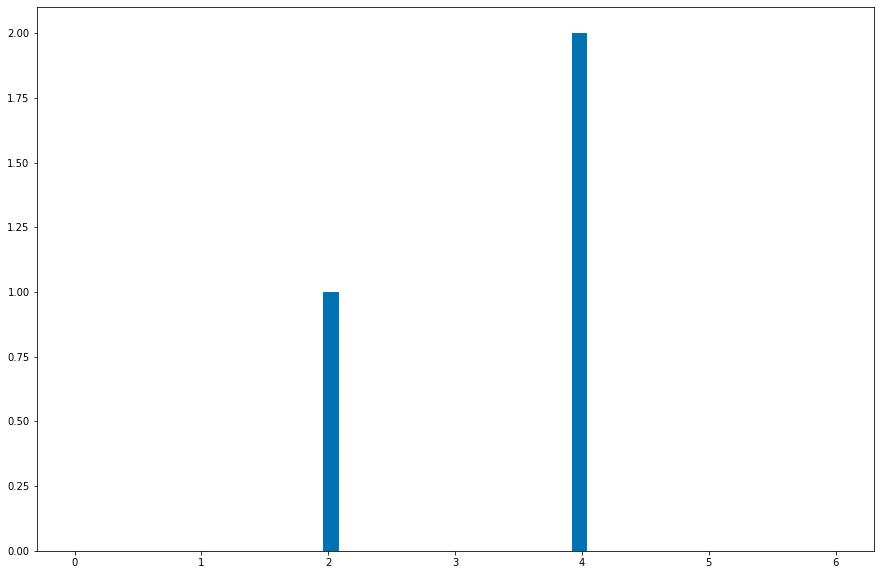

In [104]:
plot1DHistogram(ENDOFE-tracks.ndf[inBB & inBEE], bins=np.linspace(0,6,50))

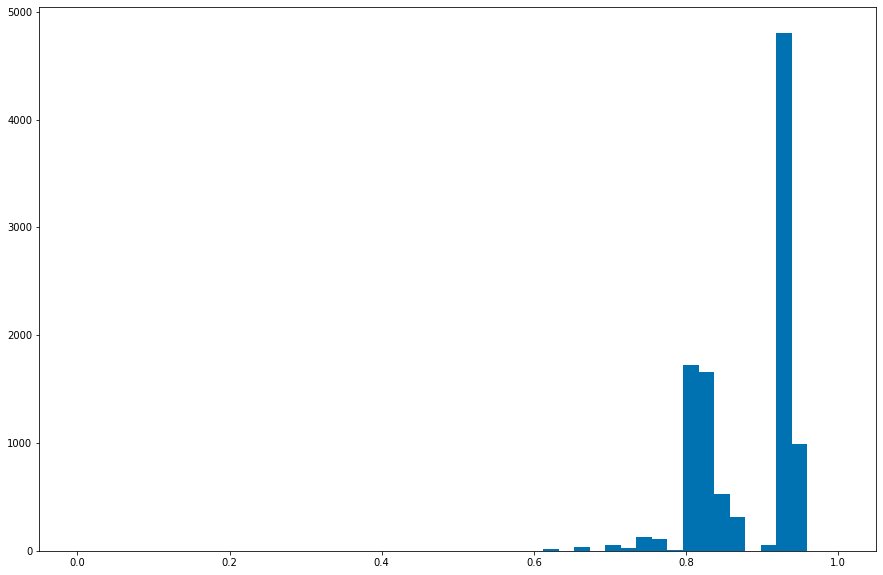

In [105]:
plot1DHistogram((ENDOFE-tracks.ndf[inBB & inBEE])/ENDOFE, bins=np.linspace(0,1,50))

In [106]:
print("Number of tracks analyzed for holes")
print(len(ak.flatten((ENDOFE-tracks.ndf[inBB & inBEE])/ENDOFE)))
print("Number of holes.")
print(ak.sum(ENDOFE-tracks.ndf[inBarrelB & inBEE]))
print("Holes as a percentage of hits+holes")
print(ak.mean((ENDOFE-tracks.ndf[inBB & inBEE])/ENDOFE)*100)

Number of tracks analyzed for holes
10459
Number of holes.
145070.0
Holes as a percentage of hits+holes
87.93787717912984


In [107]:
firstCircleStart=(radB[inBB & inBE] <40) & (((ENDOF-tracks.ndf[inBB & inBE])/ENDOF) > 0)

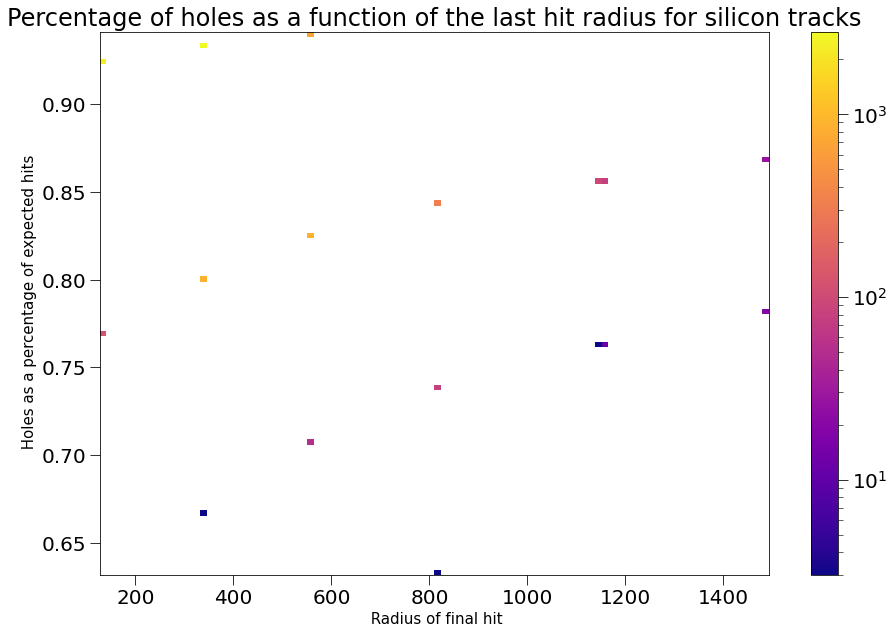

In [156]:
plot2DHistogram(rad[inBB & inBE][firstCircleStart],(ENDOF[firstCircleStart]-tracks.ndf[inBB & inBE][firstCircleStart])/ENDOF[firstCircleStart], label="Percentage of holes as a function of the last hit radius for silicon tracks; Radius of final hit; Holes as a percentage of expected hits", savefig=True)

In [109]:
secondCircleStart=(radB[inBB & inBE] >40) & (((ENDOF-tracks.ndf[inBB & inBE])/ENDOF) > 0)

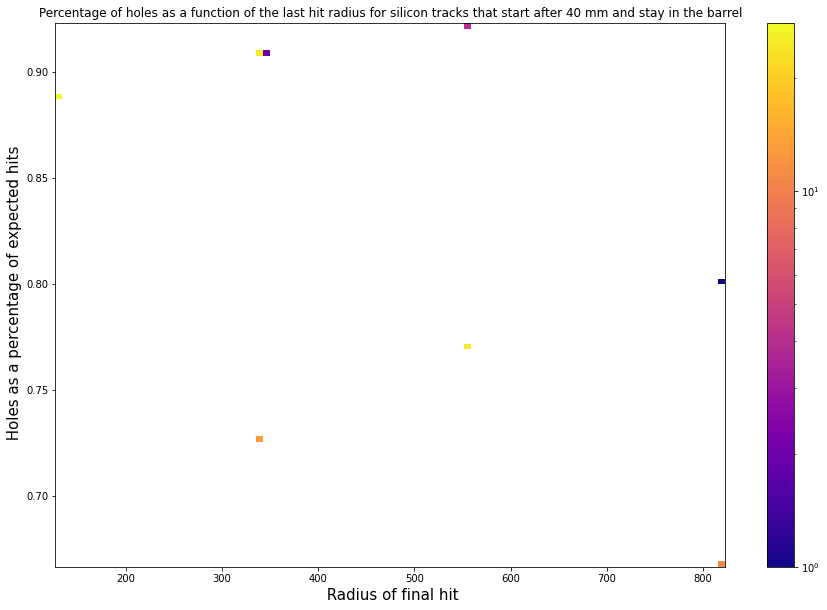

In [110]:
plot2DHistogram(rad[inBB & inBE][secondCircleStart],(ENDOF[secondCircleStart]-tracks.ndf[inBB & inBE][secondCircleStart])/ENDOF[secondCircleStart], label="Percentage of holes as a function of the last hit radius for silicon tracks that start after 40 mm and stay in the barrel; Radius of final hit; Holes as a percentage of expected hits")

In [111]:
print(tracks.type)

40 * Momentum4D[pt: var * float32, theta: var * float32, phi: var * float32, mass: var * float64, d0: var * float32, z0: var * float32, t: var * float32, chi2: var * float32, ndf: var * int32, dEdx: var * float32, rInner: var * float32, RIH: var * float32, SHB: var * uint32, SHE: var * uint32, HB: var * uint32, HE: var * uint32, TB: var * uint32, TE: var * uint32, rxE: var * float32, ryE: var * float32, rzE: var * float32, rxB: var * float32, ryB: var * float32, rzB: var * float32, rxC: var * float32, ryC: var * float32, rzC: var * float32, rx: var * float32, ry: var * float32, rz: var * float32, loc: var * int32, dEdxError: var * float32, type: var * int32, twoValue: var * float32, omegaB: var * float32, omegaE: var * float32]


In [112]:
findLen(tracks.SHB)

40
1847
1814
1812
1799
1816
1794
1726
1791
1797
1733
1803
1810
1819
1771
1803
1821
1728
1782
1798
1784
1851
1802
1836
1784
1806
1781
1772
1805
1843
1735
1839
1809
1830
1760
1794
1796
1728
1795
1892
1785


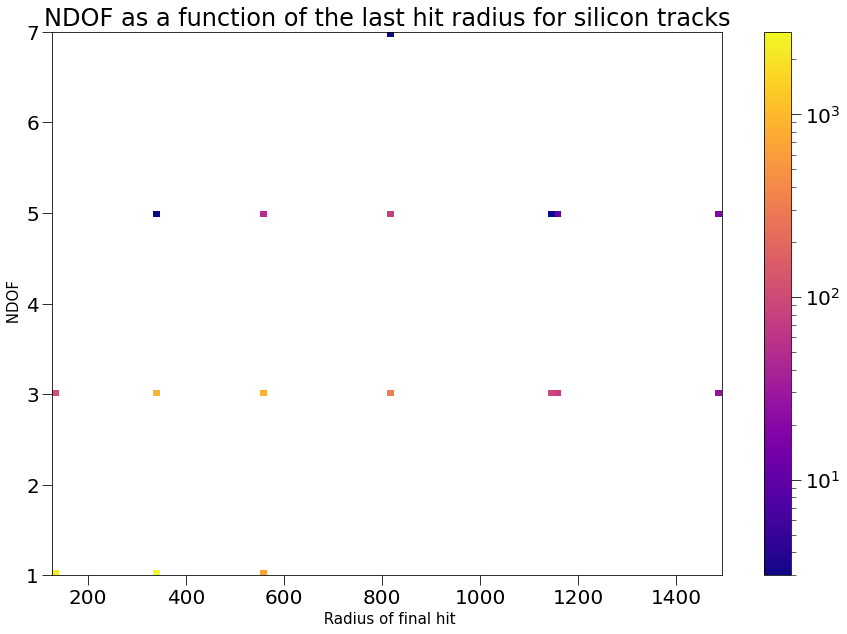

In [155]:
plot2DHistogram(rad[inBB & inBE][firstCircleStart],tracks.ndf[inBB & inBE][firstCircleStart], label="NDOF as a function of the last hit radius for silicon tracks; Radius of final hit; NDOF", savefig=True)

In [114]:
# read in truth particles from Monte Carlo
vector.register_awkward()
mcPart = ak.zip({"px": tree["MCParticle.momentum.x"], 
                 "py": tree["MCParticle.momentum.y"], 
                 "pz": tree["MCParticle.momentum.z"], 
                 "mass": tree["MCParticle.mass"], 
                 "pdg": tree["MCParticle.PDG"],
                 "status": tree["MCParticle.generatorStatus"],
                 "vtxX" : tree["MCParticle.vertex.x"],
                 "vtxY" : tree["MCParticle.vertex.y"],
                 "vtxZ" : tree["MCParticle.vertex.z"],
                 "endX" : tree["MCParticle.endpoint.x"],
                 "endY" : tree["MCParticle.endpoint.y"],
                 "endZ" : tree["MCParticle.endpoint.z"],
                 "charge": tree["MCParticle.charge"],
                 "time" : tree["MCParticle.time"]},
                                   with_name="Momentum4D")


# select only status 1 particles, with muon PDG ID
truthMuons = mcPart[ (mcPart.status==1) & (abs(mcPart.pdg)==13)]

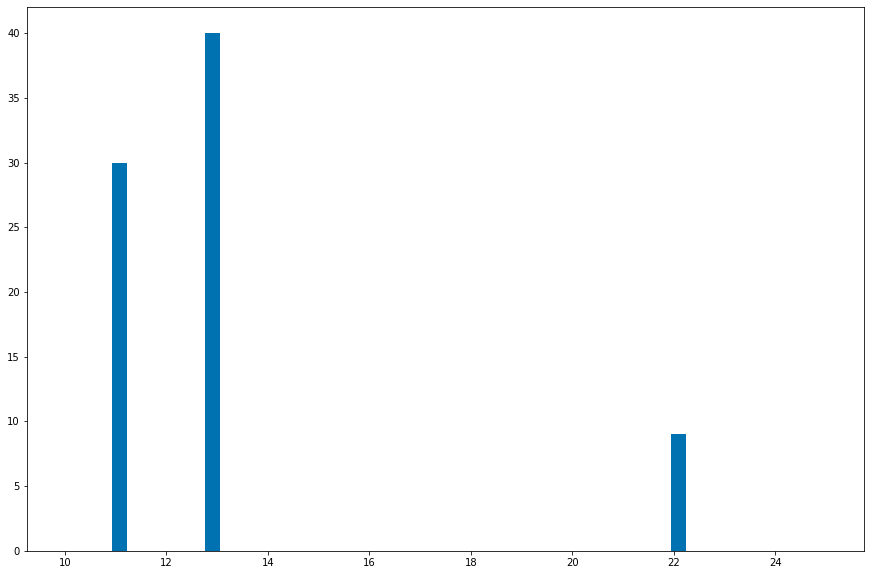

In [115]:
plot1DHistogram(mcPart.pdg, bins=np.linspace(10,25,50))

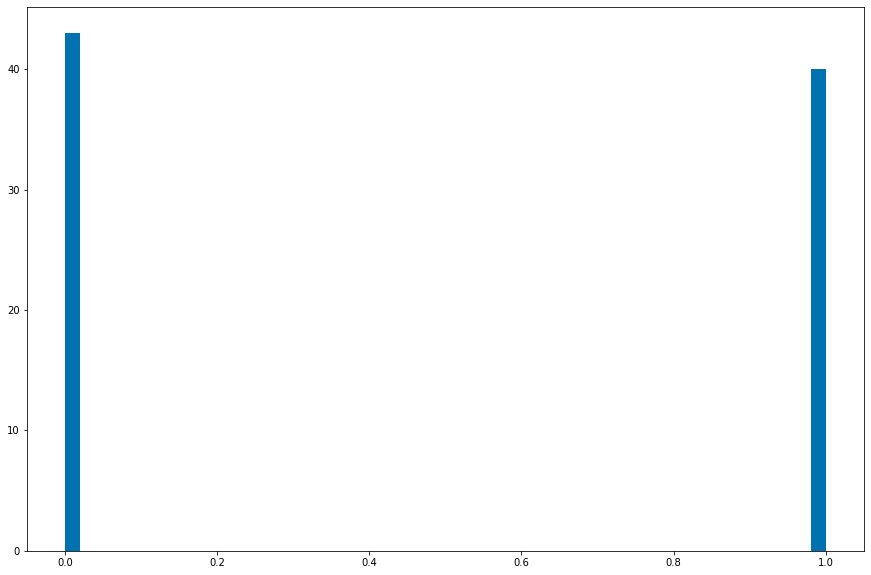

In [116]:
plot1DHistogram(mcPart.status, 50)

In [117]:
for i in range(40):
    print(mcPart.pdg[i])
    print(mcPart.status[i])
    print("")

[13, 11, 11]
[1, 0, 0]

[13, 11]
[1, 0]

[13]
[1]

[13]
[1]

[13]
[1]

[13]
[1]

[13]
[1]

[13, 11]
[1, 0]

[13]
[1]

[13, 11]
[1, 0]

[13, 11]
[1, 0]

[13]
[1]

[13, 11, 11]
[1, 0, 0]

[13]
[1]

[13, 11]
[1, 0]

[13]
[1]

[13, 11, 11]
[1, 0, 0]

[13]
[1]

[13]
[1]

[13]
[1]

[13]
[1]

[13]
[1]

[13]
[1]

[13, 11, 22, 22, 22, 22, 22, 22, 22, ..., 11, -11, 11, -11, 11, 22, 11, 11, -11]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[13, 11]
[1, 0]

[13]
[1]

[13]
[1]

[13]
[1]

[13, 11]
[1, 0]

[13]
[1]

[13]
[1]

[13]
[1]

[13, 11]
[1, 0]

[13, 11]
[1, 0]

[13]
[1]

[13, 11, 11]
[1, 0, 0]

[13, 11]
[1, 0]

[13, 11, 11]
[1, 0, 0]

[13, 11]
[1, 0]

[13]
[1]



In [118]:
for i in range(40):
    print(mcPart.status[i])

[1, 0, 0]
[1, 0]
[1]
[1]
[1]
[1]
[1]
[1, 0]
[1]
[1, 0]
[1, 0]
[1]
[1, 0, 0]
[1]
[1, 0]
[1]
[1, 0, 0]
[1]
[1]
[1]
[1]
[1]
[1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0]
[1]
[1]
[1]
[1, 0]
[1]
[1]
[1]
[1, 0]
[1, 0]
[1]
[1, 0, 0]
[1, 0]
[1, 0, 0]
[1, 0]
[1]


In [119]:
print(mcPart.pdg[23])

[13, 11, 22, 22, 22, 22, 22, 22, 22, ..., 11, -11, 11, -11, 11, 22, 11, 11, -11]


In [120]:
print(mcPart.charge[23])

[-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, 1, ..., -1, -1, 1, -1, 1, -1, 0, -1, -1, 1]


In [121]:
print(mcPart.status[23])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [122]:
h0 = mcPart[(abs(mcPart.pdg)==22)]

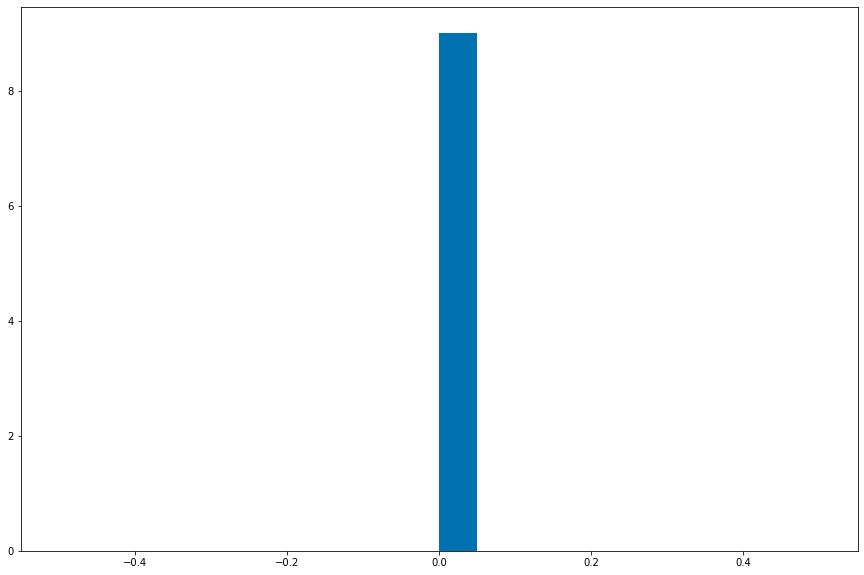

In [123]:
plot1DHistogram(h0.charge, 20)

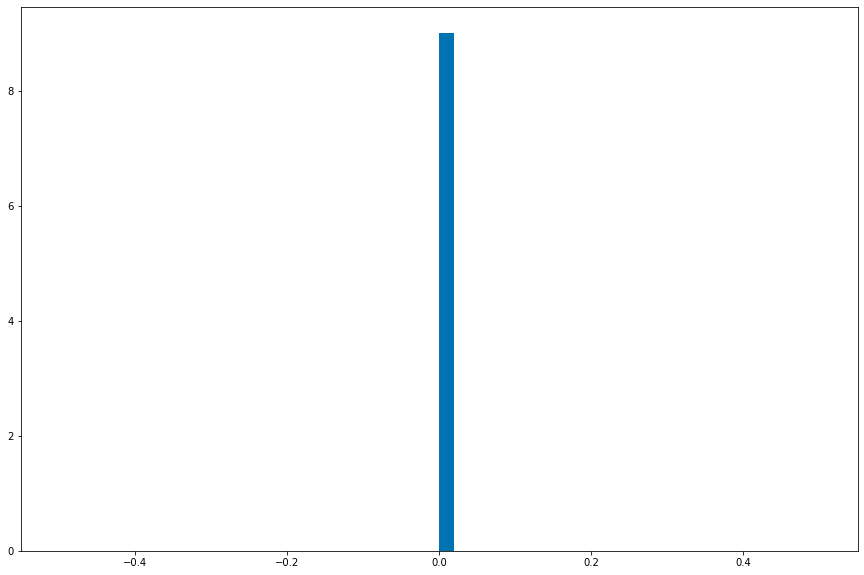

In [124]:
plot1DHistogram(h0.mass, 50)

In [125]:
findLen(tracks.twoValue)

40
1847
1814
1812
1799
1816
1794
1726
1791
1797
1733
1803
1810
1819
1771
1803
1821
1728
1782
1798
1784
1851
1802
1836
1784
1806
1781
1772
1805
1843
1735
1839
1809
1830
1760
1794
1796
1728
1795
1892
1785


In [126]:
print(tracks.twoValue)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]


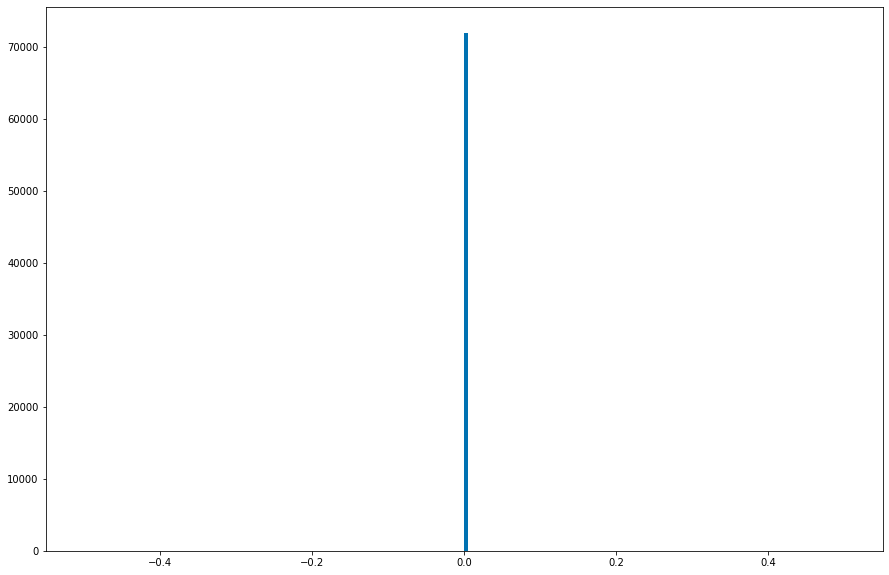

In [127]:
plot1DHistogram(tracks.twoValue, bins=200)

In [128]:
findLen(params.intMap)
findLen(params.intMapFirst)
findLen(params.intMapSecond)

0
0
0


In [129]:
findLen(params.floatMap)
findLen(params.floatMapFirst)
findLen(params.floatMapSecond)

0
0
0


In [130]:
findLen(params.stringMap)
findLen(params.stringMapFirst)
findLen(params.stringMapSecond)

0
0
0


In [131]:
findLen(params.doubleMap)
findLen(params.doubleMapFirst)
findLen(params.doubleMapSecond)

0
0
0


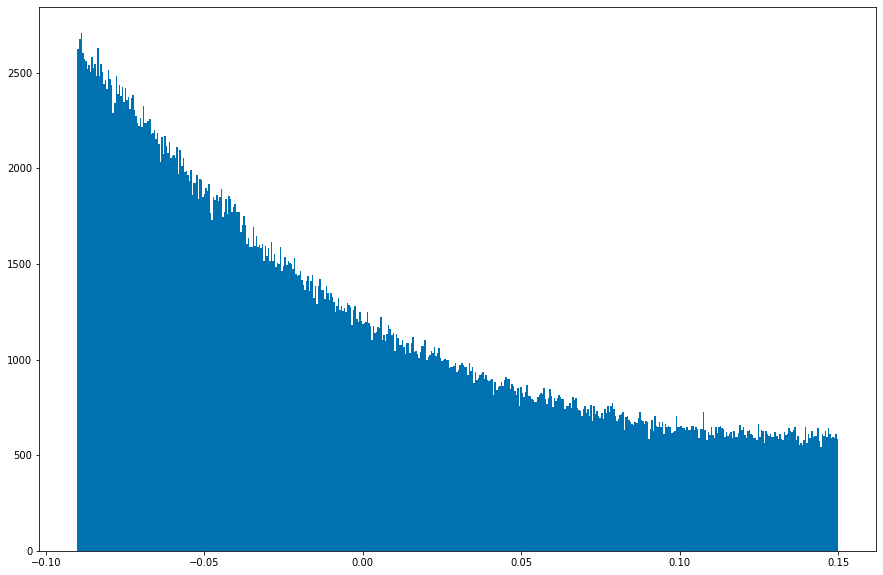

In [132]:
plot1DHistogram(trackerHits["VBTrackerHits.time"], bins=500)

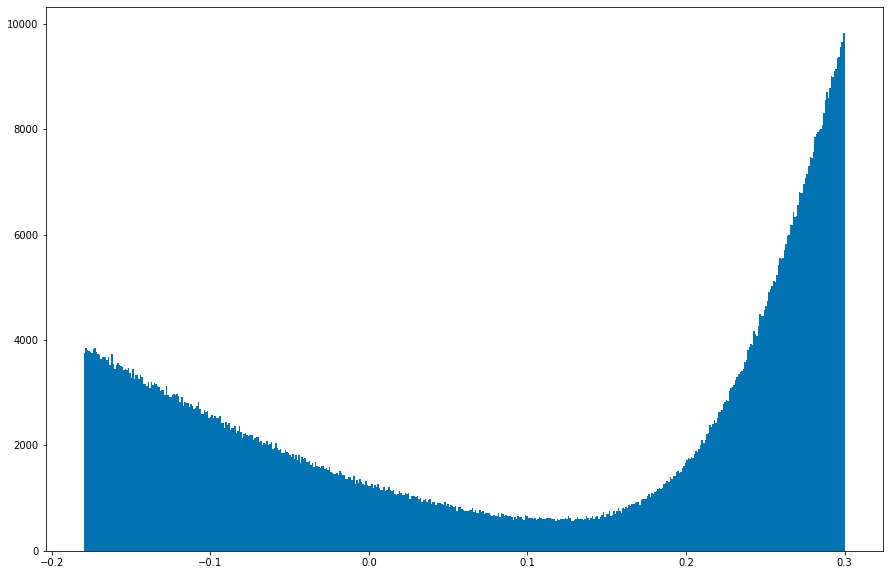

In [133]:
plot1DHistogram(trackerHits["IBTrackerHits.time"], bins=500)

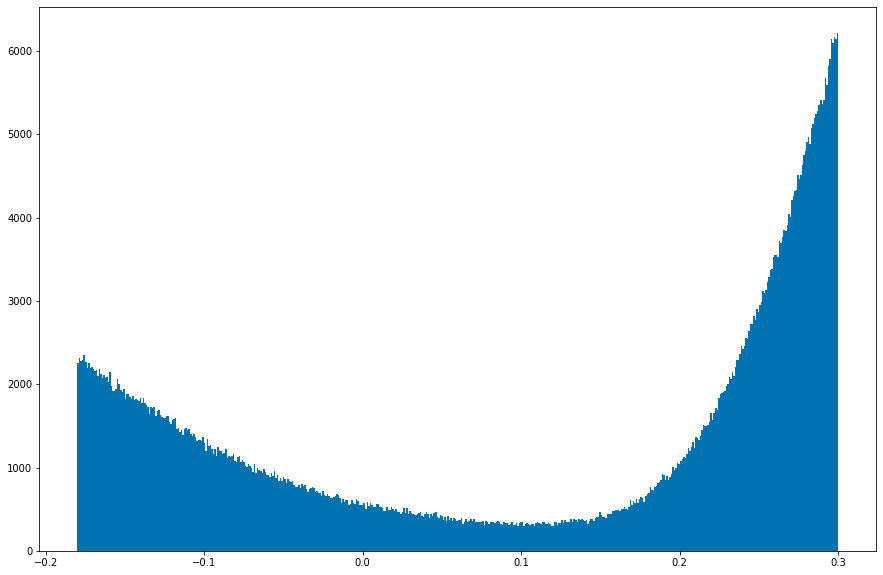

In [134]:
plot1DHistogram(trackerHits["OBTrackerHits.time"], bins=500)

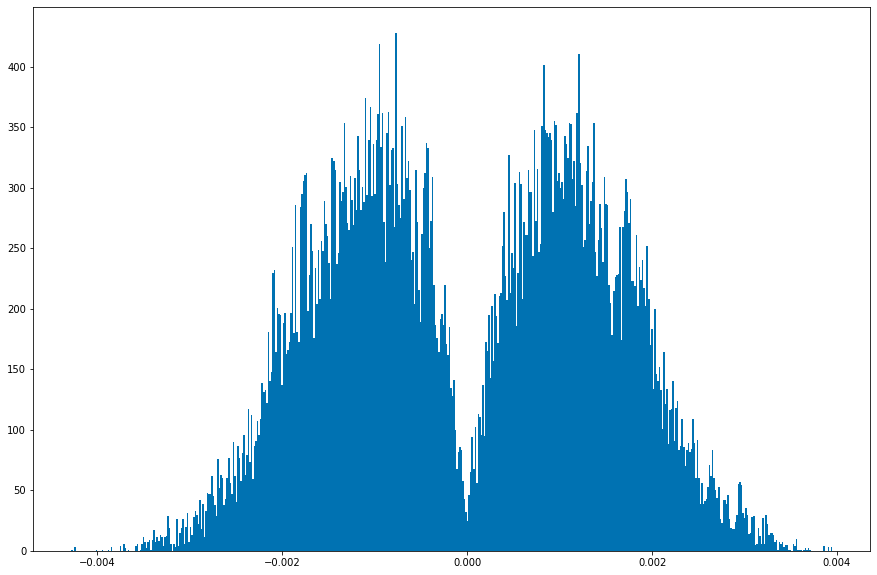

In [135]:
plot1DHistogram(tracks.omegaB, bins=500)

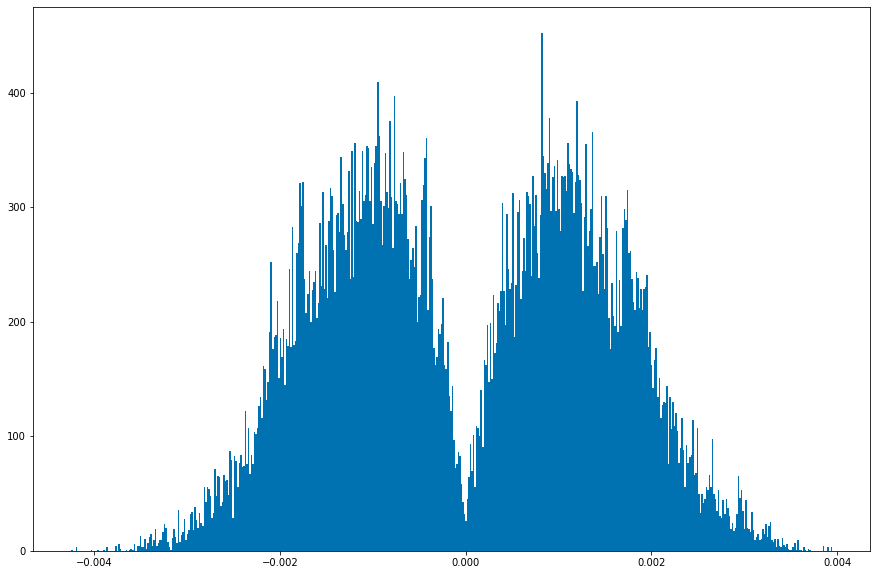

In [136]:
plot1DHistogram(tracks.omegaE, bins=500)

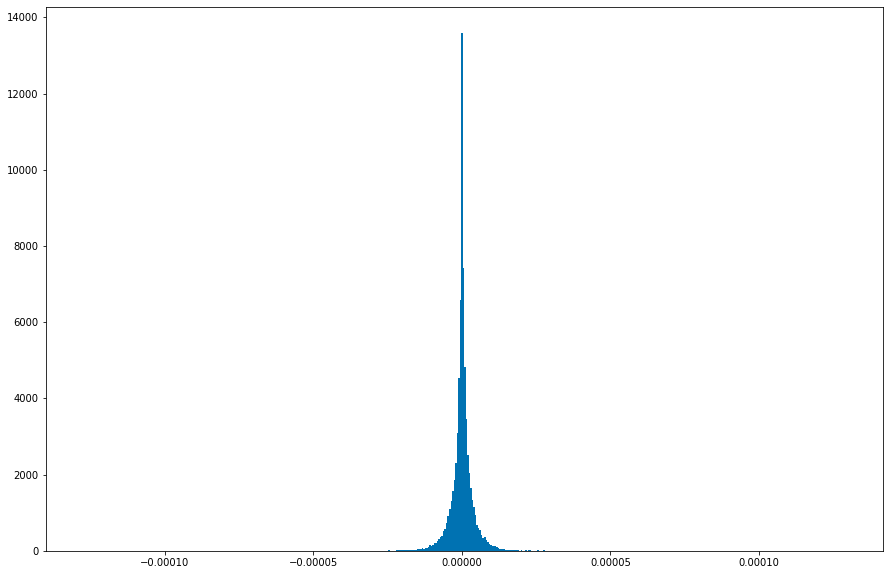

In [137]:
plot1DHistogram(tracks.omegaB - tracks.omegaE, bins=500)